# 1. Imports and Configuration

### We'll start by importing the necessary libraries and setting up the configuration variables, similar to original script.


In [43]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging # Import logging for consistent output
import gc # Import garbage collection
import torch # Import torch to use empty_cache
from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq
from scipy.signal import welch

In [44]:
# Configure basic logging for notebook output
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Configuration ---
DATA_ROOT_DIR = "F:\\data_9"

# Define base sensors
BASE_SENSORS = ['HR', 'EDA', 'TEMP', 'ACC']

# Data Processing Parameters (using fixed values for visualization)
SEGMENT_DURATION_SECONDS = 30
PRE_ICTAL_WINDOW_MINUTES = 30
PRE_ICTAL_GAP_MINUTES = 5 # New: Define the gap duration before seizure onset
PRE_ICTAL_EXCLUSION_BUFFER_MINUTES = 180
POST_ICTAL_BUFFER_MINUTES = 180
SAMPLING_FREQ_HZ = 1 # Target sampling frequency for resampling
# Data Loading Limit
# Set to None to include all patients, or an integer to limit the number of patients
MAX_PATIENTS_TO_INCLUDE = 10 # Example: 10 (to process only the first 10 patients found), set to None for all

# List of patient IDs to explicitly exclude from the run
PATIENTS_TO_EXCLUDE = [] # Example: ["MSEL_0001", "MSEL_0005"]

In [45]:
# Set random seed for reproducibility in segmentation/splitting
SEED = 42
np.random.seed(SEED)

# Helper function for data config identifier (useful for naming)
def get_data_config_identifier(pre_ictal_win, pre_ictal_excl, post_ictal_buf, sampling_freq):
    return f"piw_{pre_ictal_win}_pieb_{pre_ictal_excl}_pib_{post_ictal_buf}_sf_{sampling_freq}"

In [46]:
def extract_features_enhanced(segment_df, fs=SAMPLING_FREQ_HZ):
    """
    Extracts a comprehensive set of time-domain and frequency-domain features 
    from a segment of sensor data. This is an enhanced version of the original
    feature extraction function.

    Args:
        segment_df (pd.DataFrame): A DataFrame representing a single segment of data,
                                     with sensor names as columns.
        fs (int): The sampling frequency of the signal.

    Returns:
        np.array: A 1D numpy array containing the extracted features for all sensors.
    """
    all_features = []
    
    # Define frequency bands for spectral power features
    freq_bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30)
    }

    for sensor in segment_df.columns:
        signal = segment_df[sensor].values

        # Original Time-domain features
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        var_val = np.var(signal)
        min_val = np.min(signal)
        max_val = np.max(signal)
        rms_val = np.sqrt(np.mean(signal**2))
        skew_val = skew(signal)
        kurt_val = kurtosis(signal)

        # --- New Time-domain features ---
        # Mean Absolute Deviation
        mad_val = np.mean(np.abs(signal - mean_val))
        
        # Interquartile Range
        iqr_val = np.percentile(signal, 75) - np.percentile(signal, 25)

        # Zero-Crossing Rate
        zcr_val = ((signal[:-1] * signal[1:]) < 0).sum()

        features = [
            mean_val, std_val, var_val, min_val, max_val, rms_val, skew_val, kurt_val,
            mad_val, iqr_val, zcr_val
        ]

        # Frequency-domain features
        N = len(signal)
        if N > 1:
            # Original Frequency-domain features
            yf = fft(signal)
            power_spectrum_full = np.abs(yf[:N//2])**2
            spectral_energy = np.sum(power_spectrum_full)
            
            power_spectrum_norm = power_spectrum_full / (spectral_energy + 1e-9)
            spectral_entropy = -np.sum(power_spectrum_norm * np.log2(power_spectrum_norm + 1e-9))

            features.extend([spectral_energy, spectral_entropy])

            # --- New Frequency-domain features using Welch's method ---
            freqs, psd = welch(signal, fs=fs, nperseg=min(N, 256))
            
            # Dominant Frequency
            dominant_freq = freqs[np.argmax(psd)] if len(psd) > 0 else 0
            features.append(dominant_freq)
            
            # Spectral Power in different bands
            total_power = np.sum(psd)
            for band, (low, high) in freq_bands.items():
                band_power = np.sum(psd[(freqs >= low) & (freqs <= high)])
                band_power_ratio = band_power / (total_power + 1e-9)
                features.append(band_power_ratio)

        else:
            # Append zeros if signal is too short for frequency analysis
            # (11 time-domain features + 2 original freq + 1 new freq + 4 band ratios)
            features.extend([0] * (2 + 1 + 4))

        all_features.extend(features)
        
    return np.array(all_features)

### 2. Finding Patient Data (Step 1)
#### We'll confirm the example patient folder exists and list the files within it to get an idea of the data structure.

In [47]:
# Find all potential patient directories
all_patient_dirs = sorted([os.path.join(DATA_ROOT_DIR, d) for d in os.listdir(DATA_ROOT_DIR) if os.path.isdir(os.path.join(DATA_ROOT_DIR, d)) and d.startswith("MSEL_")])

logging.info(f"Found {len(all_patient_dirs)} potential patient directories.")

# Apply exclusion filter
filtered_patient_dirs = [d for d in all_patient_dirs if os.path.basename(d) not in PATIENTS_TO_EXCLUDE]
logging.info(f"After excluding {len(all_patient_dirs) - len(filtered_patient_dirs)} patients: {len(filtered_patient_dirs)} patient directories remaining.")

# Apply limit filter
if MAX_PATIENTS_TO_INCLUDE is not None:
    patient_dirs_to_process = filtered_patient_dirs[:MAX_PATIENTS_TO_INCLUDE]
    logging.info(f"Limiting to {MAX_PATIENTS_TO_INCLUDE} patients: {len(patient_dirs_to_process)} patient directories selected for processing.")
else:
    patient_dirs_to_process = filtered_patient_dirs
    logging.info(f"No limit applied. {len(patient_dirs_to_process)} patient directories selected for processing.")

if not patient_dirs_to_process:
    logging.error("No patient directories selected for processing. Please check DATA_ROOT_DIR, MAX_PATIENTS_TO_INCLUDE, and PATIENTS_TO_EXCLUDE.")

2025-06-09 21:33:33,961 - INFO - Found 21 potential patient directories.
2025-06-09 21:33:33,962 - INFO - After excluding 0 patients: 21 patient directories remaining.
2025-06-09 21:33:33,963 - INFO - Limiting to 10 patients: 10 patient directories selected for processing.


### 3. Processing Example Patient Data (Step 2 - Individual Patient Processing)
### This section adapts the core logic from your `prepare_patient_data` function to run step-by-step for the selected patient.

#### 3.1 Load Raw Sensor Data (`load_sensor_data_for_patient`)
#### We'll load the raw data for the `BASE_SENSORS` for the example patient.

In [48]:
def load_raw_sensor_data_for_patient(patient_dir, sensors):
    """
    Loads Parquet data for specified sensors for a given patient,
    concatenates it, sorts by timestamp, and converts to UTC.
    Returns the raw data DataFrames *before* any preprocessing.

    Args:
        patient_dir (str): The directory for the specific patient.
        sensors (list): List of sensor names (e.g., ['HR', 'EDA']) from BASE_SENSORS.

    Returns:
        dict: A dictionary where keys are attribute names (e.g., 'HR')
              and values are Pandas DataFrames containing the raw data for the
              specified sensors. Returns an empty dict if no data is found
              for any of the specified sensors.
    """
    attribute_data = {}
    sensor_mapping = {"HR": "HR", "EDA": "EDA", "TEMP": "TEMP", "ACC": "Acc Mag"}
    patient_id = os.path.basename(patient_dir)

    for sensor_name in sensors:
        if sensor_name not in sensor_mapping:
            continue

        attr_folder = sensor_name
        attr_name_part = sensor_mapping[sensor_name]

        parquet_files = sorted(
            glob.glob(
                os.path.join(
                    patient_dir,
                    f"Empatica-{attr_folder}",
                    f"{patient_id}_Empatica-{attr_folder}_{attr_name_part}_segment_*.parquet",
                )
            )
        )

        if not parquet_files:
            continue

        all_dfs = []
        for file_path in parquet_files:
            try:
                df = pd.read_parquet(file_path)
                if "time" in df.columns and "data" in df.columns:
                    df['data'] = df['data'] / 1_000_000_000
                    logging.info(f"[{patient_id}] Divided 'data' column by 10^9 for file: {os.path.basename(file_path)}")
                    df["timestamp"] = pd.to_datetime(
                        df["time"] / 1000, unit="s", utc=True
                    )
                    df = df.rename(columns={"data": sensor_name})
                    df = df[["timestamp", sensor_name]]
                    all_dfs.append(df)
                else:
                    logging.warning(
                        f"[{patient_id}] Warning: Parquet file {file_path} does not have expected 'time' and 'data' columns. Skipping."
                    )

            except Exception as e:
                logging.error(f"[{patient_id}] Error reading Parquet file {file_path}: {e}")

        if all_dfs:
            combined_df = pd.concat(all_dfs, ignore_index=True)
            combined_df = combined_df.sort_values(by="timestamp").reset_index(drop=True)
            attribute_data[sensor_name] = combined_df

    return attribute_data


In [49]:
def preprocess_raw_sensor_data(sensor_data_dict, patient_id):
    """
    Performs basic preprocessing on raw sensor data:
    - Handles zero values (replaces with NaN for interpolation)
    - Sets timestamp as index for time-based operations.
    - Handles missing values (interpolation)
    - (Optional: Add more robust outlier handling or smoothing here if needed)

    Args:
        sensor_data_dict (dict): Dictionary of raw sensor DataFrames.
        patient_id (str): The ID of the current patient for logging.

    Returns:
        dict: Dictionary of preprocessed sensor DataFrames.
    """
    preprocessed_data = {}
    logging.info(f"[{patient_id}] Starting raw sensor data preprocessing...")

    for sensor_name, df in sensor_data_dict.items():
        if df.empty or 'timestamp' not in df.columns:
            logging.warning(f"[{patient_id}] Skipping preprocessing for {sensor_name}: Data is empty or missing timestamp column.")
            preprocessed_data[sensor_name] = df.copy() # Keep empty df
            continue

        processed_df = df.copy()

        # Set timestamp as index for time-based operations like interpolation
        processed_df = processed_df.set_index('timestamp').sort_index()

        # Handle zero values: Replace 0 with NaN assuming 0 is invalid for these sensors
        # Consider if 0 is a valid reading for any sensor (e.g., ACC magnitude could be near 0)
        # This assumes 0 is invalid for HR, EDA, TEMP, ACC magnitude. Adjust if necessary.
        zero_count = (processed_df[sensor_name] == 0).sum()
        if zero_count > 0:
             logging.info(f"[{patient_id}]   Replacing {zero_count} zero values with NaN for {sensor_name}.")
             processed_df[sensor_name] = processed_df[sensor_name].replace(0, np.nan)


        # Handle missing values: Interpolate
        initial_nan_count = processed_df[sensor_name].isnull().sum()
        if initial_nan_count > 0:
            logging.info(f"[{patient_id}]   Interpolating {initial_nan_count} missing values for {sensor_name}.")
            # Ensure index is DatetimeIndex before time-based interpolation
            if isinstance(processed_df.index, pd.DatetimeIndex):
                processed_df[sensor_name] = processed_df[sensor_name].interpolate(method='time', limit_direction='both')
            else:
                logging.warning(f"[{patient_id}]   Index is not DatetimeIndex for {sensor_name}. Falling back to linear interpolation.")
                processed_df[sensor_name] = processed_df[sensor_name].interpolate(method='linear', limit_direction='both')

            # Fill remaining NaNs (e.g., at start/end) with nearest valid value
            processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
            final_nan_count = processed_df[sensor_name].isnull().sum()
            if final_nan_count > 0:
                 logging.warning(f"[{patient_id}]   Warning: {final_nan_count} NaN values remain after interpolation and fill for {sensor_name}.")

        preprocessed_data[sensor_name] = processed_df
        logging.info(f"[{patient_id}]   Finished preprocessing for {sensor_name}. New shape: {processed_df.shape}")

    logging.info(f"[{patient_id}] Finished raw sensor data preprocessing.")
    return preprocessed_data

#### 3.2 Load Seizure Annotations (`load_seizure_annotations`)
#### Load the seizure times for the example patient.

In [50]:
def load_and_preprocess_seizure_annotations(patient_dir, min_duration_sec, min_inter_seizure_interval_hours):
    """
    Loads and processes the SeerAnnotations CSV for a given patient.
    Converts start_time and end_time to UTC datetime objects.
    Filters annotations based on minimum duration.
    Filters annotations to keep only 'lead seizures' based on minimum inter-seizure interval.

    Args:
        patient_dir (str): The directory for the specific patient.
        min_duration_sec (int): Minimum duration for a valid seizure annotation.
        min_inter_seizure_interval_hours (int): Minimum time in hours between the end of one seizure
                                                 and the start of the next for the latter to be considered a lead seizure.


    Returns:
        tuple: (raw_annotations_df, preprocessed_annotations_df)
               raw_annotations_df: DataFrame with all loaded annotations.
               preprocessed_annotations_df: DataFrame with annotations filtered by duration and inter-seizure interval.
               Returns (empty df, empty df) if file not found or no valid annotations.
    """
    patient_id = os.path.basename(patient_dir)
    annotation_file = os.path.join(
        patient_dir, f"{os.path.basename(patient_id)}_SeerAnnotations.csv" # Use patient_id here
    )
    logging.info(f"[{patient_id}] Starting load and preprocess seizure annotations from: {annotation_file}")
    raw_annotations_df = pd.DataFrame(columns=["start_time", "end_time"])
    preprocessed_annotations_df = pd.DataFrame(columns=["start_time", "end_time"])


    try:
        raw_annotations_df = pd.read_csv(annotation_file)
        if (
            "start_time" in raw_annotations_df.columns
            and "end_time" in raw_annotations_df.columns
        ):
            raw_annotations_df["start_time"] = pd.to_datetime(
                raw_annotations_df["start_time"] / 1000, unit="s", utc=True
            )
            raw_annotations_df["end_time"] = pd.to_datetime(
                raw_annotations_df["end_time"] / 1000, unit="s", utc=True
            )
            # Ensure end_time is at least 1 second after start_time to avoid zero-duration seizures
            raw_annotations_df["end_time"] = raw_annotations_df.apply(
                lambda row: row["end_time"]
                if row["end_time"] > row["start_time"]
                else row["start_time"] + pd.Timedelta(seconds=1),
                axis=1,
            )
            logging.info(f"[{patient_id}] Successfully loaded {len(raw_annotations_df)} raw annotations.")

            # --- Preprocessing Step 1: Filter by minimum duration ---
            raw_annotations_df['duration_sec'] = (raw_annotations_df['end_time'] - raw_annotations_df['start_time']).dt.total_seconds()
            duration_filtered_df = raw_annotations_df[raw_annotations_df['duration_sec'] >= min_duration_sec].copy()
            duration_filtered_df = duration_filtered_df[['start_time', 'end_time']].sort_values(by='start_time').reset_index(drop=True) # Sort by start time

            removed_count_duration = len(raw_annotations_df) - len(duration_filtered_df)
            if removed_count_duration > 0:
                logging.info(f"[{patient_id}] Removed {removed_count_duration} annotations with duration less than 5 seconds.")
            logging.info(f"[{patient_id}] {len(duration_filtered_df)} annotations remaining after duration filtering.")


            # --- Preprocessing Step 2: Filter by minimum inter-seizure interval (Lead Seizures) ---
            lead_seizures_list = []
            min_interval_timedelta = pd.Timedelta(hours=min_inter_seizure_interval_hours)

            if not duration_filtered_df.empty:
                lead_seizures_list.append(duration_filtered_df.iloc[0]) # The very first seizure is always a lead seizure

                for i in range(1, len(duration_filtered_df)):
                    current_seizure = duration_filtered_df.iloc[i]
                    previous_seizure = duration_filtered_df.iloc[i-1]

                    time_since_last_seizure_end = current_seizure['start_time'] - previous_seizure['end_time']

                    if time_since_last_seizure_end >= min_interval_timedelta:
                        lead_seizures_list.append(current_seizure)
                        # logging.info(f"[{patient_id}] Seizure {i+1} is a lead seizure. Interval: {time_since_last_seizure_end}") # Optional detailed log
                    # else:
                        # logging.info(f"[{patient_id}] Seizure {i+1} is NOT a lead seizure. Interval: {time_since_last_seizure_end}") # Optional detailed log


                preprocessed_annotations_df = pd.DataFrame(lead_seizures_list).reset_index(drop=True)
                removed_count_interval = len(duration_filtered_df) - len(preprocessed_annotations_df)
                if removed_count_interval > 0:
                    logging.info(f"[{patient_id}] Removed {removed_count_interval} annotations due to insufficient inter-seizure interval (< {min_inter_seizure_interval_hours} hours).")
                logging.info(f"[{patient_id}] {len(preprocessed_annotations_df)} lead seizure annotations remaining.")

            else:
                 logging.warning(f"[{patient_id}] No annotations left after duration filtering. Skipping inter-seizure interval filtering.")
                 preprocessed_annotations_df = pd.DataFrame(columns=["start_time", "end_time"]) # Ensure empty df is returned


            logging.info(f"[{patient_id}] Finished load and preprocess seizure annotations.")
            return raw_annotations_df[['start_time', 'end_time']], preprocessed_annotations_df

        else:
            logging.error(
                f"[{patient_id}] Error: Annotation file {annotation_file} does not have expected 'start_time' and 'end_time' columns."
            )
            return pd.DataFrame(columns=["start_time", "end_time"]), pd.DataFrame(columns=["start_time", "end_time"]) # Return empty dfs on column error
    except FileNotFoundError:
        logging.warning(f"[{patient_id}] No annotation file found at: {annotation_file}. Assuming no seizures.")
        return pd.DataFrame(columns=["start_time", "end_time"]), pd.DataFrame(columns=["start_time", "end_time"]) # Return empty dfs if not found
    except Exception as e:
        logging.error(f"[{patient_id}] Error reading annotation file {annotation_file}: {e}")
        return pd.DataFrame(columns=["start_time", "end_time"]), pd.DataFrame(columns=["start_time", "end_time"]) # Return empty dfs on other errors



#### 3.3 Synchronize, Merge, and Scale Data (`synchronize_and_merge_data`)
##### This step resamples all sensor data to a common frequency, merges them into a single DataFrame, handles missing values, and applies scaling.

In [51]:
def synchronize_and_merge_data(patient_id, sensor_data_dict, target_freq_hz):
    """
    Synchronizes sensor data, merges them, applies Scaling, handles NaNs,
    and ensures columns are in BASE_SENSORS order. Interpolates each sensor
    individually after resampling before merging to potentially reduce memory usage.
    Exports intermediate dataframes before and after resampling to CSV.

    Args:
        patient_id (str): The ID of the current patient for logging and file naming.
        sensor_data_dict (dict): Dictionary with sensor names (matching BASE_SENSORS) as keys and
                                 DataFrames (with 'timestamp' and data column named after sensor) as values.
                                 DataFrames are expected to have a DatetimeIndex.
        target_freq_hz (int): The target frequency in Hz for resampling.


    Returns:
        tuple: (resampled_interpolated_data_dict, merged_df_before_scaling, merged_df_after_scaling)
               resampled_interpolated_data_dict: Dictionary of DataFrames after resampling and interpolation.
               merged_df_before_scaling: DataFrame after merging the interpolated data.
               merged_df_after_scaling: DataFrame after merging and scaling.
               Returns (None, None, None) if input is empty or processing fails.
    """
    logging.info(f"[{patient_id}] Starting synchronize and merge data process...")

    if not sensor_data_dict:
        logging.warning(f"[{patient_id}] sensor_data_dict is empty. Skipping synchronization.")
        return None, None, None

    resampled_interpolated_data = {}
    logging.info(f"[{patient_id}] Resampling and interpolating individual sensor data to {target_freq_hz}Hz...")
    for sensor_name, df in sensor_data_dict.items():
        if df.empty or not isinstance(df.index, pd.DatetimeIndex):
             logging.warning(f"[{patient_id}] Skipping processing for {sensor_name}: Data is empty or index is not DatetimeIndex.")
             continue
         
        if target_freq_hz <= 0:
            logging.error(
                f"[{patient_id}] Error: Target frequency must be positive, got {target_freq_hz}. Cannot resample."
            )
            continue # Skip this sensor but continue with others if possible
        rule = f"{1/target_freq_hz}s"
        try:
            # Resample the data
            # resampled_df = df[[sensor_name]].asfreq(rule)
            resampled_df = df[[sensor_name]].resample(rule).mean()

            logging.info(f"[{patient_id}] Resampled sensor {sensor_name} to {target_freq_hz}Hz. Shape: {resampled_df.shape}")
            # Check for NaNs, None, and 0s after resampling
            num_nans = resampled_df[sensor_name].isna().sum()
            num_zeros = (resampled_df[sensor_name] == 0).sum()
            num_total = len(resampled_df)

            logging.info(f"[{patient_id}] {sensor_name} Resample Summary: Total={num_total}, NaNs={num_nans}, Zeros={num_zeros}")
            # Interpolate missing values AFTER resampling
            if resampled_df[sensor_name].isnull().sum() > 0:
                logging.info(f"[{patient_id}] Interpolating {resampled_df[sensor_name].isnull().sum()} NaNs in resampled {sensor_name}.")
                # Ensure index is DatetimeIndex before time-based interpolation
                if isinstance(resampled_df.index, pd.DatetimeIndex):
                    resampled_df[sensor_name] = resampled_df[sensor_name].interpolate(method='time', limit_direction='both')
                else:
                    logging.warning(f"[{patient_id}] Resampled {sensor_name} index is not DatetimeIndex. Falling back to linear interpolation.")
                    resampled_df[sensor_name] = resampled_df[sensor_name].interpolate(method='linear', limit_direction='both')

                # Fill remaining NaNs (e.g., at start/end)
                resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
                if resampled_df[sensor_name].isnull().sum() > 0:
                    logging.warning(f"[{patient_id}] {resampled_df[sensor_name].isnull().sum()} NaNs remain in resampled {sensor_name} after fill.")

            resampled_interpolated_data[sensor_name] = resampled_df
            logging.info(f"[{patient_id}] Finished interpolation for resampled sensor {sensor_name}.")

        except Exception as e:
            logging.error(
                f"[{patient_id}] Error during resampling or interpolation for sensor {sensor_name}: {e}. Skipping sensor."
            )
            continue

    if not resampled_interpolated_data:
        logging.warning(f"[{patient_id}] No data remaining after resampling and interpolation.")
        return None, None, None

    logging.info(f"[{patient_id}] Merging {len(resampled_interpolated_data)} resampled and interpolated dataframes...")
    merged_df = None
    for sensor_name, df in resampled_interpolated_data.items():
        if merged_df is None:
            merged_df = df
        else:
            # Use outer join to keep all timestamps from all sensors
            merged_df = merged_df.join(df, how="outer")


    if merged_df is None or merged_df.empty:
        logging.warning(f"[{patient_id}] Merged DataFrame is empty after joining.")
        return resampled_interpolated_data, None, None # Return resampled data even if merge fails

    merged_df = merged_df.sort_index()
    logging.info(f"[{patient_id}] Merged DataFrame shape after joining interpolated data: {merged_df.shape}")

    # The merged_df should ideally have no NaNs after joining interpolated data,
    # but a final fillna is included for robustness, especially if time indexes
    # don't align perfectly or edge cases exist.
    merged_df_before_scaling = merged_df.fillna(method="ffill").fillna(method="bfill")
    logging.info(f"[{patient_id}] Filled any remaining NaNs after merging.")


    # Drop columns that are still all NaN (shouldn't happen if fillna worked, but defensive)
    merged_df_before_scaling = merged_df_before_scaling.dropna(axis=1, how="all")
    if merged_df_before_scaling.empty or len(merged_df_before_scaling.columns) == 0:
        logging.warning(f"[{patient_id}] Merged DataFrame is empty or has no columns after dropping all-NaN columns.")
        return resampled_interpolated_data, None, None


    # Ensure consistent column order and presence of all BASE_SENSORS columns before scaling
    # This step is important so the scaler always expects the same number of features
    merged_df_before_scaling = merged_df_before_scaling.reindex(columns=BASE_SENSORS)
    # Fill any NaNs introduced by reindexing with 0.0 *before* scaling
    merged_df_before_scaling = merged_df_before_scaling.fillna(0.0)

    logging.info(f"[{patient_id}] Finished synchronize and merge data process successfully.")
    return resampled_interpolated_data, merged_df_before_scaling


#### 3.4 Create Label Segments

In [55]:
def create_labeled_segments(
    synced_df,
    annotations_df,
    segment_duration_sec,
    pre_ictal_window_min,
    pre_ictal_gap_minutes, # <--- NEW PARAMETER HERE
    pre_ictal_exclusion_buffer_min,
    post_ictal_buffer_min,
    target_freq_hz,
):
    """
    Creates segments from synchronized data, extracts engineered features for each segment, 
    and labels them. This version returns raw segments, features, and labels.

    Returns:
        tuple: (segments, features, labels) where 
            - segments is a numpy array (shape: n_samples, segment_len, num_features)
            - features is a numpy array (shape: n_samples, num_engineered_features)
            - labels is a numpy array (0 or 1).
    """
    num_features = (
        synced_df.shape[1]
        if synced_df is not None and not synced_df.empty
        else len(BASE_SENSORS)
    )
    segment_length_steps = int(segment_duration_sec * target_freq_hz)
    if segment_length_steps <= 0:
        logging.error(
            f"Error: Calculated segment_length_steps is {segment_length_steps}. Cannot create segments."
        )
        segment_length_steps = 1
        return np.array([]).reshape(0, segment_length_steps, num_features), np.array([])

    # You might want to adjust this check too, if the gap affects the minimum exclusion buffer needed
    # For now, keeping it as is, but consider if pre_ictal_exclusion_buffer_min should be >= pre_ictal_window_min + pre_ictal_gap_minutes
    if pre_ictal_exclusion_buffer_min < pre_ictal_window_min:
        logging.error(
            f"Error: pre_ictal_exclusion_buffer_min ({pre_ictal_exclusion_buffer_min}) must be >= pre_ictal_window_min ({pre_ictal_window_min}). Skipping segmentation."
        )
        return np.array([]).reshape(0, segment_length_steps, num_features), np.array([])

    if (
        synced_df is None
        or synced_df.empty
        or len(synced_df.columns) != len(BASE_SENSORS)
    ):
        logging.warning(
            "Synced data is empty, has wrong number of columns, or annotations are missing. Cannot create segments."
        )
        num_features = len(BASE_SENSORS)
        return np.array([]).reshape(0, segment_length_steps, num_features), np.array([])

    if annotations_df is None:
        annotations_df = pd.DataFrame(columns=["start_time", "end_time"])

    segments = []
    features_list = []
    labels = []
    step_size = segment_length_steps

    data_start_time = synced_df.index.min() if not synced_df.empty else None
    data_end_time = synced_df.index.max() if not synced_df.empty else None

    if data_start_time is None or data_end_time is None:
        logging.warning(
            "Warning: Synced data has no time index. Cannot create segments."
        )
        num_features = len(BASE_SENSORS)
        return np.array([]).reshape(0, segment_length_steps, num_features), np.array([])

    def check_overlap(seg_start, seg_end, windows):
        for win_start, win_end in windows:
            if win_start is not None and win_end is not None and win_start < win_end:
                if target_freq_hz > 0:
                    overlap_tolerance = pd.Timedelta(seconds=0.5 / target_freq_hz)
                else:
                    overlap_tolerance = pd.Timedelta(seconds=0)

                if (
                    max(seg_start, win_start)
                    < min(seg_end, win_end) + overlap_tolerance
                ):
                    return True
        return False

    seizure_windows = []
    # logging.info("Defining ictal windows...") # Reduced logging
    for i, seizure in annotations_df.iterrows():
        seizure_start = seizure["start_time"]
        seizure_end = seizure["end_time"]
        if (
            seizure_start is not None
            and seizure_end is not None
            and seizure_start < seizure_end
        ):
            seizure_windows.append((seizure_start, seizure_end))
        else:
            logging.warning(
                f"Warning: Skipping zero or negative duration seizure annotation: {seizure_start} to {seizure_end}"
            )

    pre_ictal_windows = []
    # logging.info(f"Defining pre-ictal windows ({pre_ictal_window_min} mins before seizure onset)...") # Reduced logging
    for i, seizure in annotations_df.iterrows():
        seizure_start = seizure["start_time"]
        if seizure_start is None:
            continue

        # --- MODIFICATION START ---
        # Calculate the timedelta for the gap
        pre_ictal_gap_timedelta = pd.Timedelta(minutes=pre_ictal_gap_minutes)

        # The end of the pre-ictal window is now 'pre_ictal_gap_minutes' before seizure_start
        pre_ictal_end_without_freq_adj = seizure_start - pre_ictal_gap_timedelta

        # Apply the small frequency-based adjustment as in your original code
        if target_freq_hz > 0:
            pre_ictal_end = pre_ictal_end_without_freq_adj - pd.Timedelta(seconds=0.5 / target_freq_hz)
        else:
            pre_ictal_end = pre_ictal_end_without_freq_adj

        # The start of the pre-ictal window is 'pre_ictal_window_min' before this new pre_ictal_end
        pre_ictal_start_uncapped = pre_ictal_end - pd.Timedelta(minutes=pre_ictal_window_min)
        # --- MODIFICATION END ---

        pre_ictal_start = max(data_start_time, pre_ictal_start_uncapped)

        if (
            pre_ictal_start is not None
            and pre_ictal_end is not None
            and pre_ictal_start < pre_ictal_end
        ):
            if not check_overlap(pre_ictal_start, pre_ictal_end, seizure_windows):
                pre_ictal_windows.append((pre_ictal_start, pre_ictal_end))
                # logging.info(f" Seizure {i+1}: Pre-ictal window added: {pre_ictal_start} to {pre_ictal_end}") # Reduced logging
            else:
                # logging.info(f" Seizure {i+1}: Calculated pre-ictal window overlaps with seizure window. Skipped.") # Reduced logging
                pass # Changed to pass
        else:
            # logging.info(f" Seizure {i+1}: Calculated pre-ictal window or capped window is invalid. Skipped.") # Reduced logging
            pass # Changed to pass


    interictal_exclusion_windows = []
    buffer_before_timedelta = pd.Timedelta(minutes=pre_ictal_exclusion_buffer_min)
    buffer_after_timedelta = pd.Timedelta(minutes=post_ictal_buffer_min)
    # logging.info(f"Defining interictal exclusion windows ({pre_ictal_exclusion_buffer_min} mins before, {post_ictal_buffer_min} mins after)...") # Reduced logging

    for _, seizure in annotations_df.iterrows():
        seizure_start = seizure["start_time"]
        seizure_end = seizure["end_time"]
        if seizure_start is None or seizure_end is None:
            continue

        exclusion_start = seizure_start - buffer_before_timedelta
        exclusion_end = seizure_end + buffer_after_timedelta
        if (
            exclusion_start is not None
            and exclusion_end is not None
            and exclusion_start < exclusion_end
        ):
            interictal_exclusion_windows.append((exclusion_start, exclusion_end))
        else:
            logging.warning(
                f"Warning: Skipping invalid exclusion window: {exclusion_start} to {exclusion_end}"
            )

    segments_skipped_ictal = 0
    segments_skipped_interictal_buffer = 0
    segments_labeled_preictal = 0
    segments_labeled_interictal = 0
    segments_total_candidates = 0

    if segment_length_steps <= 0:
        logging.error(
            f"Error: Calculated segment_length_steps is {segment_length_steps}. Cannot create segments."
        )
        num_features = (
            synced_df.shape[2]
            if synced_df is not None and not synced_df.empty
            else len(BASE_SENSORS)
        )
        segment_length_steps = int(segment_duration_sec * target_freq_hz)
        segment_length_steps = max(1, segment_length_steps)
        return np.array([]).reshape(0, segment_length_steps, num_features), np.array([])

    for i in range(
        0, len(synced_df) - segment_length_steps + 1, step_size
    ):
        segment_df = synced_df.iloc[i : i + segment_length_steps]
        if len(segment_df) != segment_length_steps:
            continue

        segments_total_candidates += 1

        segment_start_time = segment_df.index[0]
        if target_freq_hz > 0:
            segment_end_time = segment_df.index[-1] + pd.Timedelta(
                seconds=0.5 / target_freq_hz
            )
        else:
            segment_end_time = segment_df.index[-1]

        if check_overlap(segment_start_time, segment_end_time, seizure_windows):
            segments_skipped_ictal += 1
            continue
        
        extracted_features = extract_features_enhanced(segment_df, fs=target_freq_hz) # <--- NEW

        if check_overlap(segment_start_time, segment_end_time, pre_ictal_windows):
            segments.append(segment_df.values)
            features_list.append(extracted_features) # <--- NEW
            labels.append(1)
            segments_labeled_preictal += 1
            continue

        if check_overlap(
            segment_start_time, segment_end_time, interictal_exclusion_windows
        ):
            segments_skipped_interictal_buffer += 1
            continue

        segments.append(segment_df.values)
        features_list.append(extracted_features) # <--- NEW
        labels.append(0)
        segments_labeled_interictal += 1

    segments = np.array(segments)
    features_array = np.array(features_list) # <--- NEW
    labels = np.array(labels)

    logging.info(
        f"Finished segmentation. Total full-length candidate segments: {segments_total_candidates}"
    )
    logging.info(
        f" Segments skipped (ictal): {segments_skipped_ictal}"
    )
    logging.info(
        f" Segments skipped (interictal buffer, not pre-ictal): {segments_skipped_interictal_buffer}"
    )
    logging.info(
        f" Total segments included for labeling (Pre-ictal + Interictal): {len(segments)}"
    )
    logging.info(
        f" Segments labeled Pre-ictal: {np.sum(labels)}, Interictal: {len(labels) - np.sum(labels)}"
    )

    # Simple class balancing: Undersample majority class
    pre_ictal_indices = np.where(labels == 1)[0]
    interictal_indices = np.where(labels == 0)[0]

    min_count = min(len(pre_ictal_indices), len(interictal_indices))

    if min_count == 0:
        logging.warning(
            "Warning: One class has zero samples after segmentation. Cannot balance."
        )
        num_features = (
            segments.shape[2]
            if segments.shape[0] > 0
            else (synced_df.shape[1] if synced_df is not None else len(BASE_SENSORS))
        )
        segment_length_steps = int(segment_duration_sec * target_freq_hz)
        segment_length_steps = max(1, segment_length_steps)
        return np.array([]).reshape(0, segment_length_steps, num_features), np.array([])

    if (
        len(pre_ictal_indices) > 0
        and len(interictal_indices) > 0
        and (len(pre_ictal_indices) > min_count or len(interictal_indices) > min_count)
    ):
        logging.info(
            f"Balancing classes: Reducing majority class to {min_count} samples."
        )
        balanced_indices_pre = np.random.choice(
            pre_ictal_indices, min_count, replace=False
        )
        balanced_indices_inter = np.random.choice(
            interictal_indices, min_count, replace=False
        )
        balanced_indices = np.concatenate(
            [balanced_indices_pre, balanced_indices_inter]
        )
        np.random.shuffle(balanced_indices)

        segments = segments[balanced_indices]
        features_array = features_array[balanced_indices] # <--- NEW
        labels = labels[balanced_indices]
        logging.info(
            f"After balancing: Total segments: {len(segments)}, Pre-ictal: {np.sum(labels)}, Interictal: {len(labels) - np.sum(labels)}"
        )

    return segments, features_array, labels

#### Process data for each patients

In [53]:
logging.info(f"Ready to start processing patient")
logging.info(f"Total patients selected for processing: {len(patient_dirs_to_process)}")

# Initialize lists to store segments and labels from all processed patients (re-initialize if running this cell again)
all_patients_segments = []
all_patients_labels = []
processed_patient_ids = []

2025-06-09 21:33:34,061 - INFO - Ready to start processing patient
2025-06-09 21:33:34,062 - INFO - Total patients selected for processing: 10


In [54]:
raw_patient_data_list = []

logging.info(f"\n--- Starting raw sensor data loading for {len(patient_dirs_to_process)} selected patients ---")

for patient_dir in patient_dirs_to_process:
    patient_id = os.path.basename(patient_dir)
    logging.info(f"\n--- Loading raw data for patient: {patient_id} ---")

    # 1. Load sensor data
    sensor_data_dict = load_raw_sensor_data_for_patient(patient_dir, BASE_SENSORS)
    if not sensor_data_dict:
        logging.warning(f"[{patient_id}] Skipping patient: Could not load any sensor data.")
        continue # Skip to the next patient if no data

    # Store the patient_id and their raw sensor data dict
    raw_patient_data_list.append({'patient_id': patient_id, 'sensor_data_dict': sensor_data_dict})
    logging.info(f"[{patient_id}] Raw sensor data loaded and stored. Found sensors: {list(sensor_data_dict.keys())}")


logging.info("\n--- Finished loading raw sensor data for all selected patients ---")
logging.info(f"Successfully loaded data for {len(raw_patient_data_list)} patients.")


2025-06-09 21:33:34,076 - INFO - 
--- Starting raw sensor data loading for 10 selected patients ---
2025-06-09 21:33:34,077 - INFO - 
--- Loading raw data for patient: MSEL_00095 ---
2025-06-09 21:33:34,265 - INFO - [MSEL_00095] Divided 'data' column by 10^9 for file: MSEL_00095_Empatica-HR_HR_segment_0.parquet
2025-06-09 21:33:34,456 - INFO - [MSEL_00095] Divided 'data' column by 10^9 for file: MSEL_00095_Empatica-HR_HR_segment_1.parquet
2025-06-09 21:33:34,610 - INFO - [MSEL_00095] Divided 'data' column by 10^9 for file: MSEL_00095_Empatica-HR_HR_segment_10.parquet
2025-06-09 21:33:34,784 - INFO - [MSEL_00095] Divided 'data' column by 10^9 for file: MSEL_00095_Empatica-HR_HR_segment_100.parquet


KeyboardInterrupt: 

#### 4. Intermediate Analysis on Raw Data (Per Patient) Can Review no need run


2025-05-14 12:39:53,179 - INFO - 
--- Starting Intermediate Analysis on raw data for loaded patients ---
2025-05-14 12:39:53,193 - INFO - 
[MSEL_00095] --- Intermediate Analysis (Raw Data) ---
2025-05-14 12:39:53,196 - INFO - 
[MSEL_00095] Sensor: HR
2025-05-14 12:39:53,197 - INFO - [MSEL_00095]   Descriptive Statistics:


count    7.100886e+07
mean     7.632332e+10
std      2.482568e+10
min      0.000000e+00
25%      5.800008e+10
50%      6.922910e+10
75%      8.470674e+10
max      1.747998e+11
Name: HR, dtype: float64


2025-05-14 12:39:55,478 - INFO - [MSEL_00095]   Data Duration:
2025-05-14 12:39:55,479 - INFO - [MSEL_00095]     Start: 2018-11-27 20:12:26+00:00
2025-05-14 12:39:55,479 - INFO - [MSEL_00095]     End: 2018-12-04 18:52:41.992187500+00:00
2025-05-14 12:39:55,481 - INFO - [MSEL_00095]     Total Duration: 6 days 22:40:15.992187500
2025-05-14 12:39:55,481 - INFO - [MSEL_00095]   Distribution of Raw Values:


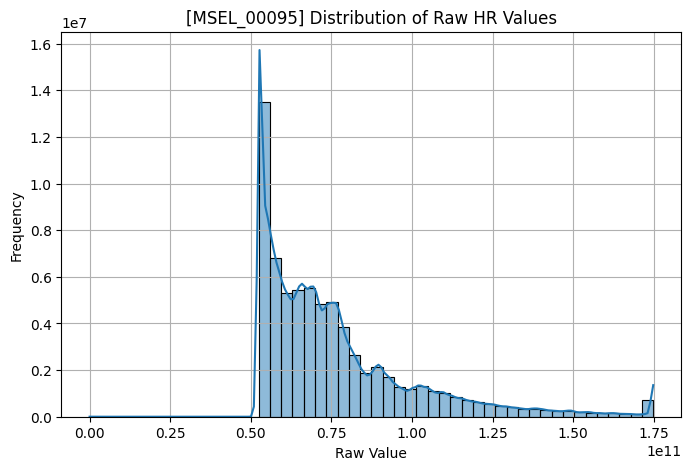

2025-05-14 12:43:56,185 - INFO - [MSEL_00095]   Outlier Check (IQR Method):
2025-05-14 12:43:56,187 - INFO - [MSEL_00095]     Q1: 58000076800.00, Q3: 84706738176.00, IQR: 26706661376.00
2025-05-14 12:43:56,187 - INFO - [MSEL_00095]     Lower Bound: 17940084736.00, Upper Bound: 124766730240.00
2025-05-14 12:43:56,188 - INFO - [MSEL_00095]     Found 4127791 potential outliers in total.
2025-05-14 12:43:56,247 - INFO - [MSEL_00095]     First 30 potential lower outliers (below 17940084736.00):
                                   timestamp   HR
18206082    2018-11-29 11:43:01.015625+00:00  0.0
18206083 2018-11-29 11:43:01.023437500+00:00  0.0
22382188    2018-11-30 00:10:44.843750+00:00  0.0
22382189 2018-11-30 00:10:44.851562500+00:00  0.0
22382190    2018-11-30 00:10:44.859375+00:00  0.0
22383981 2018-11-30 00:10:58.851562500+00:00  0.0
22383982    2018-11-30 00:10:58.859375+00:00  0.0
22436984    2018-11-30 00:17:52.937500+00:00  0.0
22436985 2018-11-30 00:17:52.945312500+00:00  0.0
22436

count    7.100524e+07
mean     2.336114e+09
std      3.614116e+09
min      0.000000e+00
25%      1.255625e+08
50%      6.664790e+08
75%      2.865031e+09
max      2.143866e+10
Name: EDA, dtype: float64


2025-05-14 12:44:00,614 - INFO - [MSEL_00095]   Data Duration:
2025-05-14 12:44:00,615 - INFO - [MSEL_00095]     Start: 2018-11-27 20:12:16+00:00
2025-05-14 12:44:00,616 - INFO - [MSEL_00095]     End: 2018-12-04 18:52:38.617187500+00:00
2025-05-14 12:44:00,618 - INFO - [MSEL_00095]     Total Duration: 6 days 22:40:22.617187500
2025-05-14 12:44:00,618 - INFO - [MSEL_00095]   Distribution of Raw Values:


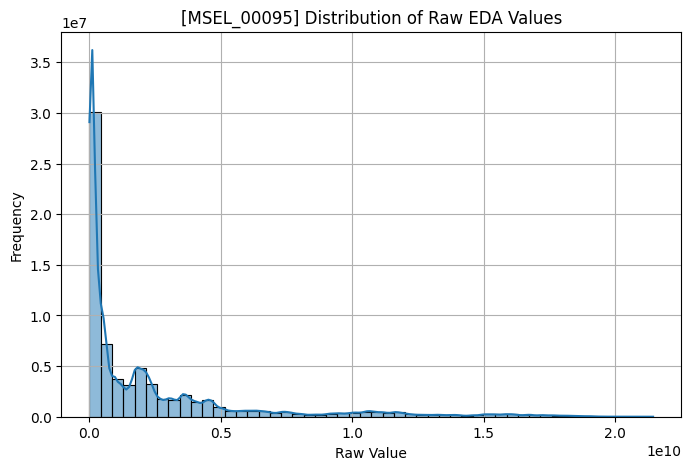

2025-05-14 12:47:29,753 - INFO - [MSEL_00095]   Outlier Check (IQR Method):
2025-05-14 12:47:29,758 - INFO - [MSEL_00095]     Q1: 125562520.00, Q3: 2865030656.00, IQR: 2739468136.00
2025-05-14 12:47:29,759 - INFO - [MSEL_00095]     Lower Bound: -3983639684.00, Upper Bound: 6974232860.00
2025-05-14 12:47:29,759 - INFO - [MSEL_00095]     Found 6950177 potential outliers in total.
2025-05-14 12:47:29,775 - INFO - [MSEL_00095]     First 30 potential upper outliers (above 6974232860.00):
                                  timestamp           EDA
7991922    2018-11-28 13:32:52.890625+00:00  6.975038e+09
7991923 2018-11-28 13:32:52.898437500+00:00  6.977532e+09
7991924    2018-11-28 13:32:52.906250+00:00  6.980025e+09
7991925 2018-11-28 13:32:52.914062500+00:00  6.982518e+09
7991926    2018-11-28 13:32:52.921875+00:00  6.985011e+09
7991927 2018-11-28 13:32:52.929687500+00:00  6.987781e+09
7991928    2018-11-28 13:32:52.937500+00:00  6.990274e+09
7991929 2018-11-28 13:32:52.945312500+00:00  6.9

count    7.098503e+07
mean     3.253392e+10
std      2.431196e+09
min      2.543015e+10
25%      3.106992e+10
50%      3.330980e+10
75%      3.445035e+10
max      3.554999e+10
Name: TEMP, dtype: float64


2025-05-14 12:47:33,663 - INFO - [MSEL_00095]   Data Duration:
2025-05-14 12:47:33,664 - INFO - [MSEL_00095]     Start: 2018-11-27 20:12:16+00:00
2025-05-14 12:47:33,664 - INFO - [MSEL_00095]     End: 2018-12-04 18:52:33.351562500+00:00
2025-05-14 12:47:33,665 - INFO - [MSEL_00095]     Total Duration: 6 days 22:40:17.351562500
2025-05-14 12:47:33,666 - INFO - [MSEL_00095]   Distribution of Raw Values:


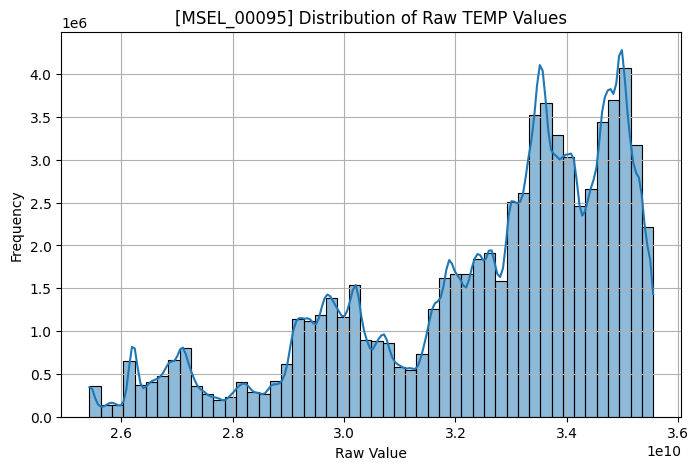

2025-05-14 12:52:25,934 - INFO - [MSEL_00095]   Outlier Check (IQR Method):
2025-05-14 12:52:25,939 - INFO - [MSEL_00095]     Q1: 31069919232.00, Q3: 34450354176.00, IQR: 3380434944.00
2025-05-14 12:52:25,940 - INFO - [MSEL_00095]     Lower Bound: 25999266816.00, Upper Bound: 39521006592.00
2025-05-14 12:52:25,940 - INFO - [MSEL_00095]     Found 612453 potential outliers in total.
2025-05-14 12:52:25,959 - INFO - [MSEL_00095]     First 30 potential lower outliers (below 25999266816.00):
                                 timestamp          TEMP
366533 2018-11-27 20:59:59.539062500+00:00  2.599872e+10
366534    2018-11-27 20:59:59.546875+00:00  2.599749e+10
366535 2018-11-27 20:59:59.554687500+00:00  2.599625e+10
366536    2018-11-27 20:59:59.562500+00:00  2.599502e+10
366537 2018-11-27 20:59:59.570312500+00:00  2.599378e+10
366538    2018-11-27 20:59:59.578125+00:00  2.599255e+10
366539 2018-11-27 20:59:59.585937500+00:00  2.599131e+10
366540    2018-11-27 20:59:59.593750+00:00  2.599008

count    7.101000e+07
mean     6.184841e+10
std      2.670014e+09
min      8.956909e+06
25%      6.115233e+10
50%      6.182246e+10
75%      6.232506e+10
max      2.150971e+11
Name: ACC, dtype: float64


2025-05-14 12:52:30,310 - INFO - [MSEL_00095]   Data Duration:
2025-05-14 12:52:30,311 - INFO - [MSEL_00095]     Start: 2018-11-27 20:12:16+00:00
2025-05-14 12:52:30,311 - INFO - [MSEL_00095]     End: 2018-12-04 18:52:38.617187500+00:00
2025-05-14 12:52:30,313 - INFO - [MSEL_00095]     Total Duration: 6 days 22:40:22.617187500
2025-05-14 12:52:30,313 - INFO - [MSEL_00095]   Distribution of Raw Values:


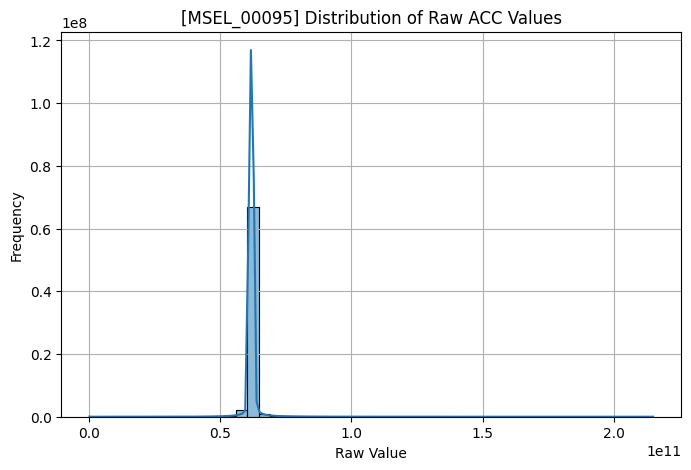

2025-05-14 12:54:10,437 - INFO - [MSEL_00095]   Outlier Check (IQR Method):
2025-05-14 12:54:10,444 - INFO - [MSEL_00095]     Q1: 61152329728.00, Q3: 62325059584.00, IQR: 1172729856.00
2025-05-14 12:54:10,444 - INFO - [MSEL_00095]     Lower Bound: 59393234944.00, Upper Bound: 64084154368.00
2025-05-14 12:54:10,445 - INFO - [MSEL_00095]     Found 3114380 potential outliers in total.
2025-05-14 12:54:10,463 - INFO - [MSEL_00095]     First 30 potential lower outliers (below 59393234944.00):
                               timestamp           ACC
2595 2018-11-27 20:12:36.273437500+00:00  5.917338e+10
2596    2018-11-27 20:12:36.281250+00:00  5.898492e+10
3886    2018-11-27 20:12:46.359375+00:00  5.924146e+10
3887 2018-11-27 20:12:46.367187500+00:00  5.859749e+10
3888    2018-11-27 20:12:46.375000+00:00  5.852944e+10
3889 2018-11-27 20:12:46.382812500+00:00  5.926239e+10
4783 2018-11-27 20:12:53.367187500+00:00  5.901633e+10
4784    2018-11-27 20:12:53.375000+00:00  5.822578e+10
4785 2018-11

count    3.222694e+07
mean     7.233024e+10
std      2.404023e+10
min      0.000000e+00
25%      5.576652e+10
50%      6.688481e+10
75%      8.228044e+10
max      1.935176e+11
Name: HR, dtype: float64


2025-05-14 12:54:12,604 - INFO - [MSEL_00172]   Data Duration:
2025-05-14 12:54:12,605 - INFO - [MSEL_00172]     Start: 2019-04-26 19:42:58+00:00
2025-05-14 12:54:12,606 - INFO - [MSEL_00172]     End: 2019-04-29 17:40:05.992187500+00:00
2025-05-14 12:54:12,607 - INFO - [MSEL_00172]     Total Duration: 2 days 21:57:07.992187500
2025-05-14 12:54:12,608 - INFO - [MSEL_00172]   Distribution of Raw Values:


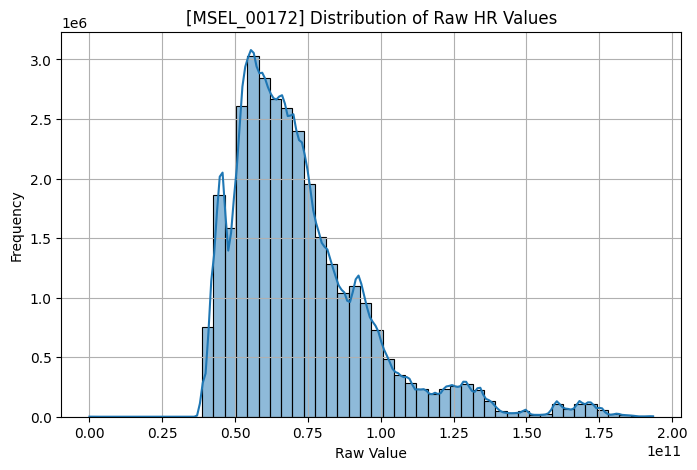

2025-05-14 12:56:00,793 - INFO - [MSEL_00172]   Outlier Check (IQR Method):
2025-05-14 12:56:00,793 - INFO - [MSEL_00172]     Q1: 55766523904.00, Q3: 82280439808.00, IQR: 26513915904.00
2025-05-14 12:56:00,794 - INFO - [MSEL_00172]     Lower Bound: 15995650048.00, Upper Bound: 122051313664.00
2025-05-14 12:56:00,794 - INFO - [MSEL_00172]     Found 1656779 potential outliers in total.
2025-05-14 12:56:00,798 - INFO - [MSEL_00172]     First 30 potential lower outliers (below 15995650048.00):
                                  timestamp   HR
1658757 2019-04-26 23:18:57.039062500+00:00  0.0
1658758    2019-04-26 23:18:57.046875+00:00  0.0
1658759 2019-04-26 23:18:57.054687500+00:00  0.0
1662040    2019-04-26 23:19:22.687500+00:00  0.0
1662041 2019-04-26 23:19:22.695312500+00:00  0.0
3576493 2019-04-27 03:28:39.351562500+00:00  0.0
3576494    2019-04-27 03:28:39.359375+00:00  0.0
3582176    2019-04-27 03:29:23.750000+00:00  0.0
3582177 2019-04-27 03:29:23.757812500+00:00  0.0
3582178    2019

count    3.219710e+07
mean     1.901713e+08
std      1.277877e+08
min      4.255210e+04
25%      8.461997e+07
50%      1.819849e+08
75%      2.769716e+08
max      3.584725e+09
Name: EDA, dtype: float64


2025-05-14 12:56:02,649 - INFO - [MSEL_00172]   Data Duration:
2025-05-14 12:56:02,650 - INFO - [MSEL_00172]     Start: 2019-04-26 19:42:48.007812500+00:00
2025-05-14 12:56:02,651 - INFO - [MSEL_00172]     End: 2019-04-29 17:39:56.125000+00:00
2025-05-14 12:56:02,651 - INFO - [MSEL_00172]     Total Duration: 2 days 21:57:08.117187500
2025-05-14 12:56:02,652 - INFO - [MSEL_00172]   Distribution of Raw Values:


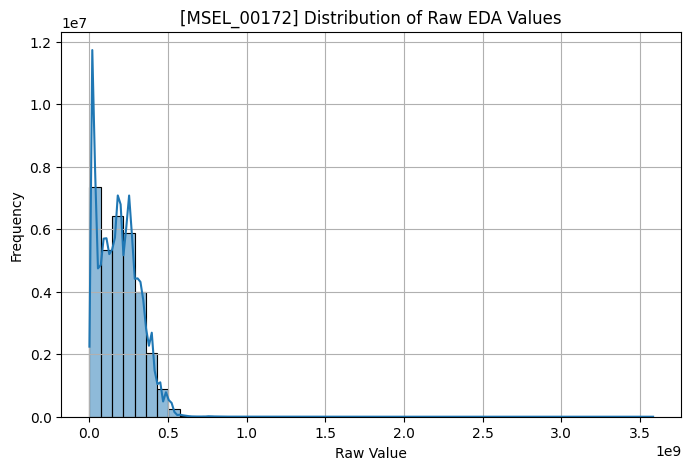

2025-05-14 12:56:57,721 - INFO - [MSEL_00172]   Outlier Check (IQR Method):
2025-05-14 12:56:57,722 - INFO - [MSEL_00172]     Q1: 84619968.00, Q3: 276971648.00, IQR: 192351680.00
2025-05-14 12:56:57,723 - INFO - [MSEL_00172]     Lower Bound: -203907552.00, Upper Bound: 565499168.00
2025-05-14 12:56:57,724 - INFO - [MSEL_00172]     Found 77630 potential outliers in total.
2025-05-14 12:56:57,726 - INFO - [MSEL_00172]     First 30 potential upper outliers (above 565499168.00):
                                 timestamp          EDA
147483    2019-04-26 20:02:00.218750+00:00  567506240.0
147484 2019-04-26 20:02:00.226562500+00:00  571718080.0
147485    2019-04-26 20:02:00.234375+00:00  575984640.0
147486 2019-04-26 20:02:00.242187500+00:00  580196480.0
147487    2019-04-26 20:02:00.250000+00:00  584463040.0
147488 2019-04-26 20:02:00.257812500+00:00  588729600.0
147489    2019-04-26 20:02:00.265625+00:00  592941440.0
147490 2019-04-26 20:02:00.273437500+00:00  597208000.0
147491    2019-0

count    3.213307e+07
mean     3.397166e+10
std      1.113631e+09
min      2.935011e+10
25%      3.317991e+10
50%      3.406992e+10
75%      3.488992e+10
max      3.675000e+10
Name: TEMP, dtype: float64


2025-05-14 12:56:59,311 - INFO - [MSEL_00172]   Data Duration:
2025-05-14 12:56:59,312 - INFO - [MSEL_00172]     Start: 2019-04-26 19:42:48+00:00
2025-05-14 12:56:59,313 - INFO - [MSEL_00172]     End: 2019-04-29 17:39:54.875000+00:00
2025-05-14 12:56:59,313 - INFO - [MSEL_00172]     Total Duration: 2 days 21:57:06.875000
2025-05-14 12:56:59,315 - INFO - [MSEL_00172]   Distribution of Raw Values:


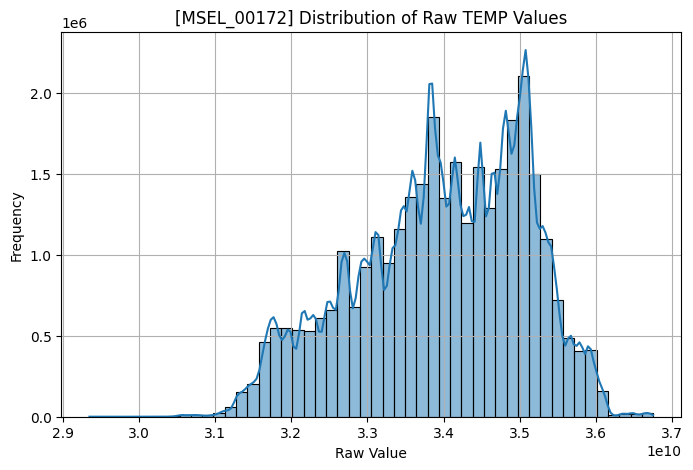

2025-05-14 12:58:57,769 - INFO - [MSEL_00172]   Outlier Check (IQR Method):
2025-05-14 12:58:57,770 - INFO - [MSEL_00172]     Q1: 33179912192.00, Q3: 34889924608.00, IQR: 1710012416.00
2025-05-14 12:58:57,771 - INFO - [MSEL_00172]     Lower Bound: 30614893568.00, Upper Bound: 37454943232.00
2025-05-14 12:58:57,771 - INFO - [MSEL_00172]     Found 9601 potential outliers in total.
2025-05-14 12:58:57,774 - INFO - [MSEL_00172]     First 30 potential lower outliers (below 30614893568.00):
                                   timestamp          TEMP
10529571 2019-04-27 18:37:55.726562500+00:00  3.061377e+10
10529572    2019-04-27 18:37:55.734375+00:00  3.061252e+10
10529573 2019-04-27 18:37:55.742187500+00:00  3.061128e+10
10529574    2019-04-27 18:37:55.750000+00:00  3.061004e+10
10529575 2019-04-27 18:37:55.757812500+00:00  3.060868e+10
10529576    2019-04-27 18:37:55.765625+00:00  3.060744e+10
10529577 2019-04-27 18:37:55.773437500+00:00  3.060620e+10
10529578    2019-04-27 18:37:55.781250

count    3.222700e+07
mean     6.258065e+10
std      1.624579e+09
min      6.118774e+06
25%      6.190637e+10
50%      6.268307e+10
75%      6.320404e+10
max      1.823727e+11
Name: ACC, dtype: float64


2025-05-14 12:58:59,688 - INFO - [MSEL_00172]   Data Duration:
2025-05-14 12:58:59,689 - INFO - [MSEL_00172]     Start: 2019-04-26 19:42:48+00:00
2025-05-14 12:58:59,690 - INFO - [MSEL_00172]     End: 2019-04-29 17:40:02.554687500+00:00
2025-05-14 12:58:59,690 - INFO - [MSEL_00172]     Total Duration: 2 days 21:57:14.554687500
2025-05-14 12:58:59,691 - INFO - [MSEL_00172]   Distribution of Raw Values:


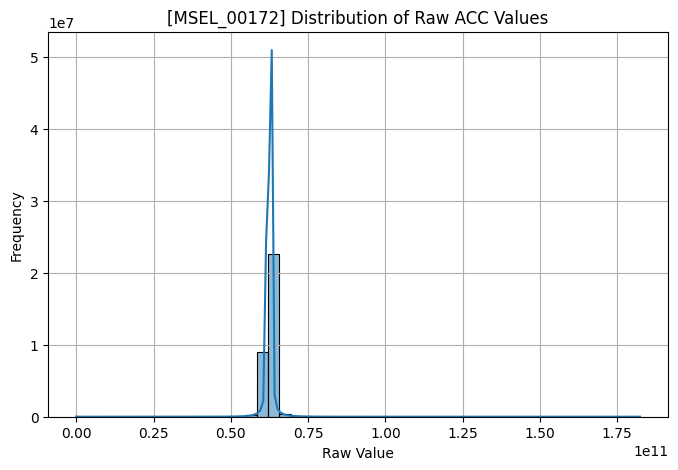

2025-05-14 12:59:43,274 - INFO - [MSEL_00172]   Outlier Check (IQR Method):
2025-05-14 12:59:43,275 - INFO - [MSEL_00172]     Q1: 61906370560.00, Q3: 63204040704.00, IQR: 1297670144.00
2025-05-14 12:59:43,275 - INFO - [MSEL_00172]     Lower Bound: 59959865344.00, Upper Bound: 65150545920.00
2025-05-14 12:59:43,276 - INFO - [MSEL_00172]     Found 1229471 potential outliers in total.
2025-05-14 12:59:43,278 - INFO - [MSEL_00172]     First 30 potential lower outliers (below 59959865344.00):
                                timestamp           ACC
14910    2019-04-26 19:44:44.484375+00:00  5.991722e+10
14911 2019-04-26 19:44:44.492187500+00:00  5.972778e+10
14934    2019-04-26 19:44:44.671875+00:00  5.969936e+10
14935 2019-04-26 19:44:44.679687500+00:00  5.900789e+10
14936    2019-04-26 19:44:44.687500+00:00  5.900789e+10
14937 2019-04-26 19:44:44.695312500+00:00  5.900789e+10
14938    2019-04-26 19:44:44.703125+00:00  5.900789e+10
14939 2019-04-26 19:44:44.710937500+00:00  5.973251e+10
150

count    3.893274e+07
mean     8.367456e+10
std      1.620308e+10
min      0.000000e+00
25%      7.092607e+10
50%      8.093685e+10
75%      9.383558e+10
max      1.696995e+11
Name: HR, dtype: float64


2025-05-14 12:59:45,474 - INFO - [MSEL_00182]   Data Duration:
2025-05-14 12:59:45,476 - INFO - [MSEL_00182]     Start: 2019-07-25 19:07:43+00:00
2025-05-14 12:59:45,476 - INFO - [MSEL_00182]     End: 2019-07-29 08:22:33.992187500+00:00
2025-05-14 12:59:45,477 - INFO - [MSEL_00182]     Total Duration: 3 days 13:14:50.992187500
2025-05-14 12:59:45,477 - INFO - [MSEL_00182]   Distribution of Raw Values:


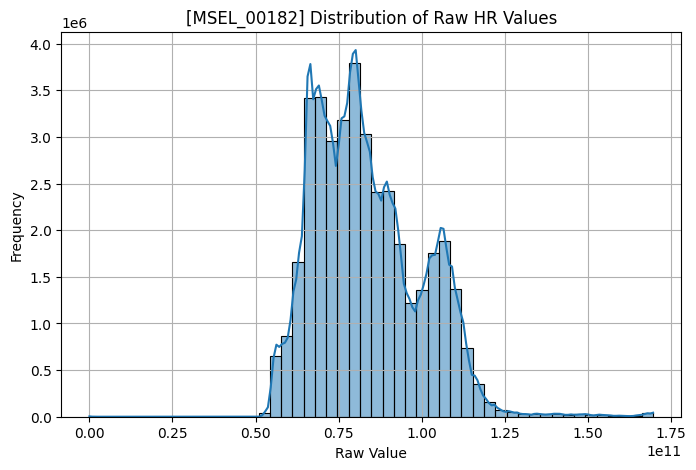

2025-05-14 13:01:33,043 - INFO - [MSEL_00182]   Outlier Check (IQR Method):
2025-05-14 13:01:33,044 - INFO - [MSEL_00182]     Q1: 70926065664.00, Q3: 93835575296.00, IQR: 22909509632.00
2025-05-14 13:01:33,045 - INFO - [MSEL_00182]     Lower Bound: 36561801216.00, Upper Bound: 128199839744.00
2025-05-14 13:01:33,045 - INFO - [MSEL_00182]     Found 282824 potential outliers in total.
2025-05-14 13:01:33,048 - INFO - [MSEL_00182]     First 30 potential lower outliers (below 36561801216.00):
                                 timestamp   HR
81643  2019-07-25 19:18:20.835937500+00:00  0.0
81644     2019-07-25 19:18:20.843750+00:00  0.0
81645  2019-07-25 19:18:20.851562500+00:00  0.0
86620     2019-07-25 19:18:59.718750+00:00  0.0
86621  2019-07-25 19:18:59.726562500+00:00  0.0
430466    2019-07-25 20:03:46.015625+00:00  0.0
430467 2019-07-25 20:03:46.023437500+00:00  0.0
430468    2019-07-25 20:03:46.031250+00:00  0.0
431410    2019-07-25 20:03:53.390625+00:00  0.0
431411 2019-07-25 20:03:53

count    3.823758e+07
mean     7.527802e+08
std      1.451578e+09
min      2.401961e+05
25%      3.096948e+08
50%      4.054510e+08
75%      5.281911e+08
max      2.382142e+10
Name: EDA, dtype: float64


2025-05-14 13:01:35,233 - INFO - [MSEL_00182]   Data Duration:
2025-05-14 13:01:35,234 - INFO - [MSEL_00182]     Start: 2019-07-25 19:07:46.750000+00:00
2025-05-14 13:01:35,235 - INFO - [MSEL_00182]     End: 2019-07-29 08:22:18.296875+00:00
2025-05-14 13:01:35,235 - INFO - [MSEL_00182]     Total Duration: 3 days 13:14:31.546875
2025-05-14 13:01:35,236 - INFO - [MSEL_00182]   Distribution of Raw Values:


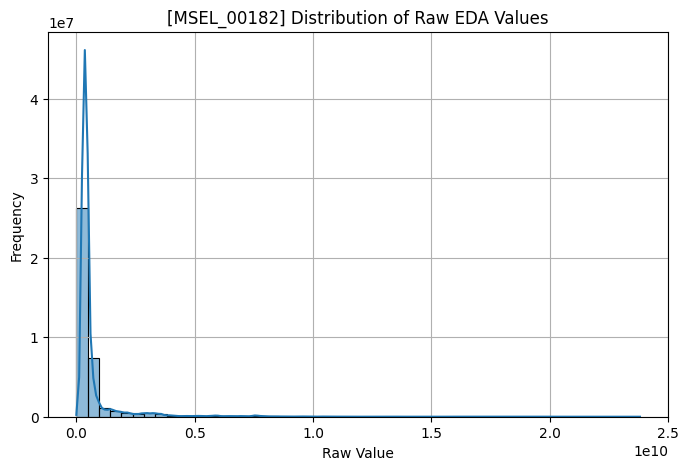

2025-05-14 13:02:48,187 - INFO - [MSEL_00182]   Outlier Check (IQR Method):
2025-05-14 13:02:48,188 - INFO - [MSEL_00182]     Q1: 309694816.00, Q3: 528191136.00, IQR: 218496320.00
2025-05-14 13:02:48,189 - INFO - [MSEL_00182]     Lower Bound: -18049664.00, Upper Bound: 855935616.00
2025-05-14 13:02:48,189 - INFO - [MSEL_00182]     Found 4941080 potential outliers in total.
2025-05-14 13:02:48,193 - INFO - [MSEL_00182]     First 30 potential upper outliers (above 855935616.00):
                             timestamp           EDA
67 2019-07-25 19:07:47.273437500+00:00  8.661471e+08
68    2019-07-25 19:07:47.281250+00:00  8.771961e+08
69 2019-07-25 19:07:47.289062500+00:00  8.880049e+08
70    2019-07-25 19:07:47.296875+00:00  8.988137e+08
71 2019-07-25 19:07:47.304687500+00:00  9.098628e+08
72    2019-07-25 19:07:47.312500+00:00  9.206716e+08
73 2019-07-25 19:07:47.320312500+00:00  9.314804e+08
74    2019-07-25 19:07:47.328125+00:00  9.425294e+08
75 2019-07-25 19:07:47.335937500+00:00  9

count    3.892078e+07
mean     3.473391e+10
std      1.460990e+09
min      2.351142e+10
25%      3.390990e+10
50%      3.504973e+10
75%      3.583975e+10
max      3.682999e+10
Name: TEMP, dtype: float64


2025-05-14 13:02:50,451 - INFO - [MSEL_00182]   Data Duration:
2025-05-14 13:02:50,452 - INFO - [MSEL_00182]     Start: 2019-07-25 19:07:33+00:00
2025-05-14 13:02:50,453 - INFO - [MSEL_00182]     End: 2019-07-29 08:22:17.796875+00:00
2025-05-14 13:02:50,453 - INFO - [MSEL_00182]     Total Duration: 3 days 13:14:44.796875
2025-05-14 13:02:50,454 - INFO - [MSEL_00182]   Distribution of Raw Values:


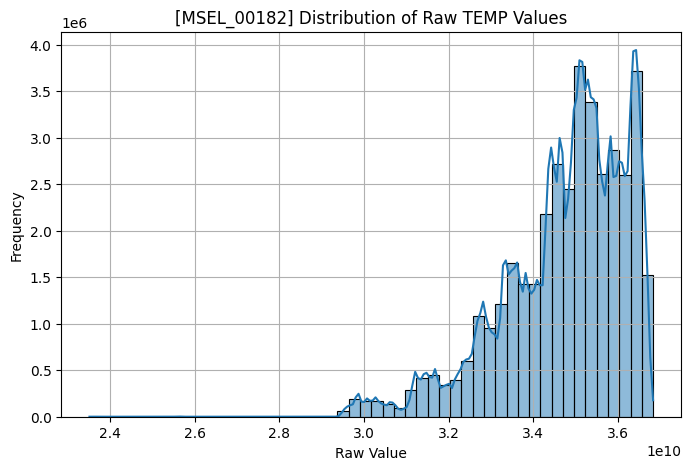

2025-05-14 13:04:42,030 - INFO - [MSEL_00182]   Outlier Check (IQR Method):
2025-05-14 13:04:42,031 - INFO - [MSEL_00182]     Q1: 33909897216.00, Q3: 35839754240.00, IQR: 1929857024.00
2025-05-14 13:04:42,032 - INFO - [MSEL_00182]     Lower Bound: 31015111680.00, Upper Bound: 38734539776.00
2025-05-14 13:04:42,033 - INFO - [MSEL_00182]     Found 837874 potential outliers in total.
2025-05-14 13:04:42,036 - INFO - [MSEL_00182]     First 30 potential lower outliers (below 31015111680.00):
                             timestamp          TEMP
0            2019-07-25 19:07:33+00:00  2.479027e+10
1  2019-07-25 19:07:33.007812500+00:00  2.479027e+10
2     2019-07-25 19:07:33.015625+00:00  2.479027e+10
3  2019-07-25 19:07:33.023437500+00:00  2.479027e+10
4     2019-07-25 19:07:33.031250+00:00  2.479027e+10
5  2019-07-25 19:07:33.039062500+00:00  2.479027e+10
6     2019-07-25 19:07:33.046875+00:00  2.479027e+10
7  2019-07-25 19:07:33.054687500+00:00  2.479027e+10
8     2019-07-25 19:07:33.06250

count    3.893200e+07
mean     6.235817e+10
std      1.461742e+09
min      7.019043e+06
25%      6.194092e+10
50%      6.240912e+10
75%      6.278687e+10
max      2.206622e+11
Name: ACC, dtype: float64


2025-05-14 13:04:44,449 - INFO - [MSEL_00182]   Data Duration:
2025-05-14 13:04:44,450 - INFO - [MSEL_00182]     Start: 2019-07-25 19:07:33+00:00
2025-05-14 13:04:44,451 - INFO - [MSEL_00182]     End: 2019-07-29 08:22:23.617187500+00:00
2025-05-14 13:04:44,452 - INFO - [MSEL_00182]     Total Duration: 3 days 13:14:50.617187500
2025-05-14 13:04:44,453 - INFO - [MSEL_00182]   Distribution of Raw Values:


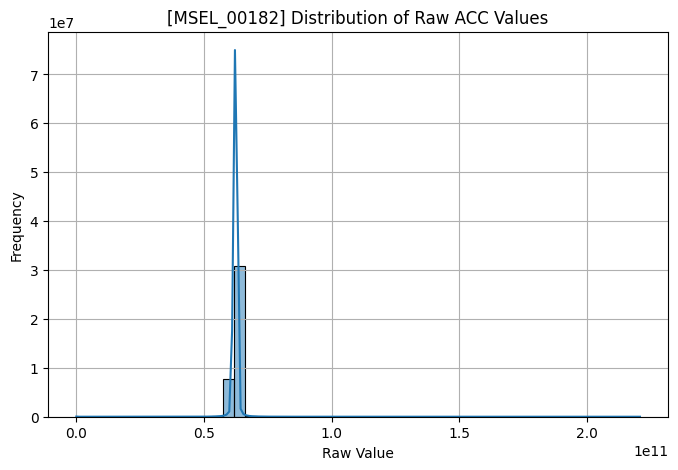

2025-05-14 13:05:35,461 - INFO - [MSEL_00182]   Outlier Check (IQR Method):
2025-05-14 13:05:35,462 - INFO - [MSEL_00182]     Q1: 61940916224.00, Q3: 62786867200.00, IQR: 845950976.00
2025-05-14 13:05:35,463 - INFO - [MSEL_00182]     Lower Bound: 60671989760.00, Upper Bound: 64055793664.00
2025-05-14 13:05:35,463 - INFO - [MSEL_00182]     Found 1411396 potential outliers in total.
2025-05-14 13:05:35,466 - INFO - [MSEL_00182]     First 30 potential lower outliers (below 60671989760.00):
                              timestamp           ACC
0             2019-07-25 19:07:33+00:00  5.739205e+10
1   2019-07-25 19:07:33.007812500+00:00  5.824863e+10
2      2019-07-25 19:07:33.015625+00:00  5.911583e+10
3   2019-07-25 19:07:33.023437500+00:00  5.999901e+10
59  2019-07-25 19:07:33.460937500+00:00  5.897751e+10
60     2019-07-25 19:07:33.468750+00:00  5.033730e+10
61  2019-07-25 19:07:33.476562500+00:00  3.988818e+10
62     2019-07-25 19:07:33.484375+00:00  3.580749e+10
63  2019-07-25 19:07:3

count    3.477527e+07
mean     8.464539e+10
std      1.851177e+10
min      0.000000e+00
25%      7.270893e+10
50%      8.083689e+10
75%      8.987632e+10
max      1.772299e+11
Name: HR, dtype: float64


2025-05-14 13:05:37,610 - INFO - [MSEL_00501]   Data Duration:
2025-05-14 13:05:37,611 - INFO - [MSEL_00501]     Start: 2019-05-02 20:49:04+00:00
2025-05-14 13:05:37,611 - INFO - [MSEL_00501]     End: 2019-05-06 02:55:23.992187500+00:00
2025-05-14 13:05:37,612 - INFO - [MSEL_00501]     Total Duration: 3 days 06:06:19.992187500
2025-05-14 13:05:37,612 - INFO - [MSEL_00501]   Distribution of Raw Values:


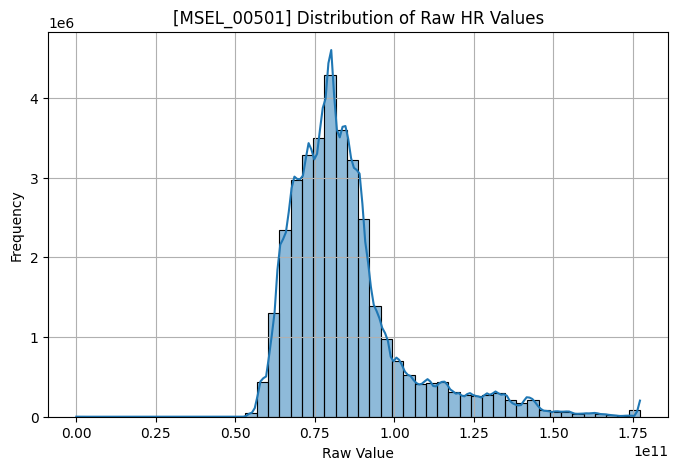

2025-05-14 13:07:20,791 - INFO - [MSEL_00501]   Outlier Check (IQR Method):
2025-05-14 13:07:20,792 - INFO - [MSEL_00501]     Q1: 72708931584.00, Q3: 89876324352.00, IQR: 17167392768.00
2025-05-14 13:07:20,794 - INFO - [MSEL_00501]     Lower Bound: 46957842432.00, Upper Bound: 115627413504.00
2025-05-14 13:07:20,794 - INFO - [MSEL_00501]     Found 2613431 potential outliers in total.
2025-05-14 13:07:20,798 - INFO - [MSEL_00501]     First 30 potential lower outliers (below 46957842432.00):
                                   timestamp   HR
2992660     2019-05-03 03:18:44.156250+00:00  0.0
2992661  2019-05-03 03:18:44.164062500+00:00  0.0
2992662     2019-05-03 03:18:44.171875+00:00  0.0
2992969  2019-05-03 03:18:46.570312500+00:00  0.0
2992970     2019-05-03 03:18:46.578125+00:00  0.0
2996001  2019-05-03 03:19:10.257812500+00:00  0.0
2996002     2019-05-03 03:19:10.265625+00:00  0.0
2996003  2019-05-03 03:19:10.273437500+00:00  0.0
4444054     2019-05-03 06:27:43.171875+00:00  0.0
44440

count    3.477474e+07
mean     1.536789e+09
std      2.606645e+09
min      0.000000e+00
25%      1.870457e+08
50%      3.636613e+08
75%      1.590236e+09
max      2.278446e+10
Name: EDA, dtype: float64


2025-05-14 13:07:23,145 - INFO - [MSEL_00501]   Data Duration:
2025-05-14 13:07:23,147 - INFO - [MSEL_00501]     Start: 2019-05-02 20:48:54.007812500+00:00
2025-05-14 13:07:23,147 - INFO - [MSEL_00501]     End: 2019-05-06 02:55:17.367187500+00:00
2025-05-14 13:07:23,149 - INFO - [MSEL_00501]     Total Duration: 3 days 06:06:23.359375
2025-05-14 13:07:23,150 - INFO - [MSEL_00501]   Distribution of Raw Values:


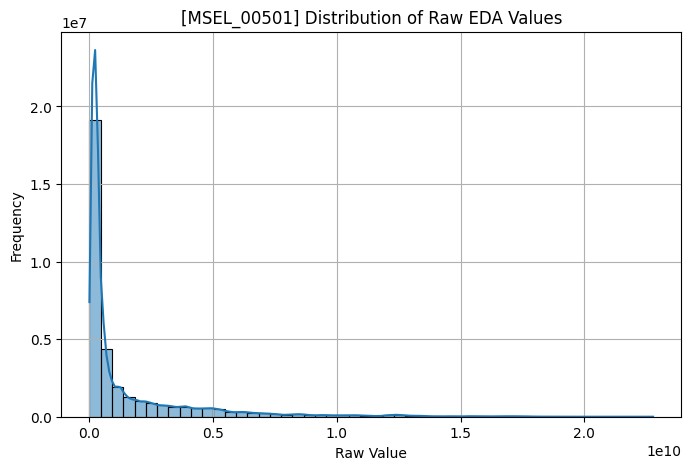

2025-05-14 13:08:50,981 - INFO - [MSEL_00501]   Outlier Check (IQR Method):
2025-05-14 13:08:50,985 - INFO - [MSEL_00501]     Q1: 187045696.00, Q3: 1590236032.00, IQR: 1403190336.00
2025-05-14 13:08:50,986 - INFO - [MSEL_00501]     Lower Bound: -1917739808.00, Upper Bound: 3695021536.00
2025-05-14 13:08:50,986 - INFO - [MSEL_00501]     Found 4770834 potential outliers in total.
2025-05-14 13:08:50,990 - INFO - [MSEL_00501]     First 30 potential upper outliers (above 3695021536.00):
                                  timestamp           EDA
4402750 2019-05-03 06:22:10.992187500+00:00  3.702670e+09
4402751           2019-05-03 06:22:11+00:00  3.711014e+09
4402752 2019-05-03 06:22:11.007812500+00:00  3.719011e+09
4402753    2019-05-03 06:22:11.015625+00:00  3.727355e+09
4402754 2019-05-03 06:22:11.023437500+00:00  3.735351e+09
4402755    2019-05-03 06:22:11.031250+00:00  3.743695e+09
4402756 2019-05-03 06:22:11.039062500+00:00  3.751692e+09
4402757    2019-05-03 06:22:11.046875+00:00  3.7

count    3.477112e+07
mean     3.452468e+10
std      1.495367e+09
min      3.105010e+10
25%      3.334003e+10
50%      3.478984e+10
75%      3.570992e+10
max      3.764999e+10
Name: TEMP, dtype: float64


2025-05-14 13:08:53,130 - INFO - [MSEL_00501]   Data Duration:
2025-05-14 13:08:53,132 - INFO - [MSEL_00501]     Start: 2019-05-02 20:48:54+00:00
2025-05-14 13:08:53,132 - INFO - [MSEL_00501]     End: 2019-05-06 02:55:09.515625+00:00
2025-05-14 13:08:53,133 - INFO - [MSEL_00501]     Total Duration: 3 days 06:06:15.515625
2025-05-14 13:08:53,133 - INFO - [MSEL_00501]   Distribution of Raw Values:


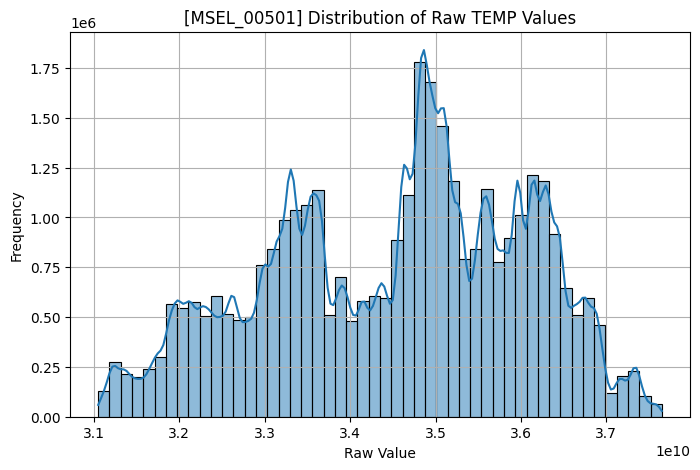

2025-05-14 13:11:33,942 - INFO - [MSEL_00501]   Outlier Check (IQR Method):
2025-05-14 13:11:33,944 - INFO - [MSEL_00501]     Q1: 33340030976.00, Q3: 35709923328.00, IQR: 2369892352.00
2025-05-14 13:11:33,945 - INFO - [MSEL_00501]     Lower Bound: 29785192448.00, Upper Bound: 39264761856.00
2025-05-14 13:11:33,946 - INFO - [MSEL_00501]     Found 0 potential outliers in total.
2025-05-14 13:11:33,946 - INFO - [MSEL_00501]     No potential outliers found using IQR method.
2025-05-14 13:11:33,947 - INFO - --------------------------------------------------------------------------------
2025-05-14 13:11:33,948 - INFO - 

2025-05-14 13:11:33,948 - INFO - 
[MSEL_00501] Sensor: ACC
2025-05-14 13:11:33,949 - INFO - [MSEL_00501]   Descriptive Statistics:


count    3.477500e+07
mean     6.258301e+10
std      2.229796e+09
min      7.354736e+06
25%      6.167952e+10
50%      6.259520e+10
75%      6.337323e+10
max      2.188663e+11
Name: ACC, dtype: float64


2025-05-14 13:11:35,844 - INFO - [MSEL_00501]   Data Duration:
2025-05-14 13:11:35,844 - INFO - [MSEL_00501]     Start: 2019-05-02 20:48:54+00:00
2025-05-14 13:11:35,846 - INFO - [MSEL_00501]     End: 2019-05-06 02:55:09.554687500+00:00
2025-05-14 13:11:35,846 - INFO - [MSEL_00501]     Total Duration: 3 days 06:06:15.554687500
2025-05-14 13:11:35,847 - INFO - [MSEL_00501]   Distribution of Raw Values:


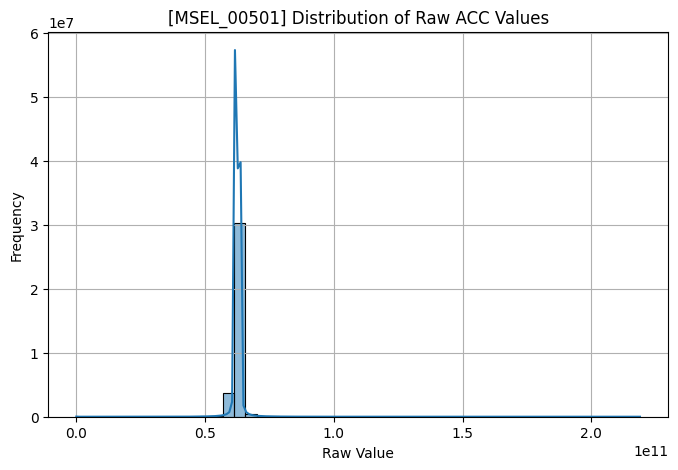

2025-05-14 13:12:24,961 - INFO - [MSEL_00501]   Outlier Check (IQR Method):
2025-05-14 13:12:24,962 - INFO - [MSEL_00501]     Q1: 61679517696.00, Q3: 63373230080.00, IQR: 1693712384.00
2025-05-14 13:12:24,963 - INFO - [MSEL_00501]     Lower Bound: 59138949120.00, Upper Bound: 65913798656.00
2025-05-14 13:12:24,963 - INFO - [MSEL_00501]     Found 928243 potential outliers in total.
2025-05-14 13:12:24,966 - INFO - [MSEL_00501]     First 30 potential lower outliers (below 59138949120.00):
                                timestamp           ACC
2143  2019-05-02 20:49:10.742187500+00:00  5.819682e+10
2144     2019-05-02 20:49:10.750000+00:00  5.746114e+10
46195 2019-05-02 20:54:54.898437500+00:00  5.808568e+10
46375 2019-05-02 20:54:56.304687500+00:00  5.772577e+10
46423 2019-05-02 20:54:56.679687500+00:00  5.754053e+10
46470    2019-05-02 20:54:57.046875+00:00  5.578331e+10
46471 2019-05-02 20:54:57.054687500+00:00  5.198834e+10
46472    2019-05-02 20:54:57.062500+00:00  5.067042e+10
4647

count    2.218112e+07
mean     6.458846e+10
std      1.159569e+10
min      0.000000e+00
25%      5.659510e+10
50%      6.125646e+10
75%      6.953269e+10
max      1.648999e+11
Name: HR, dtype: float64


2025-05-14 13:12:26,110 - INFO - [MSEL_00502]   Data Duration:
2025-05-14 13:12:26,110 - INFO - [MSEL_00502]     Start: 2019-03-02 13:23:58+00:00
2025-05-14 13:12:26,111 - INFO - [MSEL_00502]     End: 2019-03-04 13:32:07.992187500+00:00
2025-05-14 13:12:26,112 - INFO - [MSEL_00502]     Total Duration: 2 days 00:08:09.992187500
2025-05-14 13:12:26,112 - INFO - [MSEL_00502]   Distribution of Raw Values:


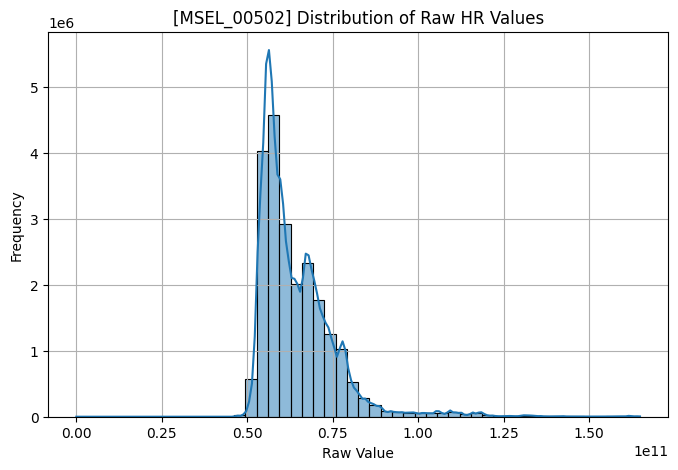

2025-05-14 13:13:23,293 - INFO - [MSEL_00502]   Outlier Check (IQR Method):
2025-05-14 13:13:23,294 - INFO - [MSEL_00502]     Q1: 56595099648.00, Q3: 69532688384.00, IQR: 12937588736.00
2025-05-14 13:13:23,294 - INFO - [MSEL_00502]     Lower Bound: 37188716544.00, Upper Bound: 88939071488.00
2025-05-14 13:13:23,295 - INFO - [MSEL_00502]     Found 695048 potential outliers in total.
2025-05-14 13:13:23,298 - INFO - [MSEL_00502]     First 30 potential lower outliers (below 37188716544.00):
                                   timestamp   HR
15612423 2019-03-03 23:16:50.054687500+00:00  0.0
15612424    2019-03-03 23:16:50.062500+00:00  0.0
15641584    2019-03-03 23:20:37.875000+00:00  0.0
15641585 2019-03-03 23:20:37.882812500+00:00  0.0
15671331 2019-03-03 23:24:30.273437500+00:00  0.0
15671332    2019-03-03 23:24:30.281250+00:00  0.0
15671333 2019-03-03 23:24:30.289062500+00:00  0.0
15687086    2019-03-03 23:26:33.359375+00:00  0.0
15687087 2019-03-03 23:26:33.367187500+00:00  0.0
1679337

count    2.218100e+07
mean     3.681898e+09
std      5.439681e+09
min      0.000000e+00
25%      5.927130e+08
50%      1.371472e+09
75%      4.108928e+09
max      3.596615e+10
Name: EDA, dtype: float64


2025-05-14 13:13:24,468 - INFO - [MSEL_00502]   Data Duration:
2025-05-14 13:13:24,469 - INFO - [MSEL_00502]     Start: 2019-03-02 13:23:48+00:00
2025-05-14 13:13:24,470 - INFO - [MSEL_00502]     End: 2019-03-04 13:31:57.054687500+00:00
2025-05-14 13:13:24,470 - INFO - [MSEL_00502]     Total Duration: 2 days 00:08:09.054687500
2025-05-14 13:13:24,471 - INFO - [MSEL_00502]   Distribution of Raw Values:


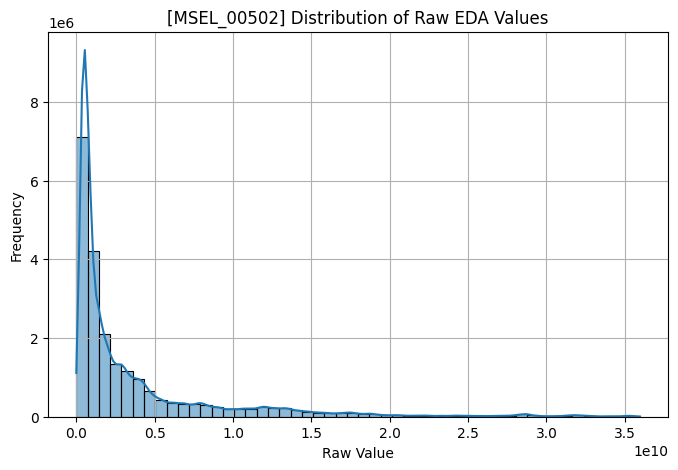

2025-05-14 13:14:31,340 - INFO - [MSEL_00502]   Outlier Check (IQR Method):
2025-05-14 13:14:31,341 - INFO - [MSEL_00502]     Q1: 592712960.00, Q3: 4108927744.00, IQR: 3516214784.00
2025-05-14 13:14:31,342 - INFO - [MSEL_00502]     Lower Bound: -4681609216.00, Upper Bound: 9383249920.00
2025-05-14 13:14:31,342 - INFO - [MSEL_00502]     Found 2624562 potential outliers in total.
2025-05-14 13:14:31,345 - INFO - [MSEL_00502]     First 30 potential upper outliers (above 9383249920.00):
                                  timestamp           EDA
2203260    2019-03-02 18:10:40.968750+00:00  9.385720e+09
2203261 2019-03-02 18:10:40.976562500+00:00  9.389012e+09
2203262    2019-03-02 18:10:40.984375+00:00  9.392304e+09
2203263 2019-03-02 18:10:40.992187500+00:00  9.395597e+09
2203264           2019-03-02 18:10:41+00:00  9.398890e+09
2203265 2019-03-02 18:10:41.007812500+00:00  9.402732e+09
2203266    2019-03-02 18:10:41.015625+00:00  9.406025e+09
2203267 2019-03-02 18:10:41.023437500+00:00  9.4

count    2.218008e+07
mean     3.352220e+10
std      1.568236e+09
min      2.575034e+10
25%      3.272986e+10
50%      3.372637e+10
75%      3.456992e+10
max      3.700000e+10
Name: TEMP, dtype: float64


2025-05-14 13:14:32,486 - INFO - [MSEL_00502]   Data Duration:
2025-05-14 13:14:32,487 - INFO - [MSEL_00502]     Start: 2019-03-02 13:23:48+00:00
2025-05-14 13:14:32,487 - INFO - [MSEL_00502]     End: 2019-03-04 13:31:49.906250+00:00
2025-05-14 13:14:32,488 - INFO - [MSEL_00502]     Total Duration: 2 days 00:08:01.906250
2025-05-14 13:14:32,488 - INFO - [MSEL_00502]   Distribution of Raw Values:


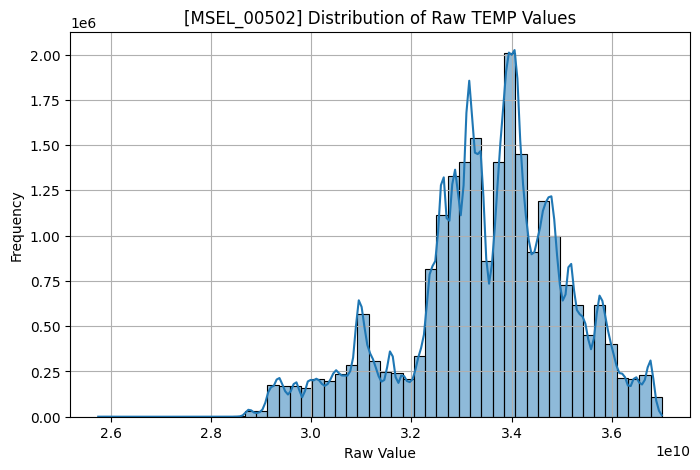

2025-05-14 13:15:52,609 - INFO - [MSEL_00502]   Outlier Check (IQR Method):
2025-05-14 13:15:52,610 - INFO - [MSEL_00502]     Q1: 32729858048.00, Q3: 34569924608.00, IQR: 1840066560.00
2025-05-14 13:15:52,610 - INFO - [MSEL_00502]     Lower Bound: 29969758208.00, Upper Bound: 37330024448.00
2025-05-14 13:15:52,611 - INFO - [MSEL_00502]     Found 686954 potential outliers in total.
2025-05-14 13:15:52,614 - INFO - [MSEL_00502]     First 30 potential lower outliers (below 29969758208.00):
                             timestamp          TEMP
0            2019-03-02 13:23:48+00:00  2.919032e+10
1  2019-03-02 13:23:48.007812500+00:00  2.919032e+10
2     2019-03-02 13:23:48.015625+00:00  2.919032e+10
3  2019-03-02 13:23:48.023437500+00:00  2.919032e+10
4     2019-03-02 13:23:48.031250+00:00  2.919032e+10
5  2019-03-02 13:23:48.039062500+00:00  2.919032e+10
6     2019-03-02 13:23:48.046875+00:00  2.919032e+10
7  2019-03-02 13:23:48.054687500+00:00  2.919032e+10
8     2019-03-02 13:23:48.06250

count    2.218100e+07
mean     6.143465e+10
std      1.261085e+09
min      6.515503e+06
25%      6.109430e+10
50%      6.139987e+10
75%      6.167769e+10
max      1.783853e+11
Name: ACC, dtype: float64


2025-05-14 13:15:53,823 - INFO - [MSEL_00502]   Data Duration:
2025-05-14 13:15:53,824 - INFO - [MSEL_00502]     Start: 2019-03-02 13:23:48+00:00
2025-05-14 13:15:53,824 - INFO - [MSEL_00502]     End: 2019-03-04 13:31:57.054687500+00:00
2025-05-14 13:15:53,825 - INFO - [MSEL_00502]     Total Duration: 2 days 00:08:09.054687500
2025-05-14 13:15:53,825 - INFO - [MSEL_00502]   Distribution of Raw Values:


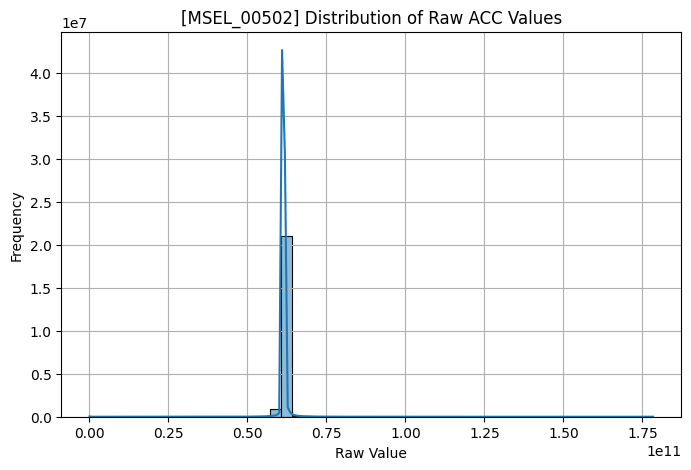

2025-05-14 13:16:23,954 - INFO - [MSEL_00502]   Outlier Check (IQR Method):
2025-05-14 13:16:23,954 - INFO - [MSEL_00502]     Q1: 61094297600.00, Q3: 61677686784.00, IQR: 583389184.00
2025-05-14 13:16:23,955 - INFO - [MSEL_00502]     Lower Bound: 60219213824.00, Upper Bound: 62552770560.00
2025-05-14 13:16:23,955 - INFO - [MSEL_00502]     Found 730615 potential outliers in total.
2025-05-14 13:16:23,958 - INFO - [MSEL_00502]     First 30 potential lower outliers (below 60219213824.00):
                              timestamp           ACC
36     2019-03-02 13:23:48.281250+00:00  6.020071e+10
64     2019-03-02 13:23:48.500000+00:00  6.001552e+10
65  2019-03-02 13:23:48.507812500+00:00  5.996458e+10
66     2019-03-02 13:23:48.515625+00:00  5.991829e+10
67  2019-03-02 13:23:48.523437500+00:00  5.987662e+10
68     2019-03-02 13:23:48.531250+00:00  5.983496e+10
69  2019-03-02 13:23:48.539062500+00:00  6.016830e+10
122    2019-03-02 13:23:48.953125+00:00  5.992293e+10
123 2019-03-02 13:23:48

count    3.070939e+07
mean     8.134207e+10
std      1.340526e+10
min      0.000000e+00
25%      7.176338e+10
50%      7.978265e+10
75%      8.865936e+10
max      1.702278e+11
Name: HR, dtype: float64


2025-05-14 13:16:25,493 - INFO - [MSEL_00764]   Data Duration:
2025-05-14 13:16:25,494 - INFO - [MSEL_00764]     Start: 2019-09-23 16:00:47+00:00
2025-05-14 13:16:25,495 - INFO - [MSEL_00764]     End: 2019-09-26 13:08:38.054687500+00:00
2025-05-14 13:16:25,495 - INFO - [MSEL_00764]     Total Duration: 2 days 21:07:51.054687500
2025-05-14 13:16:25,495 - INFO - [MSEL_00764]   Distribution of Raw Values:


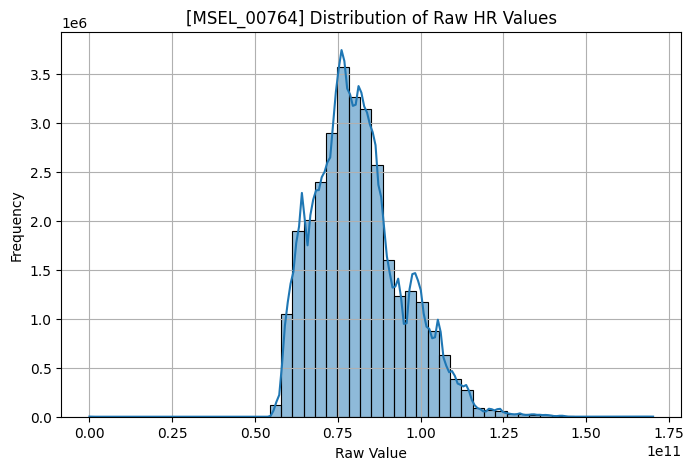

2025-05-14 13:17:43,310 - INFO - [MSEL_00764]   Outlier Check (IQR Method):
2025-05-14 13:17:43,311 - INFO - [MSEL_00764]     Q1: 71763378176.00, Q3: 88659361792.00, IQR: 16895983616.00
2025-05-14 13:17:43,312 - INFO - [MSEL_00764]     Lower Bound: 46419402752.00, Upper Bound: 114003337216.00
2025-05-14 13:17:43,312 - INFO - [MSEL_00764]     Found 449820 potential outliers in total.
2025-05-14 13:17:43,314 - INFO - [MSEL_00764]     First 30 potential lower outliers (below 46419402752.00):
                                   timestamp   HR
2931     2019-09-23 16:01:09.898437500+00:00  0.0
2932        2019-09-23 16:01:09.906250+00:00  0.0
2933     2019-09-23 16:01:09.914062500+00:00  0.0
4785     2019-09-23 16:01:24.382812500+00:00  0.0
4786        2019-09-23 16:01:24.390625+00:00  0.0
4787     2019-09-23 16:01:24.398437500+00:00  0.0
4788        2019-09-23 16:01:24.406250+00:00  0.0
4789     2019-09-23 16:01:24.414062500+00:00  0.0
4790        2019-09-23 16:01:24.421875+00:00  0.0
4791  

count    3.066775e+07
mean     1.706240e+09
std      1.589373e+09
min      0.000000e+00
25%      8.310497e+08
50%      1.338373e+09
75%      2.099293e+09
max      3.569725e+10
Name: EDA, dtype: float64


2025-05-14 13:17:44,990 - INFO - [MSEL_00764]   Data Duration:
2025-05-14 13:17:44,991 - INFO - [MSEL_00764]     Start: 2019-09-23 16:02:20.242187500+00:00
2025-05-14 13:17:44,992 - INFO - [MSEL_00764]     End: 2019-09-26 13:08:25.312500+00:00
2025-05-14 13:17:44,992 - INFO - [MSEL_00764]     Total Duration: 2 days 21:06:05.070312500
2025-05-14 13:17:44,992 - INFO - [MSEL_00764]   Distribution of Raw Values:


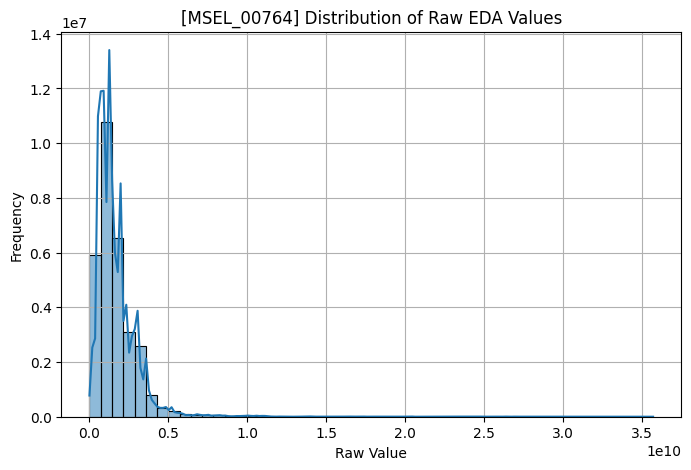

2025-05-14 13:18:41,047 - INFO - [MSEL_00764]   Outlier Check (IQR Method):
2025-05-14 13:18:41,049 - INFO - [MSEL_00764]     Q1: 831049728.00, Q3: 2099293440.00, IQR: 1268243712.00
2025-05-14 13:18:41,049 - INFO - [MSEL_00764]     Lower Bound: -1071315840.00, Upper Bound: 4001659008.00
2025-05-14 13:18:41,050 - INFO - [MSEL_00764]     Found 1170032 potential outliers in total.
2025-05-14 13:18:41,052 - INFO - [MSEL_00764]     First 30 potential upper outliers (above 4001659008.00):
                                  timestamp           EDA
1895953 2019-09-23 20:12:16.351562500+00:00  4.005766e+09
1895954    2019-09-23 20:12:16.359375+00:00  4.010718e+09
1895955 2019-09-23 20:12:16.367187500+00:00  4.015487e+09
1895956    2019-09-23 20:12:16.375000+00:00  4.020440e+09
1895957 2019-09-23 20:12:16.382812500+00:00  4.025208e+09
1895958    2019-09-23 20:12:16.390625+00:00  4.030160e+09
1895959 2019-09-23 20:12:16.398437500+00:00  4.034929e+09
1895960    2019-09-23 20:12:16.406250+00:00  4.0

count    3.062417e+07
mean     3.194227e+10
std      2.872761e+09
min      2.151043e+10
25%      2.928983e+10
50%      3.159680e+10
75%      3.485932e+10
max      3.571000e+10
Name: TEMP, dtype: float64


2025-05-14 13:18:42,700 - INFO - [MSEL_00764]   Data Duration:
2025-05-14 13:18:42,701 - INFO - [MSEL_00764]     Start: 2019-09-23 16:00:37+00:00
2025-05-14 13:18:42,701 - INFO - [MSEL_00764]     End: 2019-09-26 13:08:25.812500+00:00
2025-05-14 13:18:42,702 - INFO - [MSEL_00764]     Total Duration: 2 days 21:07:48.812500
2025-05-14 13:18:42,702 - INFO - [MSEL_00764]   Distribution of Raw Values:


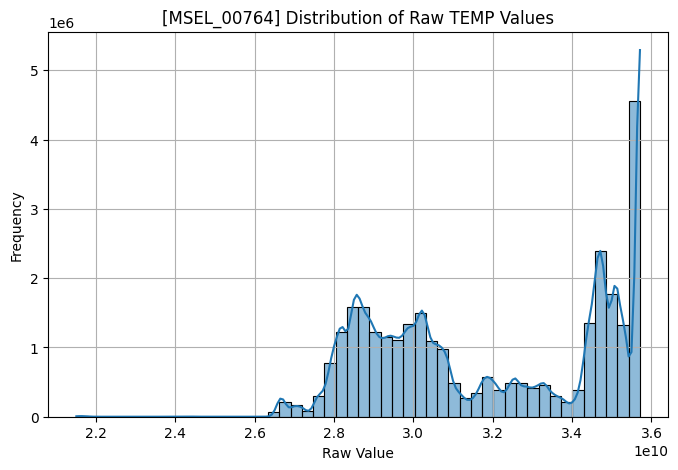

2025-05-14 13:20:45,801 - INFO - [MSEL_00764]   Outlier Check (IQR Method):
2025-05-14 13:20:45,802 - INFO - [MSEL_00764]     Q1: 29289828352.00, Q3: 34859323392.00, IQR: 5569495040.00
2025-05-14 13:20:45,802 - INFO - [MSEL_00764]     Lower Bound: 20935585792.00, Upper Bound: 43213565952.00
2025-05-14 13:20:45,803 - INFO - [MSEL_00764]     Found 0 potential outliers in total.
2025-05-14 13:20:45,803 - INFO - [MSEL_00764]     No potential outliers found using IQR method.
2025-05-14 13:20:45,804 - INFO - --------------------------------------------------------------------------------
2025-05-14 13:20:45,804 - INFO - 

2025-05-14 13:20:45,804 - INFO - 
[MSEL_00764] Sensor: ACC
2025-05-14 13:20:45,805 - INFO - [MSEL_00764]   Descriptive Statistics:


count    3.070200e+07
mean     6.233913e+10
std      3.390378e+09
min      5.935669e+06
25%      6.154510e+10
50%      6.223698e+10
75%      6.284963e+10
max      2.181183e+11
Name: ACC, dtype: float64


2025-05-14 13:20:47,573 - INFO - [MSEL_00764]   Data Duration:
2025-05-14 13:20:47,574 - INFO - [MSEL_00764]     Start: 2019-09-23 16:00:37+00:00
2025-05-14 13:20:47,575 - INFO - [MSEL_00764]     End: 2019-09-26 13:08:02.179687500+00:00
2025-05-14 13:20:47,575 - INFO - [MSEL_00764]     Total Duration: 2 days 21:07:25.179687500
2025-05-14 13:20:47,575 - INFO - [MSEL_00764]   Distribution of Raw Values:


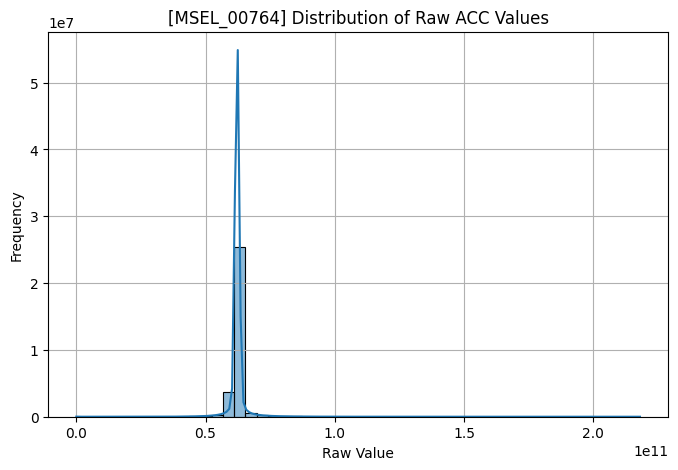

2025-05-14 13:21:32,707 - INFO - [MSEL_00764]   Outlier Check (IQR Method):
2025-05-14 13:21:32,708 - INFO - [MSEL_00764]     Q1: 61545103360.00, Q3: 62849626112.00, IQR: 1304522752.00
2025-05-14 13:21:32,708 - INFO - [MSEL_00764]     Lower Bound: 59588319232.00, Upper Bound: 64806410240.00
2025-05-14 13:21:32,708 - INFO - [MSEL_00764]     Found 2377115 potential outliers in total.
2025-05-14 13:21:32,711 - INFO - [MSEL_00764]     First 30 potential lower outliers (below 59588319232.00):
                                timestamp           ACC
10625 2019-09-23 16:02:00.007812500+00:00  5.731998e+10
10626    2019-09-23 16:02:00.015625+00:00  4.892780e+10
10627 2019-09-23 16:02:00.023437500+00:00  4.275908e+10
10628    2019-09-23 16:02:00.031250+00:00  5.094000e+10
10657 2019-09-23 16:02:00.257812500+00:00  5.831288e+10
10658    2019-09-23 16:02:00.265625+00:00  5.242937e+10
10659 2019-09-23 16:02:00.273437500+00:00  4.712155e+10
10660    2019-09-23 16:02:00.281250+00:00  4.553711e+10
106

count    5.392399e+07
mean     8.357813e+10
std      1.621402e+10
min      0.000000e+00
25%      7.276624e+10
50%      8.074822e+10
75%      9.127168e+10
max      1.691698e+11
Name: HR, dtype: float64


2025-05-14 13:21:36,071 - INFO - [MSEL_01097]   Data Duration:
2025-05-14 13:21:36,072 - INFO - [MSEL_01097]     Start: 2019-03-11 20:33:41+00:00
2025-05-14 13:21:36,072 - INFO - [MSEL_01097]     End: 2019-03-16 17:37:01.054687500+00:00
2025-05-14 13:21:36,073 - INFO - [MSEL_01097]     Total Duration: 4 days 21:03:20.054687500
2025-05-14 13:21:36,073 - INFO - [MSEL_01097]   Distribution of Raw Values:


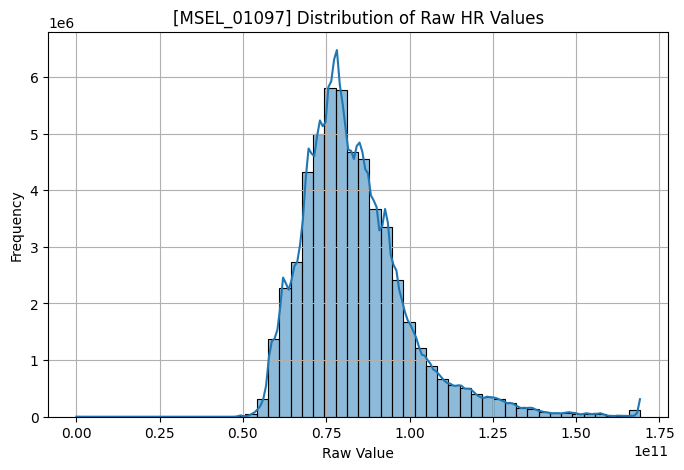

2025-05-14 13:23:59,626 - INFO - [MSEL_01097]   Outlier Check (IQR Method):
2025-05-14 13:23:59,627 - INFO - [MSEL_01097]     Q1: 72766242816.00, Q3: 91271684096.00, IQR: 18505441280.00
2025-05-14 13:23:59,628 - INFO - [MSEL_01097]     Lower Bound: 45008080896.00, Upper Bound: 119029846016.00
2025-05-14 13:23:59,628 - INFO - [MSEL_01097]     Found 2029802 potential outliers in total.
2025-05-14 13:23:59,631 - INFO - [MSEL_01097]     First 30 potential lower outliers (below 45008080896.00):
                                   timestamp   HR
8809780     2019-03-12 15:40:47.406250+00:00  0.0
8809781  2019-03-12 15:40:47.414062500+00:00  0.0
10513928    2019-03-12 19:22:41.062500+00:00  0.0
10513929 2019-03-12 19:22:41.070312500+00:00  0.0
18195857 2019-03-13 12:02:56.132812500+00:00  0.0
18195858    2019-03-13 12:02:56.140625+00:00  0.0
18195859 2019-03-13 12:02:56.148437500+00:00  0.0
18195860    2019-03-13 12:02:56.156250+00:00  0.0
18195861 2019-03-13 12:02:56.164062500+00:00  0.0
18195

count    5.379735e+07
mean     1.412989e+09
std      2.882971e+09
min      0.000000e+00
25%      1.880169e+08
50%      4.439444e+08
75%      1.175769e+09
max      3.678116e+10
Name: EDA, dtype: float64


2025-05-14 13:24:02,522 - INFO - [MSEL_01097]   Data Duration:
2025-05-14 13:24:02,524 - INFO - [MSEL_01097]     Start: 2019-03-11 20:33:31.007812500+00:00
2025-05-14 13:24:02,524 - INFO - [MSEL_01097]     End: 2019-03-16 17:36:48.226562500+00:00
2025-05-14 13:24:02,524 - INFO - [MSEL_01097]     Total Duration: 4 days 21:03:17.218750
2025-05-14 13:24:02,525 - INFO - [MSEL_01097]   Distribution of Raw Values:


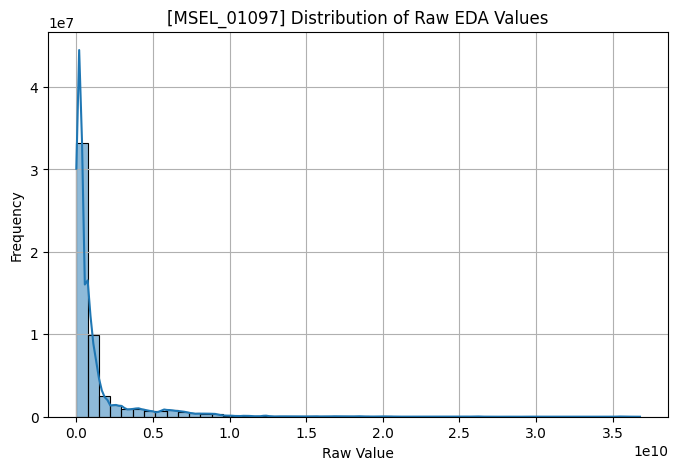

2025-05-14 13:25:52,706 - INFO - [MSEL_01097]   Outlier Check (IQR Method):
2025-05-14 13:25:52,713 - INFO - [MSEL_01097]     Q1: 188016928.00, Q3: 1175769216.00, IQR: 987752288.00
2025-05-14 13:25:52,713 - INFO - [MSEL_01097]     Lower Bound: -1293611504.00, Upper Bound: 2657397648.00
2025-05-14 13:25:52,714 - INFO - [MSEL_01097]     Found 7320769 potential outliers in total.
2025-05-14 13:25:52,717 - INFO - [MSEL_01097]     First 30 potential upper outliers (above 2657397648.00):
                                 timestamp           EDA
830859    2019-03-11 22:21:42.343750+00:00  2.658959e+09
830860 2019-03-11 22:21:42.351562500+00:00  2.665132e+09
830861    2019-03-11 22:21:42.359375+00:00  2.670893e+09
830862 2019-03-11 22:21:42.367187500+00:00  2.676243e+09
830863    2019-03-11 22:21:42.375000+00:00  2.681593e+09
830864 2019-03-11 22:21:42.382812500+00:00  2.686532e+09
830865    2019-03-11 22:21:42.390625+00:00  2.691882e+09
830866 2019-03-11 22:21:42.398437500+00:00  2.696820e+09


count    5.390967e+07
mean     3.403054e+10
std      1.104089e+09
min      2.605096e+10
25%      3.341726e+10
50%      3.414999e+10
75%      3.478997e+10
max      3.652984e+10
Name: TEMP, dtype: float64


2025-05-14 13:25:55,576 - INFO - [MSEL_01097]   Data Duration:
2025-05-14 13:25:55,578 - INFO - [MSEL_01097]     Start: 2019-03-11 20:33:31+00:00
2025-05-14 13:25:55,578 - INFO - [MSEL_01097]     End: 2019-03-16 17:36:47.226562500+00:00
2025-05-14 13:25:55,579 - INFO - [MSEL_01097]     Total Duration: 4 days 21:03:16.226562500
2025-05-14 13:25:55,579 - INFO - [MSEL_01097]   Distribution of Raw Values:


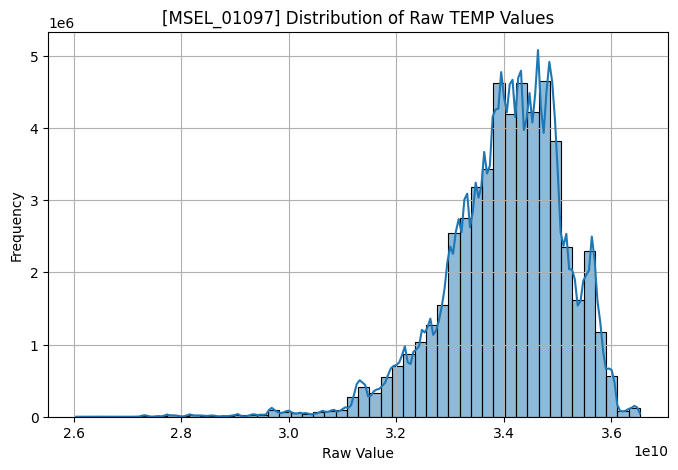

2025-05-14 13:28:40,197 - INFO - [MSEL_01097]   Outlier Check (IQR Method):
2025-05-14 13:28:40,206 - INFO - [MSEL_01097]     Q1: 33417263104.00, Q3: 34789969920.00, IQR: 1372706816.00
2025-05-14 13:28:40,207 - INFO - [MSEL_01097]     Lower Bound: 31358202880.00, Upper Bound: 36849030144.00
2025-05-14 13:28:40,208 - INFO - [MSEL_01097]     Found 1097542 potential outliers in total.
2025-05-14 13:28:40,229 - INFO - [MSEL_01097]     First 30 potential lower outliers (below 31358202880.00):
                             timestamp          TEMP
0            2019-03-11 20:33:31+00:00  2.687020e+10
1  2019-03-11 20:33:31.007812500+00:00  2.687020e+10
2     2019-03-11 20:33:31.015625+00:00  2.687020e+10
3  2019-03-11 20:33:31.023437500+00:00  2.687020e+10
4     2019-03-11 20:33:31.031250+00:00  2.687020e+10
5  2019-03-11 20:33:31.039062500+00:00  2.687020e+10
6     2019-03-11 20:33:31.046875+00:00  2.687020e+10
7  2019-03-11 20:33:31.054687500+00:00  2.687020e+10
8     2019-03-11 20:33:31.0625

count    5.391300e+07
mean     6.262405e+10
std      3.628935e+09
min      8.743286e+06
25%      6.190057e+10
50%      6.257533e+10
75%      6.312553e+10
max      2.121611e+11
Name: ACC, dtype: float64


2025-05-14 13:28:43,541 - INFO - [MSEL_01097]   Data Duration:
2025-05-14 13:28:43,542 - INFO - [MSEL_01097]     Start: 2019-03-11 20:33:31+00:00
2025-05-14 13:28:43,542 - INFO - [MSEL_01097]     End: 2019-03-16 17:36:29.492187500+00:00
2025-05-14 13:28:43,544 - INFO - [MSEL_01097]     Total Duration: 4 days 21:02:58.492187500
2025-05-14 13:28:43,545 - INFO - [MSEL_01097]   Distribution of Raw Values:


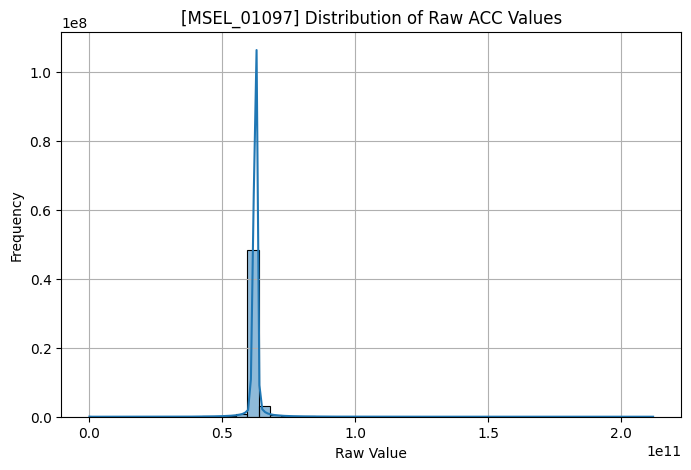

2025-05-14 13:30:05,569 - INFO - [MSEL_01097]   Outlier Check (IQR Method):
2025-05-14 13:30:05,571 - INFO - [MSEL_01097]     Q1: 61900574720.00, Q3: 63125532672.00, IQR: 1224957952.00
2025-05-14 13:30:05,572 - INFO - [MSEL_01097]     Lower Bound: 60063137792.00, Upper Bound: 64962969600.00
2025-05-14 13:30:05,572 - INFO - [MSEL_01097]     Found 3708986 potential outliers in total.
2025-05-14 13:30:05,576 - INFO - [MSEL_01097]     First 30 potential lower outliers (below 60063137792.00):
                              timestamp           ACC
136    2019-03-11 20:33:32.062500+00:00  5.828277e+10
137 2019-03-11 20:33:32.070312500+00:00  5.803363e+10
138    2019-03-11 20:33:32.078125+00:00  5.779488e+10
139 2019-03-11 20:33:32.085937500+00:00  5.755611e+10
140    2019-03-11 20:33:32.093750+00:00  5.734846e+10
141 2019-03-11 20:33:32.101562500+00:00  5.911327e+10
159 2019-03-11 20:33:32.242187500+00:00  5.938316e+10
160    2019-03-11 20:33:32.250000+00:00  5.844368e+10
161 2019-03-11 20:33:

count    3.878102e+07
mean     6.774806e+10
std      2.281602e+10
min      0.000000e+00
25%      5.052581e+10
50%      5.971519e+10
75%      7.893138e+10
max      1.197988e+11
Name: HR, dtype: float64


2025-05-14 13:30:07,831 - INFO - [MSEL_01110]   Data Duration:
2025-05-14 13:30:07,833 - INFO - [MSEL_01110]     Start: 2019-06-06 19:46:32+00:00
2025-05-14 13:30:07,833 - INFO - [MSEL_01110]     End: 2019-06-10 08:05:00.992187500+00:00
2025-05-14 13:30:07,834 - INFO - [MSEL_01110]     Total Duration: 3 days 12:18:28.992187500
2025-05-14 13:30:07,834 - INFO - [MSEL_01110]   Distribution of Raw Values:


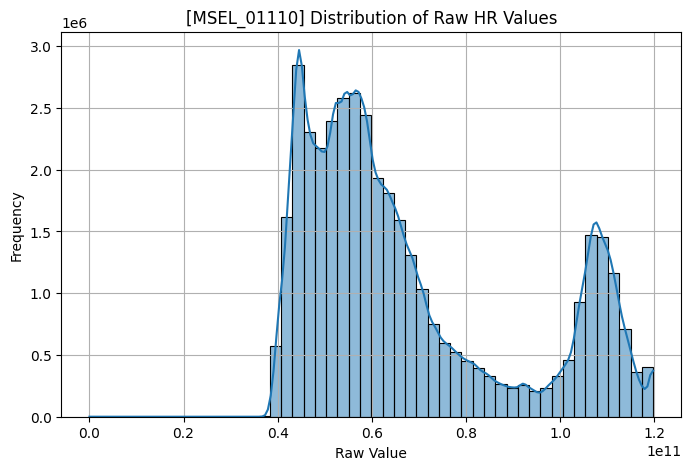

2025-05-14 13:32:47,434 - INFO - [MSEL_01110]   Outlier Check (IQR Method):
2025-05-14 13:32:47,435 - INFO - [MSEL_01110]     Q1: 50525814784.00, Q3: 78931378176.00, IQR: 28405563392.00
2025-05-14 13:32:47,435 - INFO - [MSEL_01110]     Lower Bound: 7917469696.00, Upper Bound: 121539723264.00
2025-05-14 13:32:47,436 - INFO - [MSEL_01110]     Found 165 potential outliers in total.
2025-05-14 13:32:47,441 - INFO - [MSEL_01110]     First 30 potential lower outliers (below 7917469696.00):
                                  timestamp   HR
1857803 2019-06-06 23:48:29.085937500+00:00  0.0
1857804    2019-06-06 23:48:29.093750+00:00  0.0
1857805 2019-06-06 23:48:29.101562500+00:00  0.0
1857806    2019-06-06 23:48:29.109375+00:00  0.0
7195417 2019-06-07 11:23:29.195312500+00:00  0.0
7195418    2019-06-07 11:23:29.203125+00:00  0.0
7195419 2019-06-07 11:23:29.210937500+00:00  0.0
7195420    2019-06-07 11:23:29.218750+00:00  0.0
7326740    2019-06-07 11:40:35.156250+00:00  0.0
7326741 2019-06-07 11

count    3.877873e+07
mean     5.759619e+08
std      1.811426e+09
min      0.000000e+00
25%      1.127857e+08
50%      2.510978e+08
75%      3.846798e+08
max      3.626476e+10
Name: EDA, dtype: float64


2025-05-14 13:32:49,663 - INFO - [MSEL_01110]   Data Duration:
2025-05-14 13:32:49,664 - INFO - [MSEL_01110]     Start: 2019-06-06 19:46:22.007812500+00:00
2025-05-14 13:32:49,664 - INFO - [MSEL_01110]     End: 2019-06-10 08:04:45.945312500+00:00
2025-05-14 13:32:49,666 - INFO - [MSEL_01110]     Total Duration: 3 days 12:18:23.937500
2025-05-14 13:32:49,667 - INFO - [MSEL_01110]   Distribution of Raw Values:


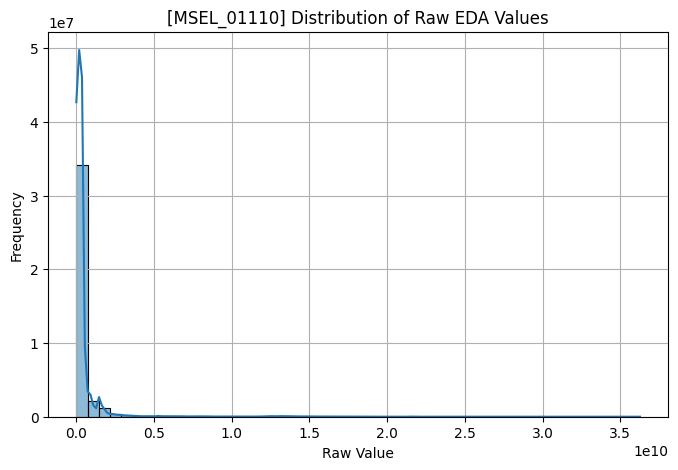

2025-05-14 13:33:55,231 - INFO - [MSEL_01110]   Outlier Check (IQR Method):
2025-05-14 13:33:55,233 - INFO - [MSEL_01110]     Q1: 112785712.00, Q3: 384679840.00, IQR: 271894128.00
2025-05-14 13:33:55,233 - INFO - [MSEL_01110]     Lower Bound: -295055480.00, Upper Bound: 792521032.00
2025-05-14 13:33:55,234 - INFO - [MSEL_01110]     Found 4271294 potential outliers in total.
2025-05-14 13:33:55,238 - INFO - [MSEL_01110]     First 30 potential upper outliers (above 792521032.00):
                                 timestamp           EDA
865813    2019-06-06 21:39:06.171875+00:00  7.983466e+08
865814 2019-06-06 21:39:06.179687500+00:00  8.067798e+08
865815    2019-06-06 21:39:06.187500+00:00  8.151372e+08
865816 2019-06-06 21:39:06.195312500+00:00  8.235704e+08
865817    2019-06-06 21:39:06.203125+00:00  8.320036e+08
865818 2019-06-06 21:39:06.210937500+00:00  8.404369e+08
865819    2019-06-06 21:39:06.218750+00:00  8.488701e+08
865820 2019-06-06 21:39:06.226562500+00:00  8.572274e+08
8658

count    3.878003e+07
mean     3.350583e+10
std      2.376934e+09
min      2.929010e+10
25%      3.223018e+10
50%      3.428996e+10
75%      3.540999e+10
max      3.631000e+10
Name: TEMP, dtype: float64


2025-05-14 13:33:58,100 - INFO - [MSEL_01110]   Data Duration:
2025-05-14 13:33:58,101 - INFO - [MSEL_01110]     Start: 2019-06-06 19:46:22+00:00
2025-05-14 13:33:58,101 - INFO - [MSEL_01110]     End: 2019-06-10 08:04:45.445312500+00:00
2025-05-14 13:33:58,102 - INFO - [MSEL_01110]     Total Duration: 3 days 12:18:23.445312500
2025-05-14 13:33:58,103 - INFO - [MSEL_01110]   Distribution of Raw Values:


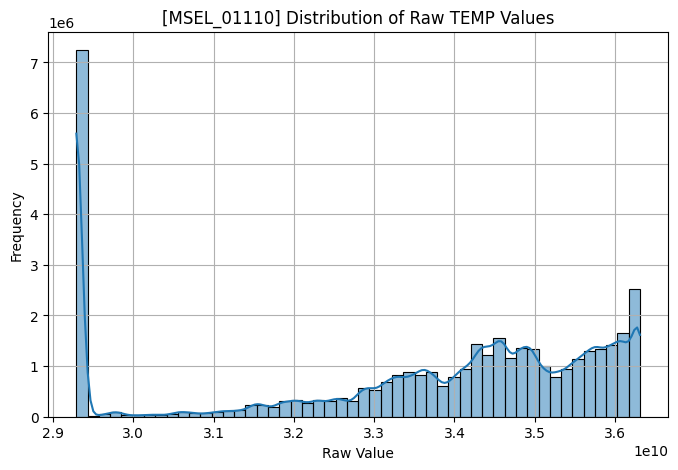

2025-05-14 13:37:13,825 - INFO - [MSEL_01110]   Outlier Check (IQR Method):
2025-05-14 13:37:13,826 - INFO - [MSEL_01110]     Q1: 32230178816.00, Q3: 35409989632.00, IQR: 3179810816.00
2025-05-14 13:37:13,827 - INFO - [MSEL_01110]     Lower Bound: 27460462592.00, Upper Bound: 40179705856.00
2025-05-14 13:37:13,827 - INFO - [MSEL_01110]     Found 0 potential outliers in total.
2025-05-14 13:37:13,827 - INFO - [MSEL_01110]     No potential outliers found using IQR method.
2025-05-14 13:37:13,828 - INFO - --------------------------------------------------------------------------------
2025-05-14 13:37:13,829 - INFO - 

2025-05-14 13:37:13,829 - INFO - 
[MSEL_01110] Sensor: ACC
2025-05-14 13:37:13,830 - INFO - [MSEL_01110]   Descriptive Statistics:


count    3.878400e+07
mean     6.215328e+10
std      1.918925e+09
min      6.759644e+06
25%      6.140221e+10
50%      6.232210e+10
75%      6.262556e+10
max      1.827469e+11
Name: ACC, dtype: float64


2025-05-14 13:37:16,154 - INFO - [MSEL_01110]   Data Duration:
2025-05-14 13:37:16,155 - INFO - [MSEL_01110]     Start: 2019-06-06 19:46:22+00:00
2025-05-14 13:37:16,156 - INFO - [MSEL_01110]     End: 2019-06-10 08:04:49.054687500+00:00
2025-05-14 13:37:16,156 - INFO - [MSEL_01110]     Total Duration: 3 days 12:18:27.054687500
2025-05-14 13:37:16,157 - INFO - [MSEL_01110]   Distribution of Raw Values:


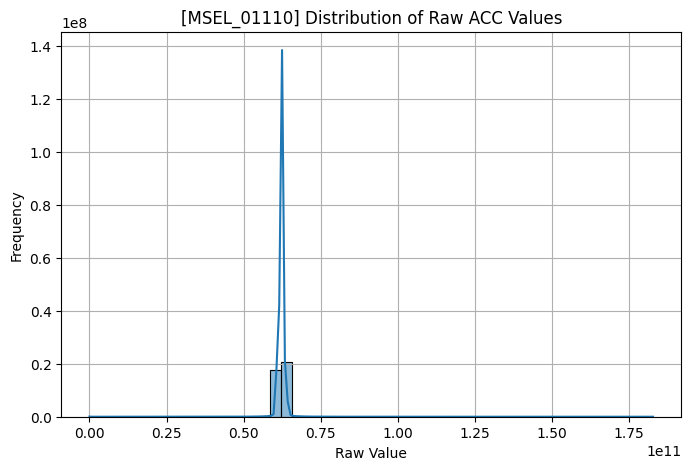

2025-05-14 13:38:09,416 - INFO - [MSEL_01110]   Outlier Check (IQR Method):
2025-05-14 13:38:09,417 - INFO - [MSEL_01110]     Q1: 61402206208.00, Q3: 62625562624.00, IQR: 1223356416.00
2025-05-14 13:38:09,418 - INFO - [MSEL_01110]     Lower Bound: 59567171584.00, Upper Bound: 64460597248.00
2025-05-14 13:38:09,418 - INFO - [MSEL_01110]     Found 1251429 potential outliers in total.
2025-05-14 13:38:09,421 - INFO - [MSEL_01110]     First 30 potential lower outliers (below 59567171584.00):
                              timestamp           ACC
60     2019-06-06 19:46:22.468750+00:00  5.871367e+10
158    2019-06-06 19:46:23.234375+00:00  5.902188e+10
159 2019-06-06 19:46:23.242187500+00:00  5.627170e+10
160    2019-06-06 19:46:23.250000+00:00  5.364006e+10
161 2019-06-06 19:46:23.257812500+00:00  5.622429e+10
162    2019-06-06 19:46:23.265625+00:00  5.882747e+10
316    2019-06-06 19:46:24.468750+00:00  5.907404e+10
317 2019-06-06 19:46:24.476562500+00:00  5.908826e+10
318    2019-06-06 19:

count    2.798248e+07
mean     8.219014e+10
std      1.557735e+10
min      0.000000e+00
25%      7.219010e+10
50%      7.900815e+10
75%      8.866324e+10
max      1.975799e+11
Name: HR, dtype: float64


2025-05-14 13:38:11,125 - INFO - [MSEL_01462]   Data Duration:
2025-05-14 13:38:11,125 - INFO - [MSEL_01462]     Start: 2019-09-23 18:14:43+00:00
2025-05-14 13:38:11,126 - INFO - [MSEL_01462]     End: 2019-09-26 13:05:16.054687500+00:00
2025-05-14 13:38:11,126 - INFO - [MSEL_01462]     Total Duration: 2 days 18:50:33.054687500
2025-05-14 13:38:11,127 - INFO - [MSEL_01462]   Distribution of Raw Values:


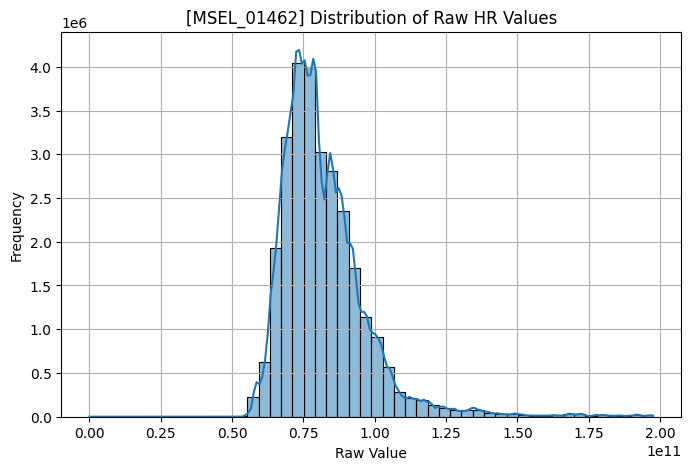

2025-05-14 13:39:23,556 - INFO - [MSEL_01462]   Outlier Check (IQR Method):
2025-05-14 13:39:23,557 - INFO - [MSEL_01462]     Q1: 72190099456.00, Q3: 88663236608.00, IQR: 16473137152.00
2025-05-14 13:39:23,558 - INFO - [MSEL_01462]     Lower Bound: 47480393728.00, Upper Bound: 113372942336.00
2025-05-14 13:39:23,558 - INFO - [MSEL_01462]     Found 1032120 potential outliers in total.
2025-05-14 13:39:23,561 - INFO - [MSEL_01462]     First 30 potential lower outliers (below 47480393728.00):
                                   timestamp   HR
9414078     2019-09-24 14:40:31.484375+00:00  0.0
9414079  2019-09-24 14:40:31.492187500+00:00  0.0
9414080     2019-09-24 14:40:31.500000+00:00  0.0
10223044    2019-09-24 16:25:51.531250+00:00  0.0
10223045 2019-09-24 16:25:51.539062500+00:00  0.0
10223046    2019-09-24 16:25:51.546875+00:00  0.0
10223047 2019-09-24 16:25:51.554687500+00:00  0.0
10223048    2019-09-24 16:25:51.562500+00:00  0.0
10223049 2019-09-24 16:25:51.570312500+00:00  0.0
10223

count    2.795513e+07
mean     7.734458e+09
std      1.274617e+10
min      0.000000e+00
25%      9.424547e+08
50%      1.803068e+09
75%      7.326083e+09
max      8.380430e+10
Name: EDA, dtype: float64


2025-05-14 13:39:25,132 - INFO - [MSEL_01462]   Data Duration:
2025-05-14 13:39:25,132 - INFO - [MSEL_01462]     Start: 2019-09-23 18:14:33.007812500+00:00
2025-05-14 13:39:25,133 - INFO - [MSEL_01462]     End: 2019-09-26 13:05:04.804687500+00:00
2025-05-14 13:39:25,133 - INFO - [MSEL_01462]     Total Duration: 2 days 18:50:31.796875
2025-05-14 13:39:25,134 - INFO - [MSEL_01462]   Distribution of Raw Values:


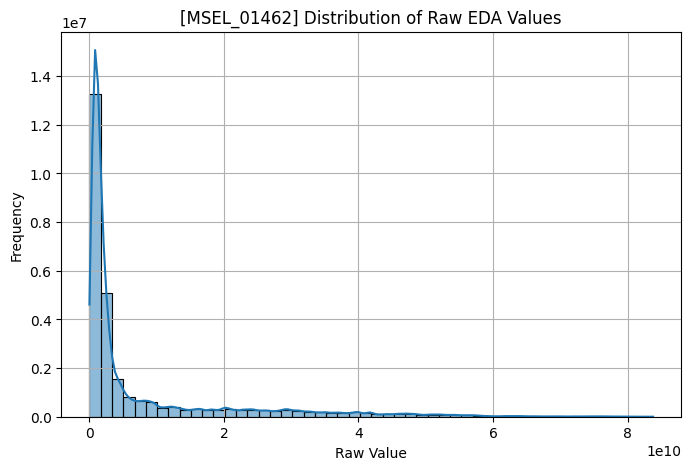

2025-05-14 13:40:47,216 - INFO - [MSEL_01462]   Outlier Check (IQR Method):
2025-05-14 13:40:47,217 - INFO - [MSEL_01462]     Q1: 942454720.00, Q3: 7326082560.00, IQR: 6383627840.00
2025-05-14 13:40:47,218 - INFO - [MSEL_01462]     Lower Bound: -8632987040.00, Upper Bound: 16901524320.00
2025-05-14 13:40:47,218 - INFO - [MSEL_01462]     Found 4556769 potential outliers in total.
2025-05-14 13:40:47,221 - INFO - [MSEL_01462]     First 30 potential upper outliers (above 16901524320.00):
                                timestamp           EDA
38047    2019-09-23 18:19:30.750000+00:00  1.690664e+10
38048 2019-09-23 18:19:30.757812500+00:00  1.691303e+10
38049    2019-09-23 18:19:30.765625+00:00  1.691943e+10
38050 2019-09-23 18:19:30.773437500+00:00  1.692582e+10
38051    2019-09-23 18:19:30.781250+00:00  1.693349e+10
38052 2019-09-23 18:19:30.789062500+00:00  1.693989e+10
38053    2019-09-23 18:19:30.796875+00:00  1.694628e+10
38054 2019-09-23 18:19:30.804687500+00:00  1.695268e+10
38055 

count    2.798107e+07
mean     3.466700e+10
std      1.520708e+09
min      2.581016e+10
25%      3.399971e+10
50%      3.496996e+10
75%      3.583985e+10
max      3.678982e+10
Name: TEMP, dtype: float64


2025-05-14 13:40:49,082 - INFO - [MSEL_01462]   Data Duration:
2025-05-14 13:40:49,083 - INFO - [MSEL_01462]     Start: 2019-09-23 18:14:34.750000+00:00
2025-05-14 13:40:49,083 - INFO - [MSEL_01462]     End: 2019-09-26 13:05:03.750000+00:00
2025-05-14 13:40:49,084 - INFO - [MSEL_01462]     Total Duration: 2 days 18:50:29
2025-05-14 13:40:49,085 - INFO - [MSEL_01462]   Distribution of Raw Values:


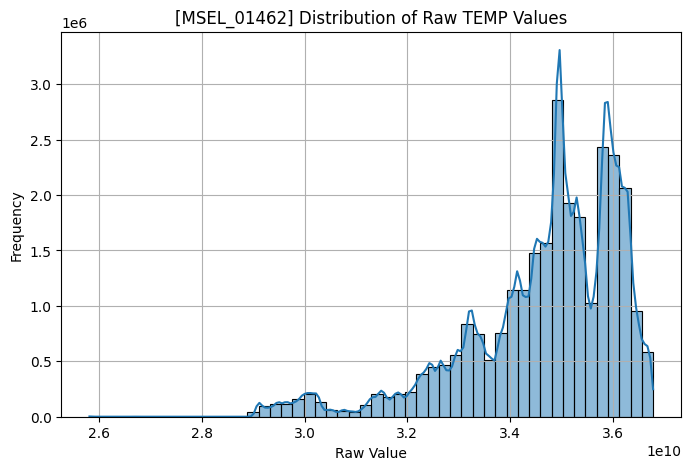

2025-05-14 13:42:22,913 - INFO - [MSEL_01462]   Outlier Check (IQR Method):
2025-05-14 13:42:22,914 - INFO - [MSEL_01462]     Q1: 33999710208.00, Q3: 35839848448.00, IQR: 1840138240.00
2025-05-14 13:42:22,914 - INFO - [MSEL_01462]     Lower Bound: 31239502848.00, Upper Bound: 38600055808.00
2025-05-14 13:42:22,916 - INFO - [MSEL_01462]     Found 1090281 potential outliers in total.
2025-05-14 13:42:22,919 - INFO - [MSEL_01462]     First 30 potential lower outliers (below 31239502848.00):
                             timestamp          TEMP
0     2019-09-23 18:14:34.750000+00:00  2.581066e+10
1  2019-09-23 18:14:34.757812500+00:00  2.582239e+10
2     2019-09-23 18:14:34.765625+00:00  2.583428e+10
3  2019-09-23 18:14:34.773437500+00:00  2.584618e+10
4     2019-09-23 18:14:34.781250+00:00  2.585807e+10
5  2019-09-23 18:14:34.789062500+00:00  2.586980e+10
6     2019-09-23 18:14:34.796875+00:00  2.588170e+10
7  2019-09-23 18:14:34.804687500+00:00  2.589360e+10
8     2019-09-23 18:14:34.8125

count    2.797600e+07
mean     6.219185e+10
std      3.021928e+09
min      4.837036e+06
25%      6.132115e+10
50%      6.199468e+10
75%      6.294395e+10
max      2.195493e+11
Name: ACC, dtype: float64


2025-05-14 13:42:24,705 - INFO - [MSEL_01462]   Data Duration:
2025-05-14 13:42:24,705 - INFO - [MSEL_01462]     Start: 2019-09-23 18:14:33+00:00
2025-05-14 13:42:24,706 - INFO - [MSEL_01462]     End: 2019-09-26 13:04:41.367187500+00:00
2025-05-14 13:42:24,706 - INFO - [MSEL_01462]     Total Duration: 2 days 18:50:08.367187500
2025-05-14 13:42:24,707 - INFO - [MSEL_01462]   Distribution of Raw Values:


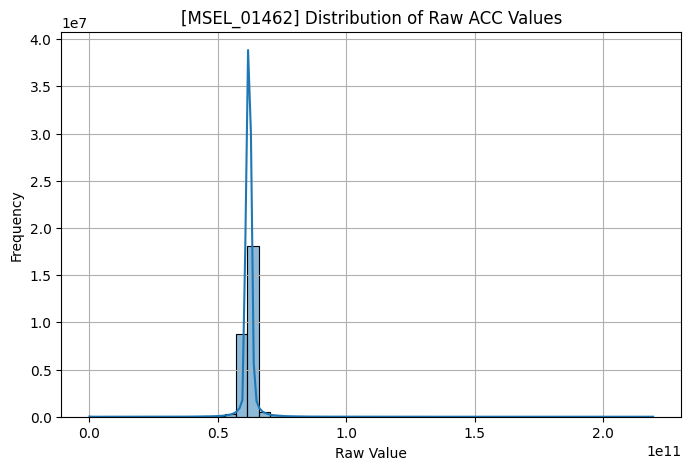

2025-05-14 13:43:07,034 - INFO - [MSEL_01462]   Outlier Check (IQR Method):
2025-05-14 13:43:07,036 - INFO - [MSEL_01462]     Q1: 61321150464.00, Q3: 62943952896.00, IQR: 1622802432.00
2025-05-14 13:43:07,037 - INFO - [MSEL_01462]     Lower Bound: 58886946816.00, Upper Bound: 65378156544.00
2025-05-14 13:43:07,037 - INFO - [MSEL_01462]     Found 1636281 potential outliers in total.
2025-05-14 13:43:07,039 - INFO - [MSEL_01462]     First 30 potential lower outliers (below 58886946816.00):
                              timestamp           ACC
67  2019-09-23 18:14:33.523437500+00:00  5.328142e+10
68     2019-09-23 18:14:33.531250+00:00  4.805240e+10
69  2019-09-23 18:14:33.539062500+00:00  4.896455e+10
70     2019-09-23 18:14:33.546875+00:00  5.064040e+10
71  2019-09-23 18:14:33.554687500+00:00  5.300034e+10
72     2019-09-23 18:14:33.562500+00:00  5.595956e+10
73  2019-09-23 18:14:33.570312500+00:00  5.791646e+10
86     2019-09-23 18:14:33.671875+00:00  5.759827e+10
87  2019-09-23 18:14:

count    5.371789e+07
mean     8.657580e+10
std      2.365152e+10
min      0.000000e+00
25%      6.690363e+10
50%      8.068374e+10
75%      1.038156e+11
max      1.798799e+11
Name: HR, dtype: float64


2025-05-14 13:43:10,390 - INFO - [MSEL_01550]   Data Duration:
2025-05-14 13:43:10,392 - INFO - [MSEL_01550]     Start: 2019-03-08 16:03:58+00:00
2025-05-14 13:43:10,392 - INFO - [MSEL_01550]     End: 2019-03-13 13:43:08.992187500+00:00
2025-05-14 13:43:10,393 - INFO - [MSEL_01550]     Total Duration: 4 days 21:39:10.992187500
2025-05-14 13:43:10,394 - INFO - [MSEL_01550]   Distribution of Raw Values:


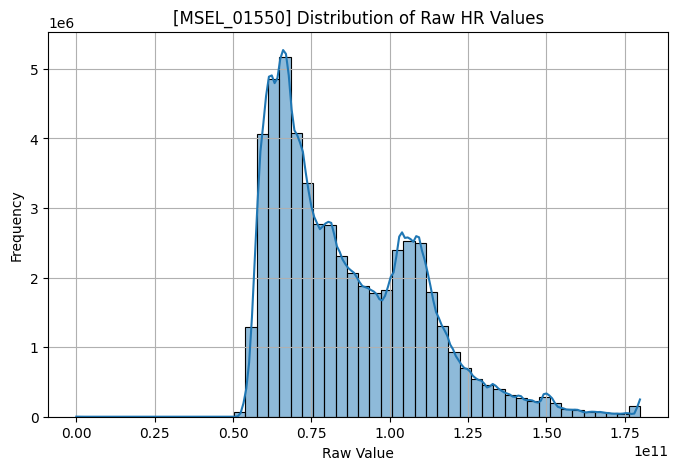

2025-05-14 13:46:07,012 - INFO - [MSEL_01550]   Outlier Check (IQR Method):
2025-05-14 13:46:07,013 - INFO - [MSEL_01550]     Q1: 66903625728.00, Q3: 103815553024.00, IQR: 36911927296.00
2025-05-14 13:46:07,013 - INFO - [MSEL_01550]     Lower Bound: 11535734784.00, Upper Bound: 159183443968.00
2025-05-14 13:46:07,014 - INFO - [MSEL_01550]     Found 441296 potential outliers in total.
2025-05-14 13:46:07,016 - INFO - [MSEL_01550]     First 30 potential lower outliers (below 11535734784.00):
                                  timestamp   HR
635799  2019-03-08 17:26:45.179687500+00:00  0.0
635800     2019-03-08 17:26:45.187500+00:00  0.0
838985  2019-03-08 17:53:12.570312500+00:00  0.0
838986     2019-03-08 17:53:12.578125+00:00  0.0
838987  2019-03-08 17:53:12.585937500+00:00  0.0
838988     2019-03-08 17:53:12.593750+00:00  0.0
3706485 2019-03-09 00:06:34.914062500+00:00  0.0
3706486    2019-03-09 00:06:34.921875+00:00  0.0
3706487 2019-03-09 00:06:34.929687500+00:00  0.0
3706488    2019

count    5.356212e+07
mean     1.328854e+09
std      5.919895e+09
min      0.000000e+00
25%      2.870766e+07
50%      7.127418e+07
75%      2.609811e+08
max      8.029764e+10
Name: EDA, dtype: float64


2025-05-14 13:46:10,305 - INFO - [MSEL_01550]   Data Duration:
2025-05-14 13:46:10,306 - INFO - [MSEL_01550]     Start: 2019-03-08 16:03:48.007812500+00:00
2025-05-14 13:46:10,306 - INFO - [MSEL_01550]     End: 2019-03-13 13:42:59.265625+00:00
2025-05-14 13:46:10,306 - INFO - [MSEL_01550]     Total Duration: 4 days 21:39:11.257812500
2025-05-14 13:46:10,307 - INFO - [MSEL_01550]   Distribution of Raw Values:


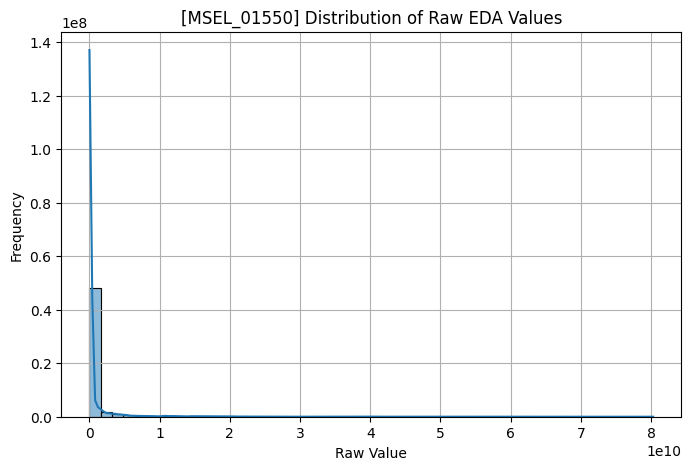

2025-05-14 13:47:50,682 - INFO - [MSEL_01550]   Outlier Check (IQR Method):
2025-05-14 13:47:50,683 - INFO - [MSEL_01550]     Q1: 28707656.00, Q3: 260981120.00, IQR: 232273464.00
2025-05-14 13:47:50,684 - INFO - [MSEL_01550]     Lower Bound: -319702540.00, Upper Bound: 609391316.00
2025-05-14 13:47:50,684 - INFO - [MSEL_01550]     Found 8045884 potential outliers in total.
2025-05-14 13:47:50,687 - INFO - [MSEL_01550]     First 30 potential upper outliers (above 609391316.00):
                                timestamp          EDA
42807    2019-03-08 16:09:22.437500+00:00  610181184.0
42808 2019-03-08 16:09:22.445312500+00:00  610181184.0
42809    2019-03-08 16:09:22.453125+00:00  610181184.0
42810 2019-03-08 16:09:22.460937500+00:00  611406464.0
42811    2019-03-08 16:09:22.468750+00:00  611406464.0
42812 2019-03-08 16:09:22.476562500+00:00  611406464.0
42813    2019-03-08 16:09:22.484375+00:00  611406464.0
42814 2019-03-08 16:09:22.492187500+00:00  611406464.0
42815    2019-03-08 16:

count    5.366892e+07
mean     3.331754e+10
std      2.152623e+09
min      2.673016e+10
25%      3.149021e+10
50%      3.348055e+10
75%      3.502978e+10
max      3.725000e+10
Name: TEMP, dtype: float64


2025-05-14 13:47:53,481 - INFO - [MSEL_01550]   Data Duration:
2025-05-14 13:47:53,482 - INFO - [MSEL_01550]     Start: 2019-03-08 16:03:48+00:00
2025-05-14 13:47:53,482 - INFO - [MSEL_01550]     End: 2019-03-13 13:42:58.523437500+00:00
2025-05-14 13:47:53,484 - INFO - [MSEL_01550]     Total Duration: 4 days 21:39:10.523437500
2025-05-14 13:47:53,484 - INFO - [MSEL_01550]   Distribution of Raw Values:


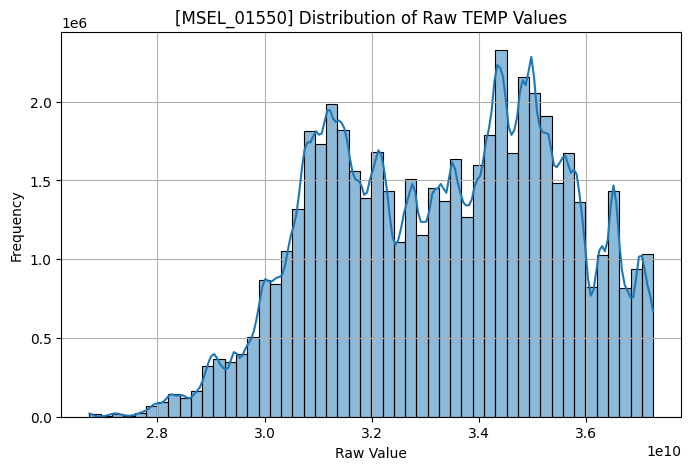

2025-05-14 13:51:37,620 - INFO - [MSEL_01550]   Outlier Check (IQR Method):
2025-05-14 13:51:37,622 - INFO - [MSEL_01550]     Q1: 31490205696.00, Q3: 35029778432.00, IQR: 3539572736.00
2025-05-14 13:51:37,623 - INFO - [MSEL_01550]     Lower Bound: 26180846592.00, Upper Bound: 40339137536.00
2025-05-14 13:51:37,623 - INFO - [MSEL_01550]     Found 0 potential outliers in total.
2025-05-14 13:51:37,624 - INFO - [MSEL_01550]     No potential outliers found using IQR method.
2025-05-14 13:51:37,624 - INFO - --------------------------------------------------------------------------------
2025-05-14 13:51:37,625 - INFO - 

2025-05-14 13:51:37,625 - INFO - 
[MSEL_01550] Sensor: ACC
2025-05-14 13:51:37,626 - INFO - [MSEL_01550]   Descriptive Statistics:


count    5.371700e+07
mean     6.201977e+10
std      2.487028e+09
min      1.028442e+07
25%      6.123723e+10
50%      6.197562e+10
75%      6.258118e+10
max      2.201266e+11
Name: ACC, dtype: float64


2025-05-14 13:51:40,653 - INFO - [MSEL_01550]   Data Duration:
2025-05-14 13:51:40,655 - INFO - [MSEL_01550]     Start: 2019-03-08 16:03:48+00:00
2025-05-14 13:51:40,655 - INFO - [MSEL_01550]     End: 2019-03-13 13:43:04.617187500+00:00
2025-05-14 13:51:40,656 - INFO - [MSEL_01550]     Total Duration: 4 days 21:39:16.617187500
2025-05-14 13:51:40,656 - INFO - [MSEL_01550]   Distribution of Raw Values:


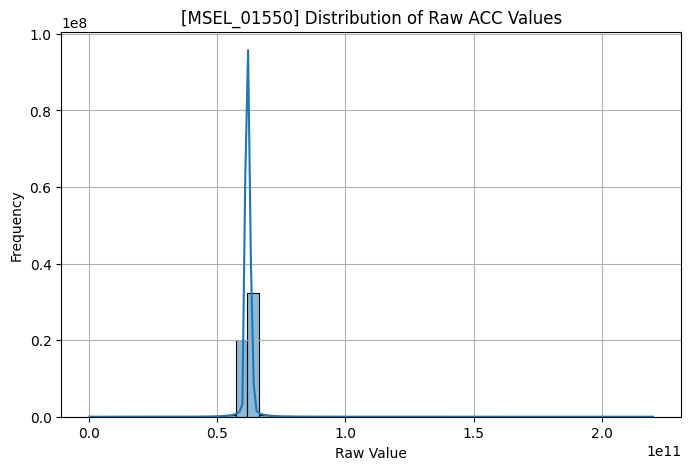

2025-05-14 13:52:56,830 - INFO - [MSEL_01550]   Outlier Check (IQR Method):
2025-05-14 13:52:56,832 - INFO - [MSEL_01550]     Q1: 61237227520.00, Q3: 62581178368.00, IQR: 1343950848.00
2025-05-14 13:52:56,833 - INFO - [MSEL_01550]     Lower Bound: 59221301248.00, Upper Bound: 64597104640.00
2025-05-14 13:52:56,833 - INFO - [MSEL_01550]     Found 2583189 potential outliers in total.
2025-05-14 13:52:56,844 - INFO - [MSEL_01550]     First 30 potential lower outliers (below 59221301248.00):
                               timestamp           ACC
1560    2019-03-08 16:04:00.187500+00:00  5.907523e+10
1610    2019-03-08 16:04:00.578125+00:00  5.905928e+10
1611 2019-03-08 16:04:00.585937500+00:00  5.871930e+10
1612    2019-03-08 16:04:00.593750+00:00  5.848556e+10
1613 2019-03-08 16:04:00.601562500+00:00  5.877773e+10
1614    2019-03-08 16:04:00.609375+00:00  5.906992e+10
1617 2019-03-08 16:04:00.632812500+00:00  5.902742e+10
1618    2019-03-08 16:04:00.640625+00:00  5.853337e+10
1619 2019-03

In [ ]:
# ## 4. Intermediate Analysis on Raw Data (Per Patient)
# This section iterates through the raw data loaded in the previous step and performs analysis and visualization for each patient.
# **Raw time series plots are commented out due to potential size. Distribution plots are added.**
logging.info("\n--- Starting Intermediate Analysis on raw data before preprocessing data on loaded patients ---")

if raw_patient_data_list:
    for patient_data in raw_patient_data_list:
        patient_id = patient_data['patient_id']
        sensor_data_dict = patient_data['sensor_data_dict']

        logging.info(f"\n[{patient_id}] --- Intermediate Analysis (Raw Data) ---")
        for sensor_name, df in sensor_data_dict.items():
            logging.info(f"\n[{patient_id}] Sensor: {sensor_name}")

            if df.empty:
                logging.info(f"[{patient_id}]   Data is empty.")
                continue

            # Print Basic Stats
            logging.info(f"[{patient_id}]   Descriptive Statistics:")
            print(df[sensor_name].describe()) # Print stats for the sensor column

            # Check Data Duration
            if not df.empty and 'timestamp' in df.columns:
                start_time = df['timestamp'].min()
                end_time = df['timestamp'].max()
                duration = end_time - start_time
                logging.info(f"[{patient_id}]   Data Duration:")
                logging.info(f"[{patient_id}]     Start: {start_time}")
                logging.info(f"[{patient_id}]     End: {end_time}")
                logging.info(f"[{patient_id}]     Total Duration: {duration}")
            else:
                 logging.warning(f"[{patient_id}]   Could not determine data duration (empty or no timestamp column).")

            # --- ADDED: Visualize Distribution of Raw Data Values ---
            logging.info(f"[{patient_id}]   Distribution of Raw Values:")
            if not df[sensor_name].empty:
                plt.figure(figsize=(8, 5))
                # Use histplot to show the frequency distribution of values
                sns.histplot(df[sensor_name], bins=50, kde=True) # Adjust bins as needed
                plt.title(f'[{patient_id}] Distribution of Raw {sensor_name} Values')
                plt.xlabel('Raw Value')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()
            else:
                logging.warning(f"[{patient_id}]   Cannot plot distribution: {sensor_name} data is empty.")
            # --- END ADDED ---


            # Check for Outliers (Simple IQR-based approach)
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = df[sensor_name].quantile(0.25)
            Q3 = df[sensor_name].quantile(0.75)
            IQR = Q3 - Q1

            # Define outlier bounds (1.5 * IQR is common)
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Find outliers
            lower_outliers = df[df[sensor_name] < lower_bound]
            upper_outliers = df[df[sensor_name] > upper_bound]
            all_outliers_count = len(lower_outliers) + len(upper_outliers)

            logging.info(f"[{patient_id}]   Outlier Check (IQR Method):")
            logging.info(f"[{patient_id}]     Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
            logging.info(f"[{patient_id}]     Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
            logging.info(f"[{patient_id}]     Found {all_outliers_count} potential outliers in total.")

            # Print up to 30 lower outliers
            if not lower_outliers.empty:
                 logging.info(f"[{patient_id}]     First {min(30, len(lower_outliers))} potential lower outliers (below {lower_bound:.2f}):\n{lower_outliers.head(30)}")

            # Print up to 30 upper outliers
            if not upper_outliers.empty:
                 logging.info(f"[{patient_id}]     First {min(30, len(upper_outliers))} potential upper outliers (above {upper_bound:.2f}):\n{upper_outliers.head(30)}")

            # If no outliers found, explicitly state it
            if lower_outliers.empty and upper_outliers.empty:
                 logging.info(f"[{patient_id}]     No potential outliers found using IQR method.")


            logging.info("-" * 80) # Separator for clarity between sensors
            logging.info("\n")


        logging.info(f"\n[{patient_id}] --- End Intermediate Analysis (Raw Data) ---")

else:
    logging.warning("\nNo raw patient data loaded to perform Intermediate Analysis.")

#### 4. Preprocess Raw Sensor Data (Per Patient) Experimennt Skip

In [ ]:
preprocessed_patient_data_list = []

logging.info("\n--- Starting Preprocessing Raw Sensor Data for loaded patients ---")

# Limit the number of rows to display and preprocess for visualization in this cell
PREPROCESSING_VIZ_ROW_LIMIT = 1000 # Adjust this limit as needed

if raw_patient_data_list:
    for patient_data in raw_patient_data_list:
        patient_id = patient_data['patient_id']
        # Use the correct key name
        raw_sensor_data_dict = patient_data['sensor_data_dict']

        logging.info(f"\n[{patient_id}] --- Preprocessing Raw Sensor Data ---")

        # Create a dictionary with limited data for visualization in this cell
        raw_sensor_data_dict_limited = {
            sensor_name: df.head(PREPROCESSING_VIZ_ROW_LIMIT).copy() if not df.empty else df.copy()
            for sensor_name, df in raw_sensor_data_dict.items()
        }


        # --- Before Preprocessing ---
        logging.info(f"[{patient_id}] Raw Data Snapshot (First {PREPROCESSING_VIZ_ROW_LIMIT} rows per sensor):")
        for sensor_name, df in raw_sensor_data_dict_limited.items():
             logging.info(f"\n[{patient_id}]   Raw {sensor_name} Data:")
             logging.info(f"\n{df.head()}")
             if not df.empty and sensor_name in df.columns:
                 logging.info(f"[{patient_id}]   Raw {sensor_name} Stats:\n{df[sensor_name].describe()}")
                 zero_count = (df[sensor_name] == 0).sum()
                 logging.info(f"[{patient_id}]   Raw {sensor_name} Zero Count: {zero_count}")
                 nan_count = df[sensor_name].isnull().sum()
                 logging.info(f"[{patient_id}]   Raw {sensor_name} NaN Count: {nan_count}")
             elif df.empty:
                 logging.warning(f"[{patient_id}]   Raw {sensor_name} data is empty.")
             else:
                 logging.warning(f"[{patient_id}]   Raw {sensor_name} data does not contain column '{sensor_name}'.")


        # Perform Preprocessing on the limited data for visualization
        # NOTE: The preprocess_raw_sensor_data function is designed to handle the full DataFrame,
        # but here we pass a limited version to prevent MemoryError during visualization.
        # The full data will be processed in the synchronization step.
        preprocessed_sensor_data_dict_limited = preprocess_raw_sensor_data(raw_sensor_data_dict_limited, patient_id)

        # --- After Preprocessing ---
        logging.info(f"\n[{patient_id}] Preprocessed Data Snapshot (First {PREPROCESSING_VIZ_ROW_LIMIT} rows per sensor):")
        for sensor_name, df in preprocessed_sensor_data_dict_limited.items():
             logging.info(f"\n[{patient_id}]   Preprocessed {sensor_name} Data:")
             logging.info(f"\n{df.head()}")
             if not df.empty and sensor_name in df.columns:
                 logging.info(f"[{patient_id}]   Preprocessed {sensor_name} Stats:\n{df[sensor_name].describe()}")
                 zero_count = (df[sensor_name] == 0).sum()
                 logging.info(f"[{patient_id}]   Preprocessed {sensor_name} Zero Count: {zero_count}")
                 nan_count = df[sensor_name].isnull().sum()
                 logging.info(f"[{patient_id}]   Preprocessed {sensor_name} NaN Count: {nan_count}")
             elif df.empty:
                 logging.warning(f"[{patient_id}]   Preprocessed {sensor_name} data is empty.")
             else:
                 logging.warning(f"[{patient_id}]   Preprocessed {sensor_name} data does not contain column '{sensor_name}'.")


        # Store the preprocessed data (from the full DataFrame, which will be processed later)
        # Note: For the actual pipeline, you would process the full data here.
        # To save memory in this visualization notebook, we'll rely on the synchronization step
        # to process the full data after it's loaded.
        # For now, we store the *limited* preprocessed data for potential future reference
        # in this visualization flow, but the main pipeline will use the output of the
        # synchronization step which operates on the full loaded data.
        preprocessed_patient_data_list.append({'patient_id': patient_id, 'preprocessed_sensor_data_dict': preprocessed_sensor_data_dict_limited})
        logging.info(f"[{patient_id}] Preprocessed sensor data (limited for visualization) stored.")

        # Explicitly delete raw data dictionaries to free memory
        del raw_sensor_data_dict, raw_sensor_data_dict_limited, preprocessed_sensor_data_dict_limited
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


else:
    logging.warning("\nNo raw patient data loaded to perform preprocessing.")

logging.info("\n--- Finished Preprocessing Raw Sensor Data ---")
logging.info(f"Successfully preprocessed data (limited for visualization) for {len(preprocessed_patient_data_list)} patients.")

2025-05-14 19:34:47,518 - INFO - 
--- Starting Preprocessing Raw Sensor Data for loaded patients ---
2025-05-14 19:34:47,521 - INFO - 
[MSEL_00095] --- Preprocessing Raw Sensor Data ---
2025-05-14 19:34:47,535 - INFO - [MSEL_00095] Raw Data Snapshot (First 1000 rows per sensor):
2025-05-14 19:34:47,536 - INFO - 
[MSEL_00095]   Raw HR Data:
2025-05-14 19:34:47,554 - INFO - 
                            timestamp            HR
0           2018-11-27 20:12:26+00:00  7.100308e+10
1 2018-11-27 20:12:26.007812500+00:00  7.100308e+10
2    2018-11-27 20:12:26.015625+00:00  7.100308e+10
3 2018-11-27 20:12:26.023437500+00:00  7.100308e+10
4    2018-11-27 20:12:26.031250+00:00  7.100308e+10
2025-05-14 19:34:47,579 - INFO - [MSEL_00095]   Raw HR Stats:
count    1.000000e+03
mean     7.101187e+10
std      2.495140e+09
min      6.467302e+10
25%      6.969869e+10
50%      7.173448e+10
75%      7.295456e+10
max      7.375165e+10
Name: HR, dtype: float64
2025-05-14 19:34:47,581 - INFO - [MSEL_00095]   R

#### 5. Intermediate Analysis on Preprocessed Raw Data (Per Patient) Skip First

In [ ]:
# This section iterates through the preprocessed raw data and performs analysis and visualization for each patient.
# Distribution plots for all sensors per patient are shown in a grid.**

logging.info("\n--- Starting Intermediate Analysis AFTER preprocessed raw data for loaded patients ---")

if preprocessed_patient_data_list:
    for patient_data in preprocessed_patient_data_list:
        patient_id = patient_data['patient_id']
        preprocessed_sensor_data_dict = patient_data['preprocessed_sensor_data_dict']

        logging.info(f"\n[{patient_id}] --- Intermediate Analysis (Preprocessed Raw Data) ---")

        # Determine the number of sensors with data for this patient to create the subplot grid
        sensors_with_data = [s_name for s_name, df in preprocessed_sensor_data_dict.items() if not df.empty]
        num_sensors_with_data = len(sensors_with_data)

        if num_sensors_with_data > 0:
            # Create a figure and a set of subplots: one row, one column per sensor with data
            # Adjust figsize based on the number of sensors to make plots readable
            fig, axes = plt.subplots(1, num_sensors_with_data, figsize=(5 * num_sensors_with_data, 4))

            # Ensure axes is an array even if there's only one subplot
            if num_sensors_with_data == 1:
                axes = [axes]

            for i, sensor_name in enumerate(sensors_with_data):
                df = preprocessed_sensor_data_dict[sensor_name]

                logging.info(f"\n[{patient_id}] Sensor: {sensor_name}")

                # Print Basic Stats
                logging.info(f"[{patient_id}]   Descriptive Statistics:")
                print(df[sensor_name].describe()) # Print stats for the sensor column

                # Check Data Duration
                if 'timestamp' in df.columns:
                    start_time = df['timestamp'].min()
                    end_time = df['timestamp'].max()
                    duration = end_time - start_time
                    logging.info(f"[{patient_id}]   Data Duration:")
                    logging.info(f"[{patient_id}]     Start: {start_time}")
                    logging.info(f"[{patient_id}]     End: {end_time}")
                    logging.info(f"[{patient_id}]     Total Duration: {duration}")
                else:
                     logging.warning(f"[{patient_id}]   Could not determine data duration (no timestamp column).")


                # --- Visualize Distribution of Raw Data Values on Subplot ---
                logging.info(f"[{patient_id}]   Distribution of Preprocessed Values:")
                if not df[sensor_name].empty:
                    # Use histplot to show the frequency distribution of values on the current subplot
                    sns.histplot(df[sensor_name], bins=50, kde=True, ax=axes[i]) # Plot on axes[i]
                    axes[i].set_title(f'{sensor_name} Distribution') # Set title for subplot
                    axes[i].set_xlabel('Value')
                    axes[i].set_ylabel('Frequency')
                    axes[i].grid(True)
                else:
                    logging.warning(f"[{patient_id}]   Cannot plot distribution: {sensor_name} data is empty.")
                # --- END ADDED ---


                # Check for Outliers (Simple IQR-based approach)
                # Calculate Q1 (25th percentile) and Q3 (75th percentile)
                Q1 = df[sensor_name].quantile(0.25)
                Q3 = df[sensor_name].quantile(0.75)
                IQR = Q3 - Q1

                # Define outlier bounds (1.5 * IQR is common)
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                # Find outliers
                lower_outliers = df[df[sensor_name] < lower_bound]
                upper_outliers = df[df[sensor_name] > upper_bound]
                all_outliers_count = len(lower_outliers) + len(upper_outliers)

                logging.info(f"[{patient_id}]   Outlier Check (IQR Method):")
                logging.info(f"[{patient_id}]     Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
                logging.info(f"[{patient_id}]     Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
                logging.info(f"[{patient_id}]     Found {all_outliers_count} potential outliers in total.")

                # Print up to 30 lower outliers
                if not lower_outliers.empty:
                     logging.info(f"[{patient_id}]     First {min(30, len(lower_outliers))} potential lower outliers (below {lower_bound:.2f}):\n{lower_outliers.head(30)}")

                # Print up to 30 upper outliers
                if not upper_outliers.empty:
                     logging.info(f"[{patient_id}]     First {min(30, len(upper_outliers))} potential upper outliers (above {upper_bound:.2f}):\n{upper_outliers.head(30)}")

                # If no outliers found, explicitly state it
                if lower_outliers.empty and upper_outliers.empty:
                     logging.info(f"[{patient_id}]     No potential outliers found using IQR method.")

                logging.info("-" * 80) # Separator for clarity between sensors
                logging.info("\n")

            # Display the grid of plots for the current patient
            fig.suptitle(f'[{patient_id}] Preprocessed Raw Data Value Distributions', y=1.02) # Add a main title for the patient
            plt.tight_layout() # Adjust layout to prevent titles/labels overlapping
            plt.show()

        else:
            logging.warning(f"[{patient_id}] Skipping Intermediate Analysis: No sensor data available or dataframes are empty after preprocessing.")


        logging.info(f"\n[{patient_id}] --- End Intermediate Analysis (Preprocessed Raw Data) ---")

else:
    logging.warning("\nNo preprocessed patient data loaded to perform Intermediate Analysis.")

#### Seizure Annotation load

In [ ]:
patient_annotations_list = []
MIN_SEIZURE_DURATION_SECONDS = 5
MIN_INTER_SEIZURE_INTERVAL_HOURS = 2
logging.info("\n--- Starting loading and preprocessing Seizure Annotations for loaded patients ---")

# Iterate through patients for whom raw data was loaded (using the raw_patient_data_list)
if raw_patient_data_list: # We need patient_dir, so iterate through the original list
    for patient_data in raw_patient_data_list:
        patient_id = patient_data['patient_id']
        patient_dir = os.path.join(DATA_ROOT_DIR, patient_id) # Reconstruct patient_dir

        logging.info(f"\n[{patient_id}] Loading and preprocessing annotations...")
        raw_annotations_df, preprocessed_annotations_df = load_and_preprocess_seizure_annotations(patient_dir, MIN_SEIZURE_DURATION_SECONDS, MIN_INTER_SEIZURE_INTERVAL_HOURS)

        patient_annotations_list.append({'patient_id': patient_id, 'raw_annotations_df': raw_annotations_df, 'preprocessed_annotations_df': preprocessed_annotations_df})

        logging.info(f"[{patient_id}] Raw annotations loaded. Found {len(raw_annotations_df)} seizures.")
        if not raw_annotations_df.empty:
            logging.info(f"[{patient_id}] Raw Annotations (First 5 rows):\n{raw_annotations_df.head()}")

        logging.info(f"[{patient_id}] Preprocessed annotations loaded. Found {len(preprocessed_annotations_df)} seizures (>= {MIN_SEIZURE_DURATION_SECONDS}s duration).")
        if not preprocessed_annotations_df.empty:
             logging.info(f"[{patient_id}] Preprocessed Annotations (First 5 rows):\n{preprocessed_annotations_df.head()}")

else:
     logging.warning("\nNo patients loaded (in raw_patient_data_list) to load annotations for.")

logging.info("\n--- Finished loading and preprocessing Seizure Annotations ---")

2025-06-09 21:24:44,915 - INFO - 
--- Starting loading and preprocessing Seizure Annotations for loaded patients ---
2025-06-09 21:24:44,917 - INFO - 
[MSEL_00095] Loading and preprocessing annotations...
2025-06-09 21:24:44,919 - INFO - [MSEL_00095] Starting load and preprocess seizure annotations from: F:\data_9\MSEL_00095\MSEL_00095_SeerAnnotations.csv
2025-06-09 21:24:45,111 - INFO - [MSEL_00095] Successfully loaded 3 raw annotations.
2025-06-09 21:24:45,138 - INFO - [MSEL_00095] 3 annotations remaining after duration filtering.
2025-06-09 21:24:45,151 - INFO - [MSEL_00095] 3 lead seizure annotations remaining.
2025-06-09 21:24:45,151 - INFO - [MSEL_00095] Finished load and preprocess seizure annotations.
2025-06-09 21:24:45,152 - INFO - [MSEL_00095] Raw annotations loaded. Found 3 seizures.
2025-06-09 21:24:45,211 - INFO - [MSEL_00095] Raw Annotations (First 5 rows):
                 start_time                  end_time
0 2018-12-03 20:43:00+00:00 2018-12-03 20:43:56+00:00
1 2018-

#### Seizure Duration Analysis

2025-06-09 05:44:24,166 - INFO - 
--- Starting Seizure Duration Analysis (Before & After Preprocessing) for loaded patients ---
2025-06-09 05:44:24,168 - INFO - 
[MSEL_00095] --- Seizure Duration Analysis ---
2025-06-09 05:44:24,169 - INFO - [MSEL_00095] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:24,197 - INFO - [MSEL_00095]   Raw Seizure Durations (seconds) Stats:
count      3.000000
mean     141.333333
std      137.540297
min       56.000000
25%       62.000000
50%       68.000000
75%      184.000000
max      300.000000
dtype: float64


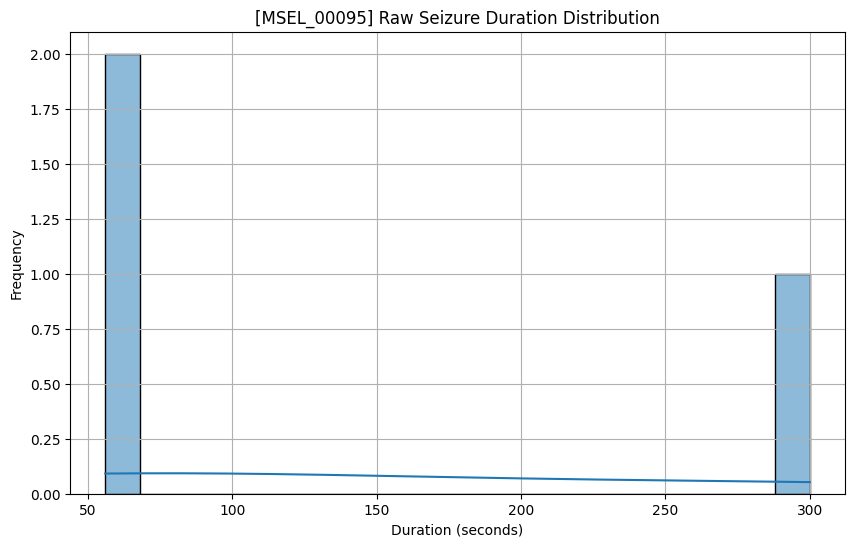

2025-06-09 05:44:24,572 - INFO - [MSEL_00095] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:24,575 - INFO - [MSEL_00095]   Preprocessed Seizure Durations (seconds) Stats:
count      3.000000
mean     141.333333
std      137.540297
min       56.000000
25%       62.000000
50%       68.000000
75%      184.000000
max      300.000000
dtype: float64


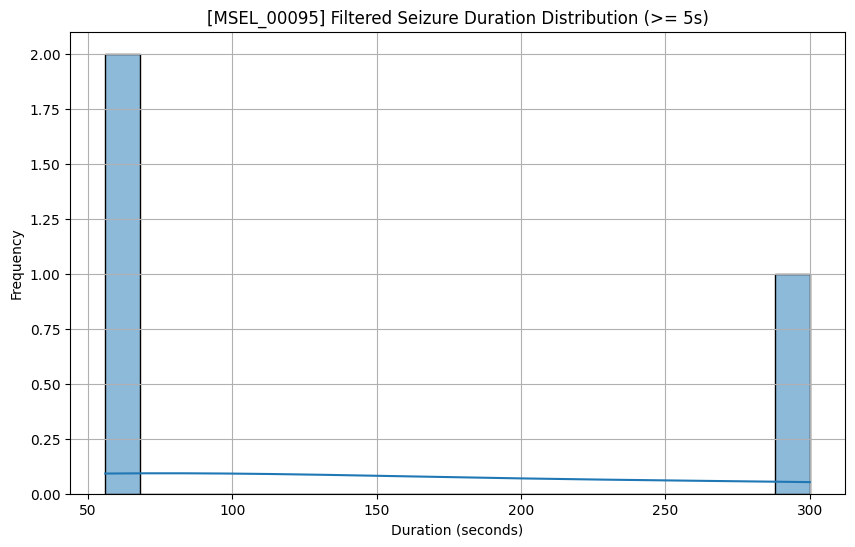

2025-06-09 05:44:24,689 - INFO - [MSEL_00095] --- End Seizure Duration Analysis ---
2025-06-09 05:44:24,689 - INFO - 
[MSEL_00172] --- Seizure Duration Analysis ---
2025-06-09 05:44:24,690 - INFO - [MSEL_00172] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:24,692 - INFO - [MSEL_00172]   Raw Seizure Durations (seconds) Stats:
count     12.000000
mean     109.750000
std      187.174763
min        1.000000
25%        7.750000
50%       14.900000
75%       83.725000
max      474.800000
dtype: float64


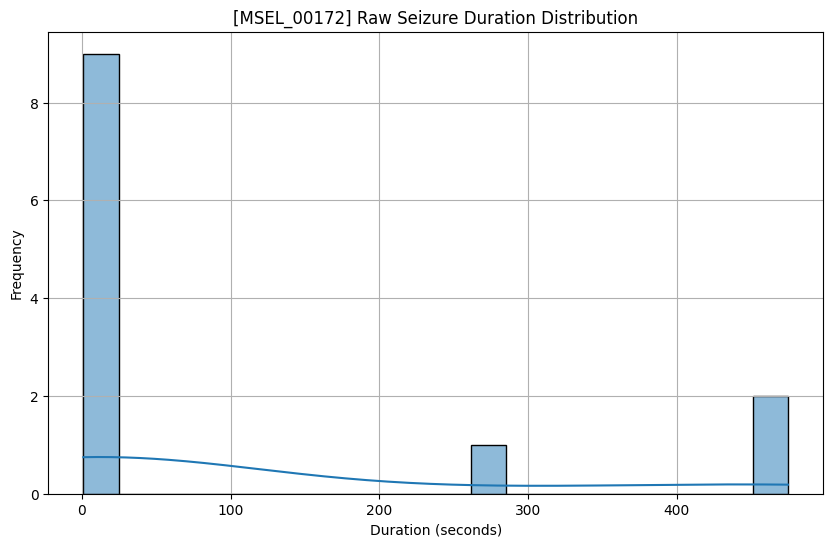

2025-06-09 05:44:24,783 - INFO - [MSEL_00172] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:24,785 - INFO - [MSEL_00172]   Preprocessed Seizure Durations (seconds) Stats:
count      7.000000
mean     184.057143
std      220.768913
min       10.000000
25%       15.550000
50%       18.100000
75%      377.200000
max      474.800000
dtype: float64


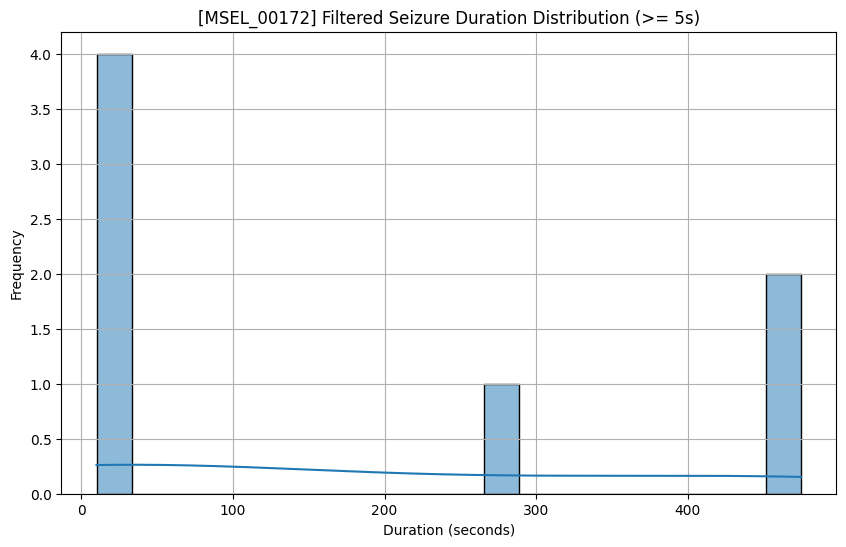

2025-06-09 05:44:24,893 - INFO - [MSEL_00172] --- End Seizure Duration Analysis ---
2025-06-09 05:44:24,894 - INFO - 
[MSEL_00182] --- Seizure Duration Analysis ---
2025-06-09 05:44:24,894 - INFO - [MSEL_00182] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:24,897 - INFO - [MSEL_00182]   Raw Seizure Durations (seconds) Stats:
count      4.000000
mean     272.900000
std      353.736343
min       68.600000
25%       76.250000
50%      110.900000
75%      307.550000
max      801.200000
dtype: float64


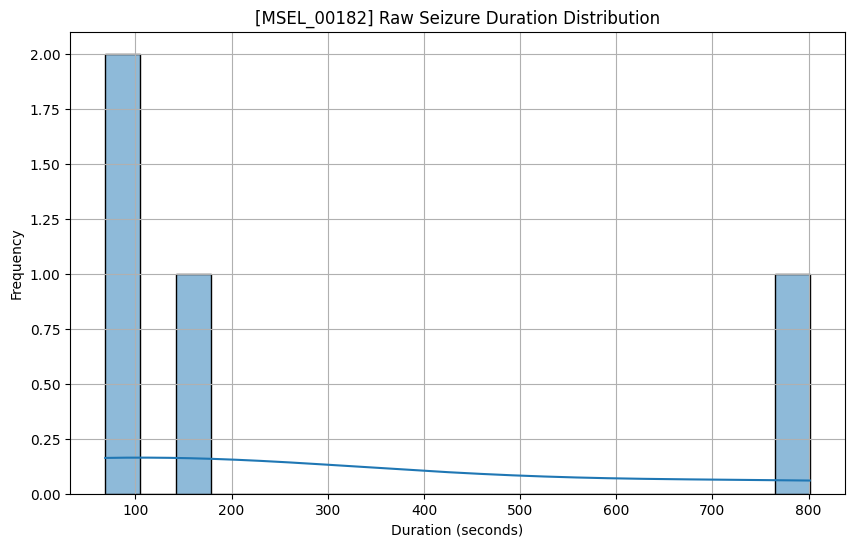

2025-06-09 05:44:25,012 - INFO - [MSEL_00182] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:25,015 - INFO - [MSEL_00182]   Preprocessed Seizure Durations (seconds) Stats:
count      2.000000
mean     440.000000
std      510.813939
min       78.800000
25%      259.400000
50%      440.000000
75%      620.600000
max      801.200000
dtype: float64


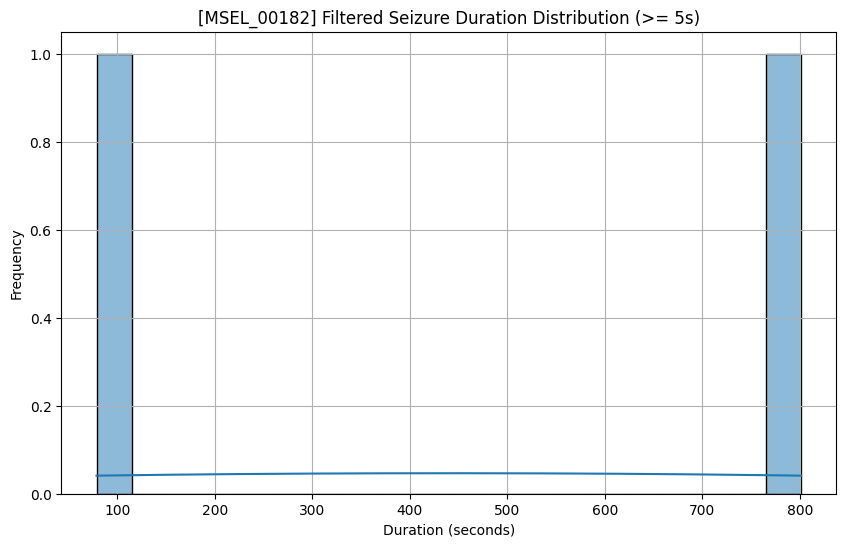

2025-06-09 05:44:25,118 - INFO - [MSEL_00182] --- End Seizure Duration Analysis ---
2025-06-09 05:44:25,118 - INFO - 
[MSEL_00501] --- Seizure Duration Analysis ---
2025-06-09 05:44:25,119 - INFO - [MSEL_00501] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:25,121 - INFO - [MSEL_00501]   Raw Seizure Durations (seconds) Stats:
count     17.000000
mean     172.047059
std      135.160623
min       38.700000
25%       58.400000
50%      162.000000
75%      238.000000
max      572.000000
dtype: float64


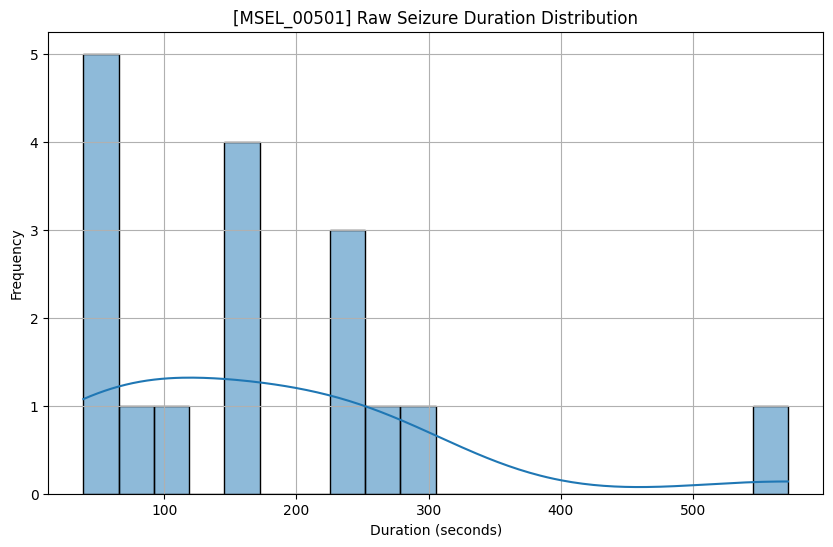

2025-06-09 05:44:25,237 - INFO - [MSEL_00501] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:25,240 - INFO - [MSEL_00501]   Preprocessed Seizure Durations (seconds) Stats:
count      9.000000
mean     155.566667
std       90.766844
min       42.000000
25%       58.400000
50%      165.200000
75%      231.000000
max      293.000000
dtype: float64


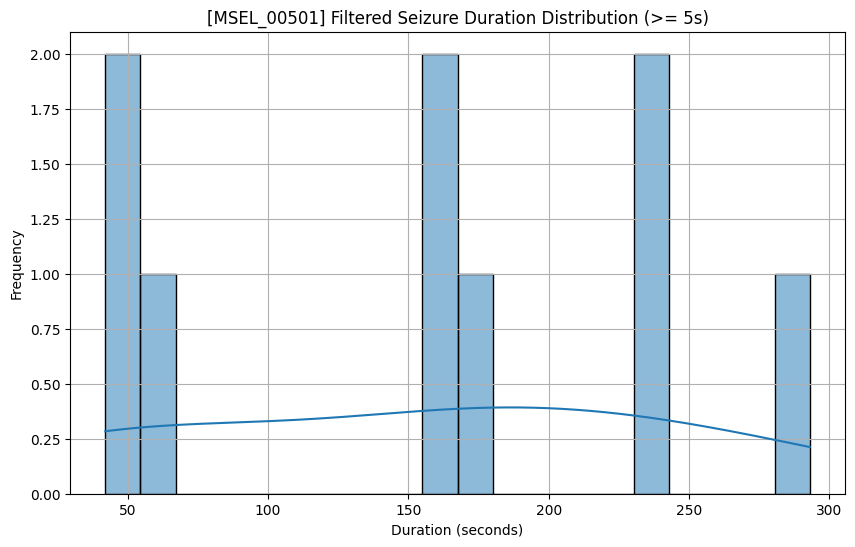

2025-06-09 05:44:25,372 - INFO - [MSEL_00501] --- End Seizure Duration Analysis ---
2025-06-09 05:44:25,373 - INFO - 
[MSEL_00502] --- Seizure Duration Analysis ---
2025-06-09 05:44:25,373 - INFO - [MSEL_00502] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:25,375 - INFO - [MSEL_00502]   Raw Seizure Durations (seconds) Stats:
count      6.000000
mean      77.433333
std       43.304996
min       37.200000
25%       42.125000
50%       66.650000
75%      106.025000
max      141.000000
dtype: float64


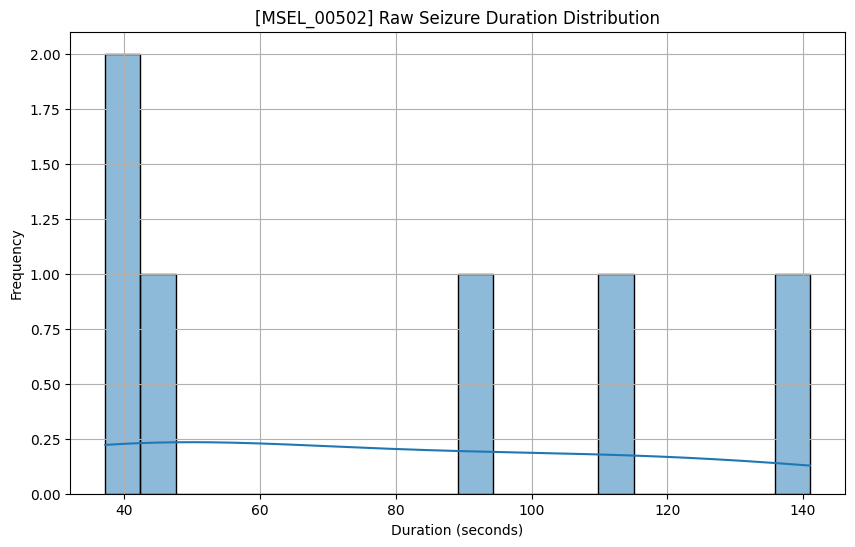

2025-06-09 05:44:25,497 - INFO - [MSEL_00502] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:25,499 - INFO - [MSEL_00502]   Preprocessed Seizure Durations (seconds) Stats:
count      6.000000
mean      77.433333
std       43.304996
min       37.200000
25%       42.125000
50%       66.650000
75%      106.025000
max      141.000000
dtype: float64


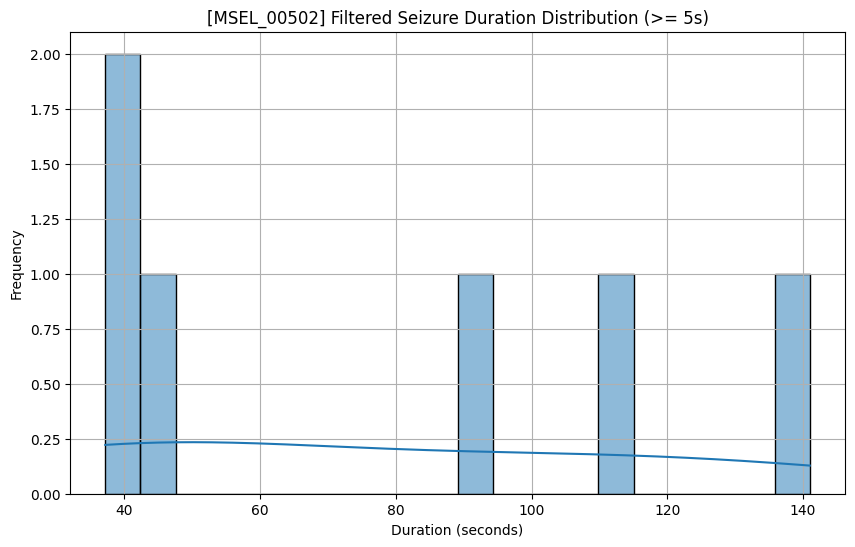

2025-06-09 05:44:25,613 - INFO - [MSEL_00502] --- End Seizure Duration Analysis ---
2025-06-09 05:44:25,613 - INFO - 
[MSEL_00764] --- Seizure Duration Analysis ---
2025-06-09 05:44:25,614 - INFO - [MSEL_00764] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:25,616 - INFO - [MSEL_00764]   Raw Seizure Durations (seconds) Stats:
count      6.000000
mean     107.416667
std       35.050559
min       55.600000
25%       83.775000
50%      117.150000
75%      132.675000
max      144.100000
dtype: float64


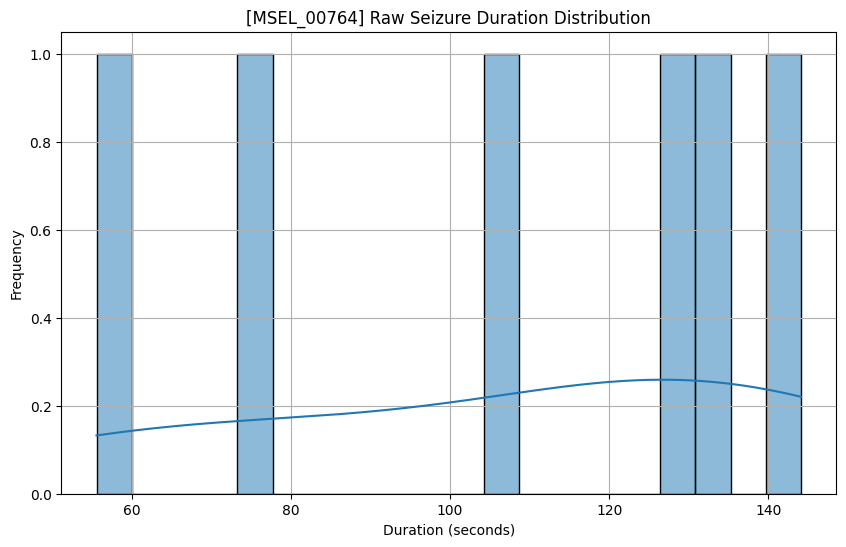

2025-06-09 05:44:25,726 - INFO - [MSEL_00764] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:25,729 - INFO - [MSEL_00764]   Preprocessed Seizure Durations (seconds) Stats:
count      6.000000
mean     107.416667
std       35.050559
min       55.600000
25%       83.775000
50%      117.150000
75%      132.675000
max      144.100000
dtype: float64


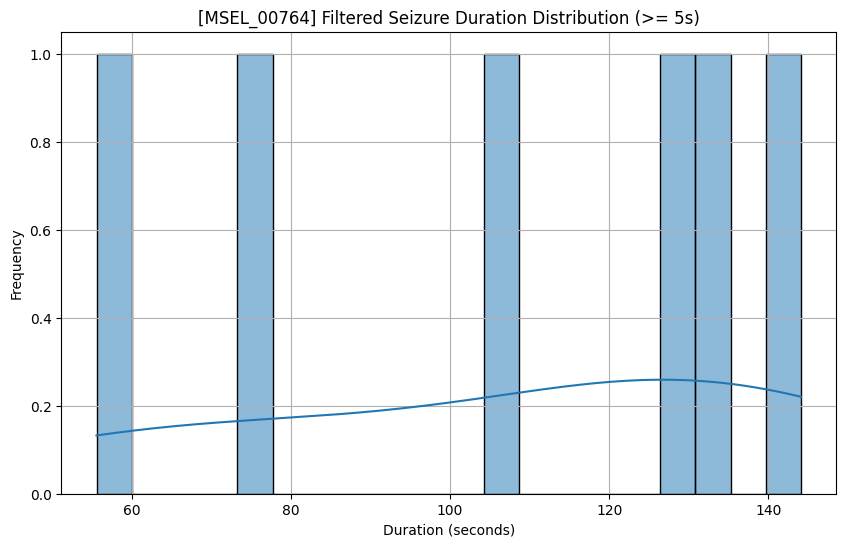

2025-06-09 05:44:25,835 - INFO - [MSEL_00764] --- End Seizure Duration Analysis ---
2025-06-09 05:44:25,835 - INFO - 
[MSEL_01097] --- Seizure Duration Analysis ---
2025-06-09 05:44:25,836 - INFO - [MSEL_01097] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:25,838 - INFO - [MSEL_01097]   Raw Seizure Durations (seconds) Stats:
count      7.000000
mean      79.857143
std       35.362073
min       46.000000
25%       58.000000
50%       73.000000
75%       88.000000
max      148.000000
dtype: float64


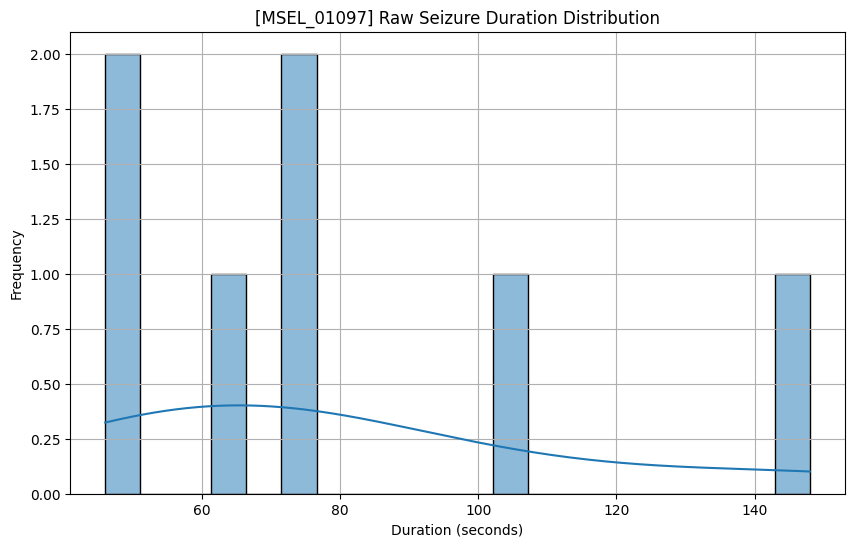

2025-06-09 05:44:25,946 - INFO - [MSEL_01097] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:25,949 - INFO - [MSEL_01097]   Preprocessed Seizure Durations (seconds) Stats:
count      3.00000
mean      98.00000
std       43.30127
min       73.00000
25%       73.00000
50%       73.00000
75%      110.50000
max      148.00000
dtype: float64


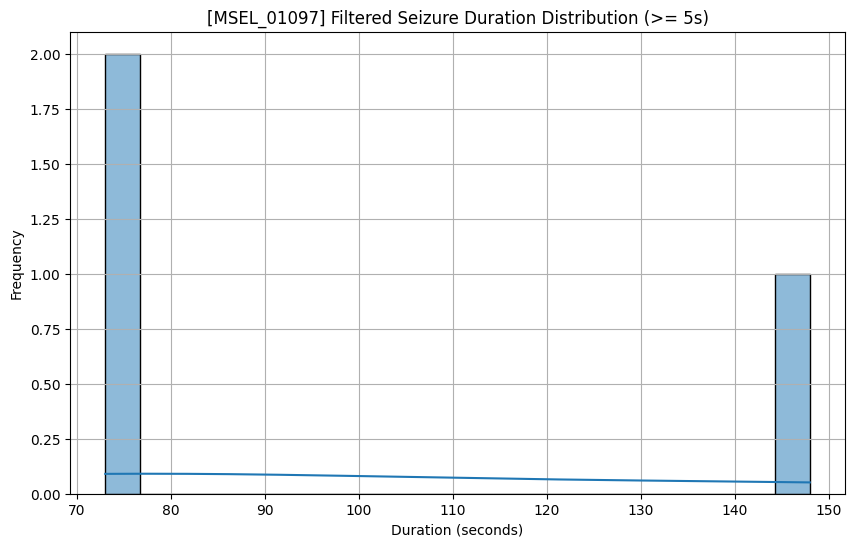

2025-06-09 05:44:27,509 - INFO - [MSEL_01097] --- End Seizure Duration Analysis ---
2025-06-09 05:44:27,510 - INFO - 
[MSEL_01110] --- Seizure Duration Analysis ---
2025-06-09 05:44:27,510 - INFO - [MSEL_01110] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:27,513 - INFO - [MSEL_01110]   Raw Seizure Durations (seconds) Stats:
count     12.000000
mean     220.000000
std      143.095645
min       82.000000
25%      131.500000
50%      200.500000
75%      275.500000
max      611.000000
dtype: float64


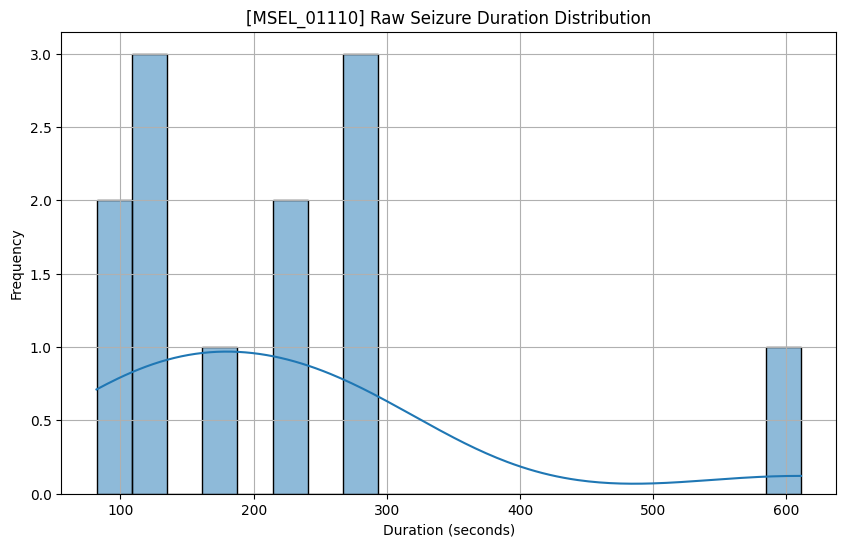

2025-06-09 05:44:27,621 - INFO - [MSEL_01110] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:27,624 - INFO - [MSEL_01110]   Preprocessed Seizure Durations (seconds) Stats:
count      4.000000
mean     202.750000
std       78.635764
min       90.000000
25%      190.500000
50%      224.000000
75%      236.250000
max      273.000000
dtype: float64


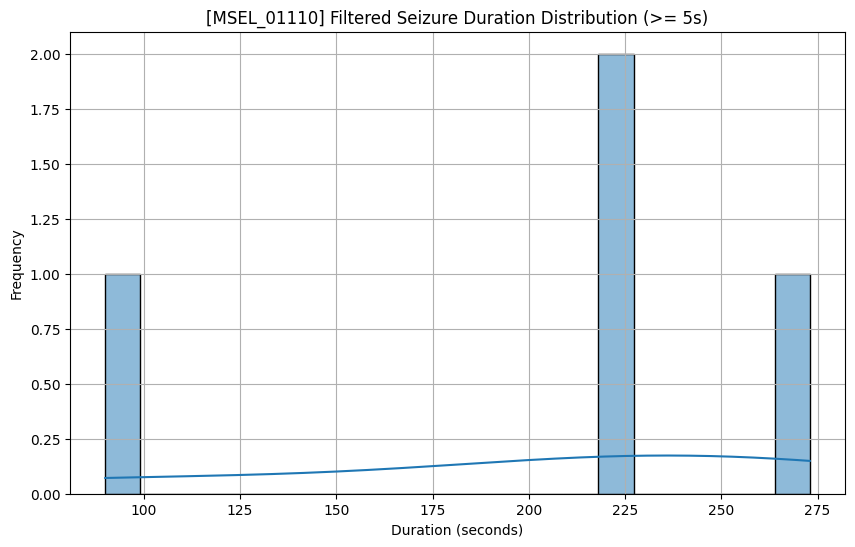

2025-06-09 05:44:27,730 - INFO - [MSEL_01110] --- End Seizure Duration Analysis ---
2025-06-09 05:44:27,731 - INFO - 
[MSEL_01462] --- Seizure Duration Analysis ---
2025-06-09 05:44:27,731 - INFO - [MSEL_01462] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:27,734 - INFO - [MSEL_01462]   Raw Seizure Durations (seconds) Stats:
count     3.000000
mean     33.133333
std      40.068109
min      10.000000
25%      10.000000
50%      10.000000
75%      44.700000
max      79.400000
dtype: float64


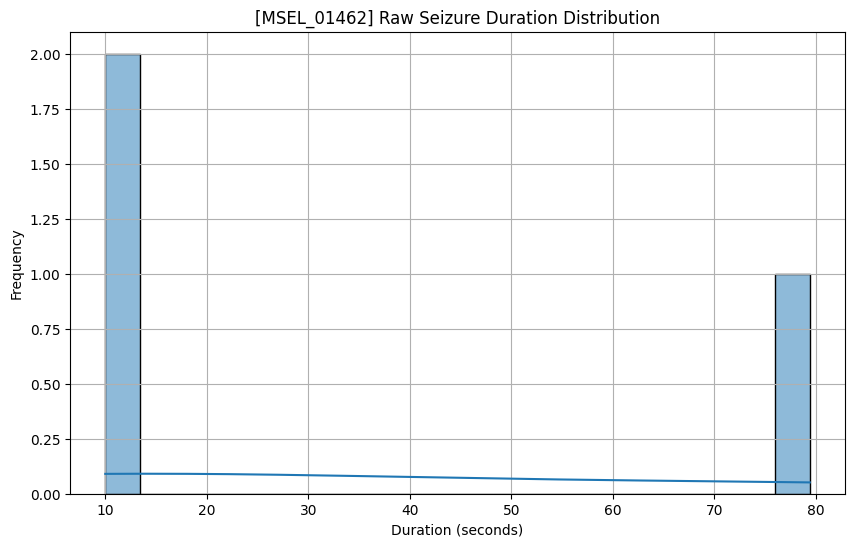

2025-06-09 05:44:27,844 - INFO - [MSEL_01462] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:27,847 - INFO - [MSEL_01462]   Preprocessed Seizure Durations (seconds) Stats:
count     2.000000
mean     44.700000
std      49.073211
min      10.000000
25%      27.350000
50%      44.700000
75%      62.050000
max      79.400000
dtype: float64


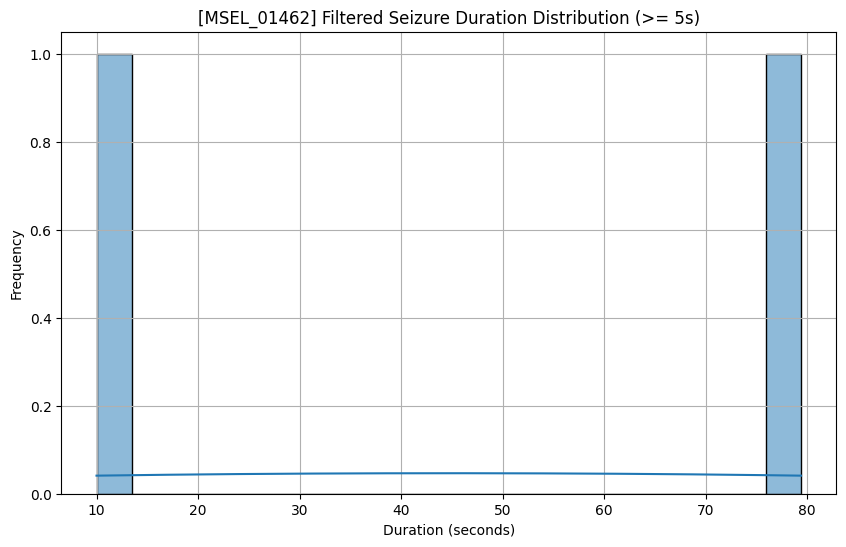

2025-06-09 05:44:27,946 - INFO - [MSEL_01462] --- End Seizure Duration Analysis ---
2025-06-09 05:44:27,947 - INFO - 
[MSEL_01550] --- Seizure Duration Analysis ---
2025-06-09 05:44:27,947 - INFO - [MSEL_01550] Analysis BEFORE Preprocessing (Raw Annotations):
2025-06-09 05:44:27,949 - INFO - [MSEL_01550]   Raw Seizure Durations (seconds) Stats:
count      5.000000
mean     101.900000
std       32.305418
min       66.000000
25%       80.000000
50%      102.900000
75%      110.400000
max      150.200000
dtype: float64


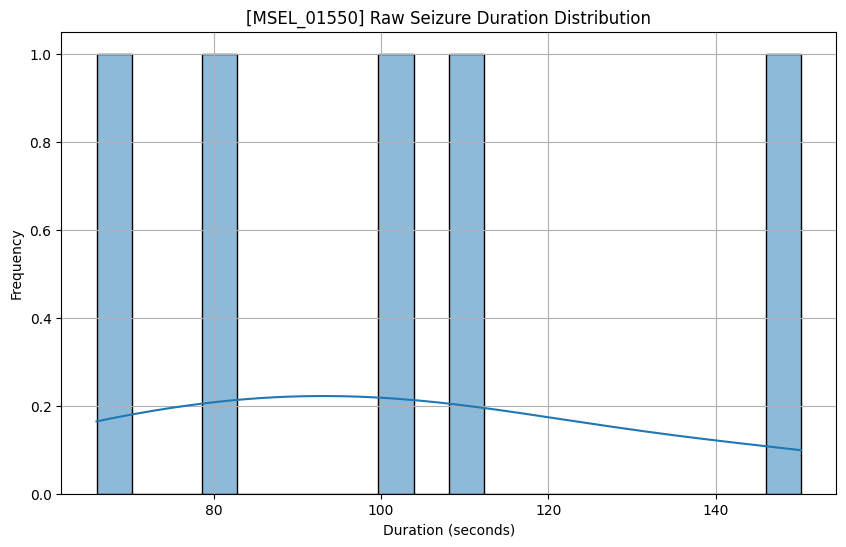

2025-06-09 05:44:28,041 - INFO - [MSEL_01550] Analysis AFTER Preprocessing (Filtered Annotations >= 5s):
2025-06-09 05:44:28,044 - INFO - [MSEL_01550]   Preprocessed Seizure Durations (seconds) Stats:
count      2.000000
mean     108.100000
std       59.538391
min       66.000000
25%       87.050000
50%      108.100000
75%      129.150000
max      150.200000
dtype: float64


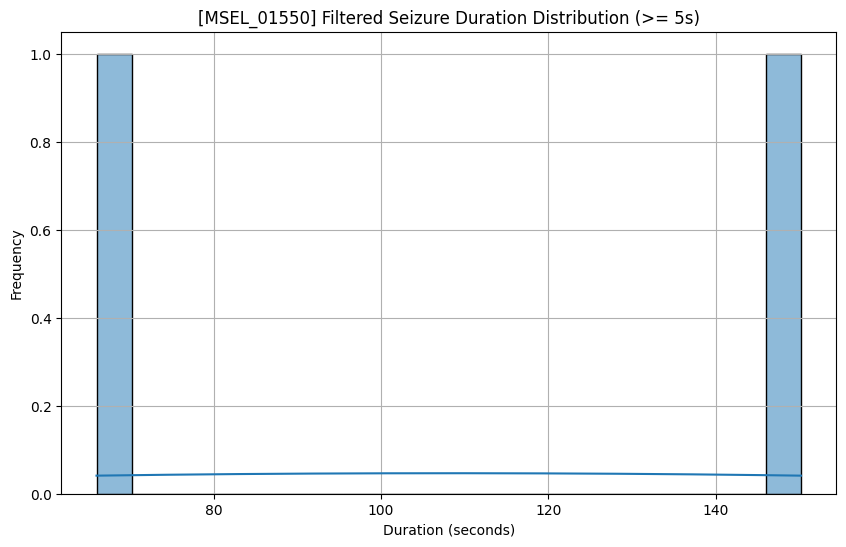

2025-06-09 05:44:28,136 - INFO - [MSEL_01550] --- End Seizure Duration Analysis ---
2025-06-09 05:44:28,136 - INFO - 
--- Finished Seizure Duration Analysis ---


In [ ]:
logging.info("\n--- Starting Seizure Duration Analysis (Before & After Preprocessing) for loaded patients ---")

if patient_annotations_list: # Iterate through patients for whom annotations were loaded
    for patient_annotation_data in patient_annotations_list:
        patient_id = patient_annotation_data['patient_id']
        raw_annotations_df = patient_annotation_data['raw_annotations_df']
        preprocessed_annotations_df = patient_annotation_data['preprocessed_annotations_df']


        logging.info(f"\n[{patient_id}] --- Seizure Duration Analysis ---")

        # --- Before Preprocessing Analysis ---
        logging.info(f"[{patient_id}] Analysis BEFORE Preprocessing (Raw Annotations):")
        if raw_annotations_df is not None and not raw_annotations_df.empty:
            raw_seizure_durations_sec = (raw_annotations_df['end_time'] - raw_annotations_df['start_time']).dt.total_seconds()
            if not raw_seizure_durations_sec.empty:
                logging.info(f"[{patient_id}]   Raw Seizure Durations (seconds) Stats:\n{raw_seizure_durations_sec.describe()}")
                plt.figure(figsize=(10, 6))
                sns.histplot(raw_seizure_durations_sec, bins=20, kde=True)
                plt.title(f'[{patient_id}] Raw Seizure Duration Distribution')
                plt.xlabel('Duration (seconds)')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()
            else:
                 logging.info(f"[{patient_id}]   No raw seizure durations to analyze.")
        else:
            logging.info(f"[{patient_id}]   No raw seizure annotations available for analysis.")


        # --- After Preprocessing Analysis ---
        logging.info(f"[{patient_id}] Analysis AFTER Preprocessing (Filtered Annotations >= {MIN_SEIZURE_DURATION_SECONDS}s):")
        if preprocessed_annotations_df is not None and not preprocessed_annotations_df.empty:
            preprocessed_seizure_durations_sec = (preprocessed_annotations_df['end_time'] - preprocessed_annotations_df['start_time']).dt.total_seconds()
            if not preprocessed_seizure_durations_sec.empty:
                logging.info(f"[{patient_id}]   Preprocessed Seizure Durations (seconds) Stats:\n{preprocessed_seizure_durations_sec.describe()}")
                plt.figure(figsize=(10, 6))
                sns.histplot(preprocessed_seizure_durations_sec, bins=20, kde=True)
                plt.title(f'[{patient_id}] Filtered Seizure Duration Distribution (>= {MIN_SEIZURE_DURATION_SECONDS}s)')
                plt.xlabel('Duration (seconds)')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()
            else:
                 logging.info(f"[{patient_id}]   No preprocessed seizure durations to analyze.")
        else:
            logging.info(f"[{patient_id}]   No preprocessed seizure annotations available for analysis.")

        logging.info(f"[{patient_id}] --- End Seizure Duration Analysis ---")


else:
     logging.warning("\nNo patient annotations loaded to perform analysis on.")

logging.info("\n--- Finished Seizure Duration Analysis ---")


#### Syncrhonize, Merge and Scale

2025-06-09 21:24:45,755 - INFO - 
--- Starting Synchronizing, Merging, and Scaling for loaded patients ---
2025-06-09 21:24:45,758 - INFO - 
[MSEL_00095] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:24:45,758 - INFO - [MSEL_00095] Performing full data preprocessing...
2025-06-09 21:24:45,759 - INFO - [MSEL_00095] Starting raw sensor data preprocessing...
2025-06-09 21:24:55,681 - INFO - [MSEL_00095]   Replacing 711 zero values with NaN for HR.
2025-06-09 21:24:56,097 - INFO - [MSEL_00095]   Interpolating 711 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:25:13,224 - INFO - [MSEL_00095]   Finished preprocessing for HR. New shape: (71008860, 1)
2025-06

                                            HR
timestamp                                     
2018-11-27 20:12:26+00:00            71.003082
2018-11-27 20:12:26.007812500+00:00  71.003082
2018-11-27 20:12:26.015625+00:00     71.003082
2018-11-27 20:12:26.023437500+00:00  71.003082
2018-11-27 20:12:26.031250+00:00     71.003082


2025-06-09 21:25:44,816 - INFO - [MSEL_00095]   Original Frequency (approx): 118.34494400910954 Hz
2025-06-09 21:25:44,818 - INFO - 
[MSEL_00095]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2018-11-27 20:12:16+00:00            0.000277
2018-11-27 20:12:16.007812500+00:00  0.000277
2018-11-27 20:12:16.015625+00:00     0.000277
2018-11-27 20:12:16.023437500+00:00  0.000277
2018-11-27 20:12:16.031250+00:00     0.000554


2025-06-09 21:25:49,909 - INFO - [MSEL_00095]   Original Frequency (approx): 118.33760589363202 Hz
2025-06-09 21:25:49,914 - INFO - 
[MSEL_00095]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2018-11-27 20:12:16+00:00            27.450285
2018-11-27 20:12:16.007812500+00:00  27.450285
2018-11-27 20:12:16.015625+00:00     27.450285
2018-11-27 20:12:16.023437500+00:00  27.450285
2018-11-27 20:12:16.031250+00:00     27.450285


2025-06-09 21:26:00,276 - INFO - [MSEL_00095]   Original Frequency (approx): 118.30495537362128 Hz
2025-06-09 21:26:00,297 - INFO - 
[MSEL_00095]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2018-11-27 20:12:16+00:00            60.005798
2018-11-27 20:12:16.007812500+00:00  60.251846
2018-11-27 20:12:16.015625+00:00     60.497925
2018-11-27 20:12:16.023437500+00:00  60.743988
2018-11-27 20:12:16.031250+00:00     60.990040


2025-06-09 21:26:07,600 - INFO - [MSEL_00095]   Original Frequency (approx): 118.34553726132329 Hz
2025-06-09 21:26:07,648 - INFO - [MSEL_00095] Starting synchronize and merge data process...
2025-06-09 21:26:07,649 - INFO - [MSEL_00095] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:26:23,645 - INFO - [MSEL_00095] Resampled sensor HR to 1Hz. Shape: (600016, 1)
2025-06-09 21:26:23,737 - INFO - [MSEL_00095] HR Resample Summary: Total=600016, NaNs=45257, Zeros=0
2025-06-09 21:26:23,741 - INFO - [MSEL_00095] Interpolating 45257 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:26:23,895 - INFO - [MSEL_00095] Finished interpolation for resampled sensor HR.
2025-06-09 21:26:37,92

                                  HR
timestamp                           
2018-11-27 20:12:26+00:00  71.003082
2018-11-27 20:12:27+00:00  67.862564
2018-11-27 20:12:28+00:00  66.944801
2018-11-27 20:12:29+00:00  70.617020
2018-11-27 20:12:30+00:00  72.335144
                                EDA
timestamp                          
2018-11-27 20:12:16+00:00  0.013842
2018-11-27 20:12:17+00:00  0.022912
2018-11-27 20:12:18+00:00  0.022702
2018-11-27 20:12:19+00:00  0.023517
2018-11-27 20:12:20+00:00  0.022531
                                TEMP
timestamp                           
2018-11-27 20:12:16+00:00  27.450285
2018-11-27 20:12:17+00:00  27.450285
2018-11-27 20:12:18+00:00  27.447840
2018-11-27 20:12:19+00:00  27.430210
2018-11-27 20:12:20+00:00  27.430210
                                 ACC
timestamp                           
2018-11-27 20:12:16+00:00  60.990372
2018-11-27 20:12:17+00:00  61.029800
2018-11-27 20:12:18+00:00  60.931023
2018-11-27 20:12:19+00:00  61.083668
2018-11-

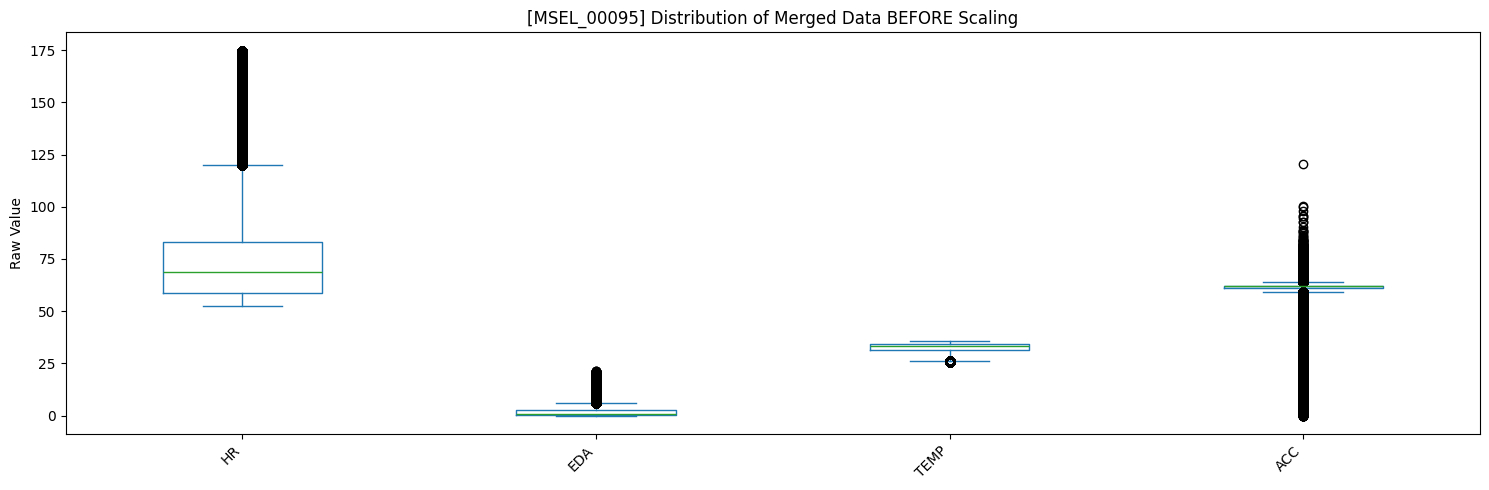

2025-06-09 21:26:49,513 - INFO - [MSEL_00095] Synchronized and scaled data stored.
2025-06-09 21:26:49,642 - INFO - 
[MSEL_00172] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:26:49,642 - INFO - [MSEL_00172] Performing full data preprocessing...
2025-06-09 21:26:49,643 - INFO - [MSEL_00172] Starting raw sensor data preprocessing...
2025-06-09 21:26:51,232 - INFO - [MSEL_00172]   Replacing 305 zero values with NaN for HR.
2025-06-09 21:26:51,375 - INFO - [MSEL_00172]   Interpolating 305 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:26:52,994 - INFO - [MSEL_00172]   Finished preprocessing for HR. New shape: (32226944, 1)
2025-06-09 21:26:54,622 - INFO 

                                            HR
timestamp                                     
2019-04-26 19:42:58+00:00            56.002586
2019-04-26 19:42:58.007812500+00:00  56.000221
2019-04-26 19:42:58.015625+00:00     55.995499
2019-04-26 19:42:58.023437500+00:00  55.990780
2019-04-26 19:42:58.031250+00:00     55.988422


2025-06-09 21:26:58,880 - INFO - [MSEL_00172]   Original Frequency (approx): 127.97204441039757 Hz
2025-06-09 21:26:58,881 - INFO - 
[MSEL_00172]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-04-26 19:42:48.007812500+00:00  0.000164
2019-04-26 19:42:48.015625+00:00     0.000273
2019-04-26 19:42:48.023437500+00:00  0.000383
2019-04-26 19:42:48.031250+00:00     0.000492
2019-04-26 19:42:48.039062500+00:00  0.000602


2025-06-09 21:26:59,749 - INFO - [MSEL_00172]   Original Frequency (approx): 127.85345957229818 Hz
2025-06-09 21:26:59,751 - INFO - 
[MSEL_00172]   TEMP (Before Resampling):


                                         TEMP
timestamp                                    
2019-04-26 19:42:48+00:00            34.76989
2019-04-26 19:42:48.007812500+00:00  34.76989
2019-04-26 19:42:48.015625+00:00     34.76989
2019-04-26 19:42:48.023437500+00:00  34.76989
2019-04-26 19:42:48.031250+00:00     34.76989


2025-06-09 21:27:01,098 - INFO - [MSEL_00172]   Original Frequency (approx): 127.59985605190073 Hz
2025-06-09 21:27:01,099 - INFO - 
[MSEL_00172]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-04-26 19:42:48+00:00            63.379272
2019-04-26 19:42:48.007812500+00:00  63.189835
2019-04-26 19:42:48.015625+00:00     63.005142
2019-04-26 19:42:48.023437500+00:00  62.829880
2019-04-26 19:42:48.031250+00:00     62.654648


2025-06-09 21:27:01,991 - INFO - [MSEL_00172]   Original Frequency (approx): 127.96893198389827 Hz
2025-06-09 21:27:01,992 - INFO - [MSEL_00172] Starting synchronize and merge data process...
2025-06-09 21:27:01,993 - INFO - [MSEL_00172] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:27:03,096 - INFO - [MSEL_00172] Resampled sensor HR to 1Hz. Shape: (251828, 1)
2025-06-09 21:27:03,099 - INFO - [MSEL_00172] HR Resample Summary: Total=251828, NaNs=55, Zeros=0
2025-06-09 21:27:03,102 - INFO - [MSEL_00172] Interpolating 55 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:27:03,122 - INFO - [MSEL_00172] Finished interpolation for resampled sensor HR.
2025-06-09 21:27:04,408 - IN

                                  HR
timestamp                           
2019-04-26 19:42:58+00:00  55.755478
2019-04-26 19:42:59+00:00  54.923122
2019-04-26 19:43:00+00:00  53.921795
2019-04-26 19:43:01+00:00  53.255470
2019-04-26 19:43:02+00:00  52.919239
                                EDA
timestamp                          
2019-04-26 19:42:48+00:00  0.014464
2019-04-26 19:42:49+00:00  0.023897
2019-04-26 19:42:50+00:00  0.023903
2019-04-26 19:42:51+00:00  0.023407
2019-04-26 19:42:52+00:00  0.024682
                                TEMP
timestamp                           
2019-04-26 19:42:48+00:00  34.769890
2019-04-26 19:42:49+00:00  34.767479
2019-04-26 19:42:50+00:00  34.749905
2019-04-26 19:42:51+00:00  34.741413
2019-04-26 19:42:52+00:00  34.677479
                                 ACC
timestamp                           
2019-04-26 19:42:48+00:00  63.228088
2019-04-26 19:42:49+00:00  63.256248
2019-04-26 19:42:50+00:00  63.294617
2019-04-26 19:42:51+00:00  63.358776
2019-04-

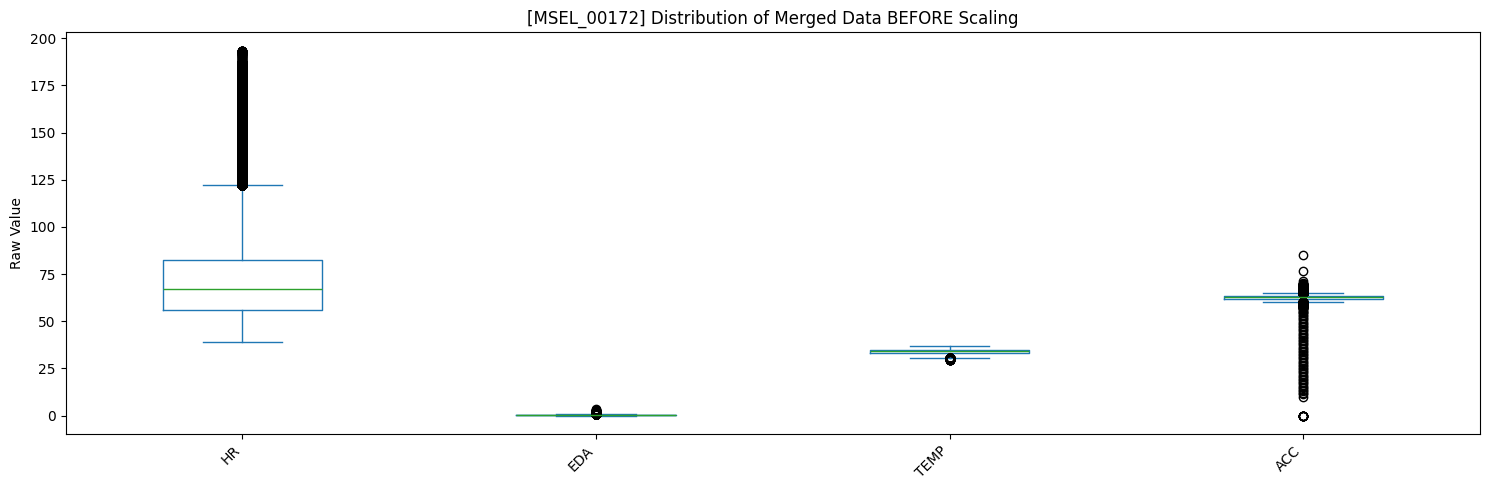

2025-06-09 21:27:07,590 - INFO - [MSEL_00172] Synchronized and scaled data stored.
2025-06-09 21:27:07,746 - INFO - 
[MSEL_00182] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:27:07,746 - INFO - [MSEL_00182] Performing full data preprocessing...
2025-06-09 21:27:07,747 - INFO - [MSEL_00182] Starting raw sensor data preprocessing...
2025-06-09 21:27:10,061 - INFO - [MSEL_00182]   Replacing 1325 zero values with NaN for HR.
2025-06-09 21:27:10,229 - INFO - [MSEL_00182]   Interpolating 1325 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:27:12,178 - INFO - [MSEL_00182]   Finished preprocessing for HR. New shape: (38932735, 1)
2025-06-09 21:27:14,269 - INF

                                             HR
timestamp                                      
2019-07-25 19:07:43+00:00            115.999741
2019-07-25 19:07:43.007812500+00:00  115.990746
2019-07-25 19:07:43.015625+00:00     115.983574
2019-07-25 19:07:43.023437500+00:00  115.976395
2019-07-25 19:07:43.031250+00:00     115.967407


2025-06-09 21:27:19,641 - INFO - [MSEL_00182]   Original Frequency (approx): 126.86176848166798 Hz
2025-06-09 21:27:19,643 - INFO - 
[MSEL_00182]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-07-25 19:07:46.750000+00:00     0.003603
2019-07-25 19:07:46.757812500+00:00  0.024500
2019-07-25 19:07:46.765625+00:00     0.045157
2019-07-25 19:07:46.773437500+00:00  0.065814
2019-07-25 19:07:46.781250+00:00     0.086711


2025-06-09 21:27:21,535 - INFO - [MSEL_00182]   Original Frequency (approx): 124.60451087560608 Hz
2025-06-09 21:27:21,538 - INFO - 
[MSEL_00182]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2019-07-25 19:07:33+00:00            24.790272
2019-07-25 19:07:33.007812500+00:00  24.790272
2019-07-25 19:07:33.015625+00:00     24.790272
2019-07-25 19:07:33.023437500+00:00  24.790272
2019-07-25 19:07:33.031250+00:00     24.790272


2025-06-09 21:27:22,948 - INFO - [MSEL_00182]   Original Frequency (approx): 126.82535725565177 Hz
2025-06-09 21:27:22,949 - INFO - 
[MSEL_00182]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-07-25 19:07:33+00:00            57.392048
2019-07-25 19:07:33.007812500+00:00  58.248627
2019-07-25 19:07:33.015625+00:00     59.115829
2019-07-25 19:07:33.023437500+00:00  59.999008
2019-07-25 19:07:33.031250+00:00     60.882187


2025-06-09 21:27:25,347 - INFO - [MSEL_00182]   Original Frequency (approx): 126.85952850821059 Hz
2025-06-09 21:27:25,354 - INFO - [MSEL_00182] Starting synchronize and merge data process...
2025-06-09 21:27:25,355 - INFO - [MSEL_00182] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:27:27,777 - INFO - [MSEL_00182] Resampled sensor HR to 1Hz. Shape: (306891, 1)
2025-06-09 21:27:27,797 - INFO - [MSEL_00182] HR Resample Summary: Total=306891, NaNs=2729, Zeros=0
2025-06-09 21:27:27,799 - INFO - [MSEL_00182] Interpolating 2729 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:27:27,854 - INFO - [MSEL_00182] Finished interpolation for resampled sensor HR.
2025-06-09 21:27:29,645 

                                   HR
timestamp                            
2019-07-25 19:07:43+00:00  115.502983
2019-07-25 19:07:44+00:00  115.162781
2019-07-25 19:07:45+00:00  113.429100
2019-07-25 19:07:46+00:00  105.202354
2019-07-25 19:07:47+00:00   96.833275
                                EDA
timestamp                          
2019-07-25 19:07:46+00:00  0.325173
2019-07-25 19:07:47+00:00  0.795957
2019-07-25 19:07:48+00:00  0.619419
2019-07-25 19:07:49+00:00  0.165360
2019-07-25 19:07:50+00:00  0.164917
                                TEMP
timestamp                           
2019-07-25 19:07:33+00:00  24.790272
2019-07-25 19:07:34+00:00  24.644747
2019-07-25 19:07:35+00:00  23.595146
2019-07-25 19:07:36+00:00  23.620602
2019-07-25 19:07:37+00:00  23.545568
                                  ACC
timestamp                            
2019-07-25 19:07:33+00:00   63.742897
2019-07-25 19:07:34+00:00   98.064072
2019-07-25 19:07:35+00:00  145.944382
2019-07-25 19:07:36+00:00  153.83

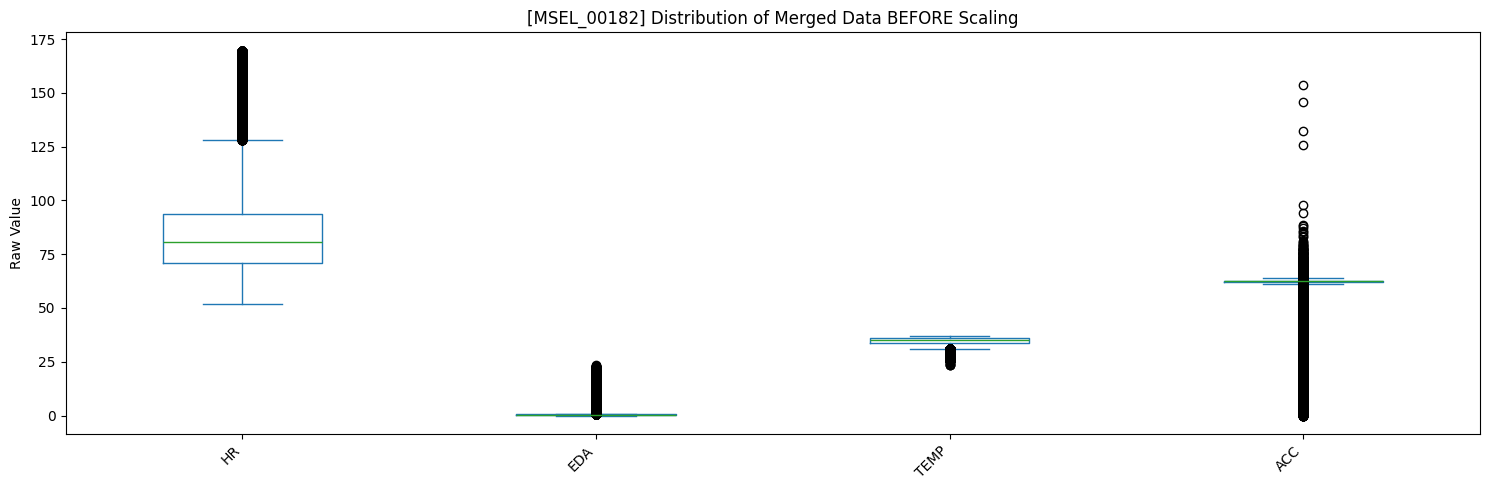

2025-06-09 21:27:34,866 - INFO - [MSEL_00182] Synchronized and scaled data stored.
2025-06-09 21:27:34,999 - INFO - 
[MSEL_00501] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:27:34,999 - INFO - [MSEL_00501] Performing full data preprocessing...
2025-06-09 21:27:35,000 - INFO - [MSEL_00501] Starting raw sensor data preprocessing...
2025-06-09 21:27:37,288 - INFO - [MSEL_00501]   Replacing 265 zero values with NaN for HR.
2025-06-09 21:27:37,437 - INFO - [MSEL_00501]   Interpolating 265 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:27:39,256 - INFO - [MSEL_00501]   Finished preprocessing for HR. New shape: (34775267, 1)
2025-06-09 21:27:40,688 - INFO 

                                            HR
timestamp                                     
2019-05-02 20:49:04+00:00            83.003731
2019-05-02 20:49:04.007812500+00:00  82.994331
2019-05-02 20:49:04.015625+00:00     82.986816
2019-05-02 20:49:04.023437500+00:00  82.979294
2019-05-02 20:49:04.031250+00:00     82.971779


2025-06-09 21:27:46,738 - INFO - [MSEL_00501]   Original Frequency (approx): 123.67617528351987 Hz
2025-06-09 21:27:46,739 - INFO - 
[MSEL_00501]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-05-02 20:48:54.007812500+00:00  0.001391
2019-05-02 20:48:54.015625+00:00     0.002434
2019-05-02 20:48:54.023437500+00:00  0.003824
2019-05-02 20:48:54.031250+00:00     0.004867
2019-05-02 20:48:54.039062500+00:00  0.006258


2025-06-09 21:27:47,671 - INFO - [MSEL_00501]   Original Frequency (approx): 123.67283070127448 Hz
2025-06-09 21:27:47,672 - INFO - 
[MSEL_00501]   TEMP (Before Resampling):


                                         TEMP
timestamp                                    
2019-05-02 20:48:54+00:00            31.47016
2019-05-02 20:48:54.007812500+00:00  31.47016
2019-05-02 20:48:54.015625+00:00     31.47016
2019-05-02 20:48:54.023437500+00:00  31.47016
2019-05-02 20:48:54.031250+00:00     31.47016


2025-06-09 21:27:48,812 - INFO - [MSEL_00501]   Original Frequency (approx): 123.66337774009372 Hz
2025-06-09 21:27:48,814 - INFO - 
[MSEL_00501]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-05-02 20:48:54+00:00            63.108597
2019-05-02 20:48:54.007812500+00:00  63.108597
2019-05-02 20:48:54.015625+00:00     63.108597
2019-05-02 20:48:54.023437500+00:00  63.108597
2019-05-02 20:48:54.031250+00:00     63.108597


2025-06-09 21:27:50,011 - INFO - [MSEL_00501]   Original Frequency (approx): 123.67717755069111 Hz
2025-06-09 21:27:50,012 - INFO - [MSEL_00501] Starting synchronize and merge data process...
2025-06-09 21:27:50,013 - INFO - [MSEL_00501] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:27:51,247 - INFO - [MSEL_00501] Resampled sensor HR to 1Hz. Shape: (281180, 1)
2025-06-09 21:27:51,251 - INFO - [MSEL_00501] HR Resample Summary: Total=281180, NaNs=9498, Zeros=0
2025-06-09 21:27:51,253 - INFO - [MSEL_00501] Interpolating 9498 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:27:51,279 - INFO - [MSEL_00501] Finished interpolation for resampled sensor HR.
2025-06-09 21:27:52,542 

                                  HR
timestamp                           
2019-05-02 20:49:04+00:00  82.506714
2019-05-02 20:49:05+00:00  82.002060
2019-05-02 20:49:06+00:00  82.498871
2019-05-02 20:49:07+00:00  83.994942
2019-05-02 20:49:08+00:00  85.003304
                                EDA
timestamp                          
2019-05-02 20:48:54+00:00  0.053481
2019-05-02 20:48:55+00:00  0.071967
2019-05-02 20:48:56+00:00  0.072456
2019-05-02 20:48:57+00:00  0.072437
2019-05-02 20:48:58+00:00  0.072399
                                TEMP
timestamp                           
2019-05-02 20:48:54+00:00  31.470160
2019-05-02 20:48:55+00:00  31.470160
2019-05-02 20:48:56+00:00  31.467730
2019-05-02 20:48:57+00:00  31.450115
2019-05-02 20:48:58+00:00  31.447693
                                 ACC
timestamp                           
2019-05-02 20:48:54+00:00  63.207790
2019-05-02 20:48:55+00:00  63.218460
2019-05-02 20:48:56+00:00  63.213249
2019-05-02 20:48:57+00:00  63.179218
2019-05-

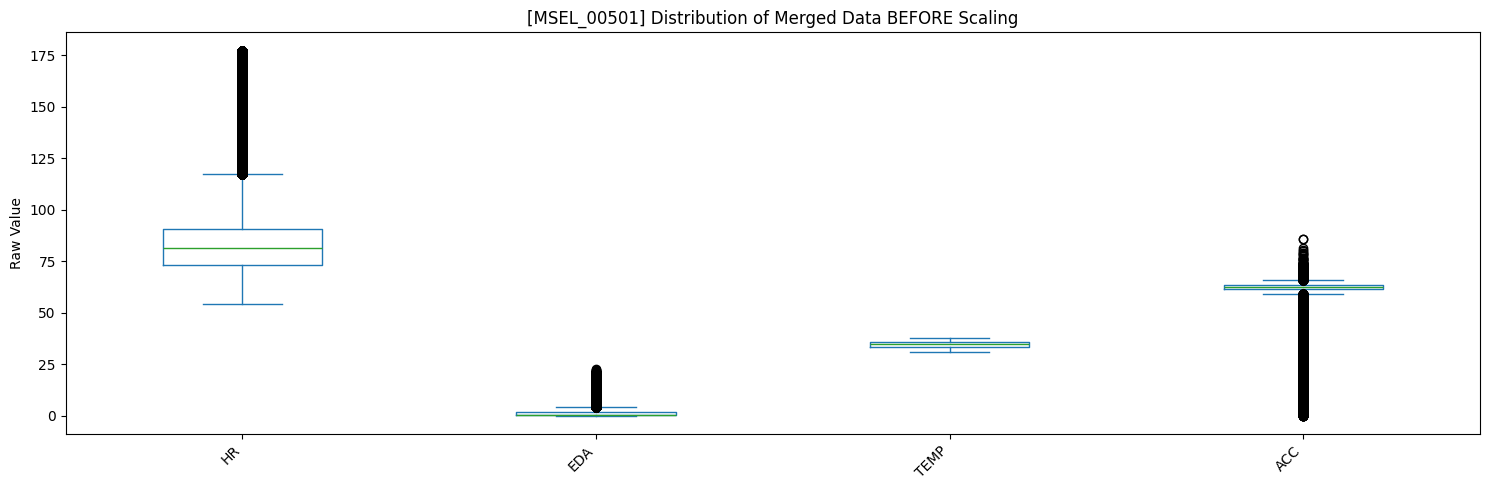

2025-06-09 21:27:55,756 - INFO - [MSEL_00501] Synchronized and scaled data stored.
2025-06-09 21:27:55,883 - INFO - 
[MSEL_00502] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:27:55,884 - INFO - [MSEL_00502] Performing full data preprocessing...
2025-06-09 21:27:55,884 - INFO - [MSEL_00502] Starting raw sensor data preprocessing...
2025-06-09 21:27:56,861 - INFO - [MSEL_00502]   Replacing 51 zero values with NaN for HR.
2025-06-09 21:27:56,951 - INFO - [MSEL_00502]   Interpolating 51 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:27:57,968 - INFO - [MSEL_00502]   Finished preprocessing for HR. New shape: (22181120, 1)
2025-06-09 21:27:58,891 - INFO - 

                                            HR
timestamp                                     
2019-03-02 13:23:58+00:00            82.002136
2019-03-02 13:23:58.007812500+00:00  81.944305
2019-03-02 13:23:58.015625+00:00     81.884659
2019-03-02 13:23:58.023437500+00:00  81.826828
2019-03-02 13:23:58.031250+00:00     81.768982


2025-06-09 21:28:02,698 - INFO - [MSEL_00502]   Original Frequency (approx): 128.0 Hz
2025-06-09 21:28:02,699 - INFO - 
[MSEL_00502]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-03-02 13:23:48+00:00            0.000549
2019-03-02 13:23:48.007812500+00:00  0.004939
2019-03-02 13:23:48.015625+00:00     0.009879
2019-03-02 13:23:48.023437500+00:00  0.014269
2019-03-02 13:23:48.031250+00:00     0.019208


2025-06-09 21:28:03,319 - INFO - [MSEL_00502]   Original Frequency (approx): 128.0 Hz
2025-06-09 21:28:03,320 - INFO - 
[MSEL_00502]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2019-03-02 13:23:48+00:00            29.190317
2019-03-02 13:23:48.007812500+00:00  29.190317
2019-03-02 13:23:48.015625+00:00     29.190317
2019-03-02 13:23:48.023437500+00:00  29.190317
2019-03-02 13:23:48.031250+00:00     29.190317


2025-06-09 21:28:03,942 - INFO - [MSEL_00502]   Original Frequency (approx): 128.0 Hz
2025-06-09 21:28:03,943 - INFO - 
[MSEL_00502]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-03-02 13:23:48+00:00            61.455429
2019-03-02 13:23:48.007812500+00:00  61.534149
2019-03-02 13:23:48.015625+00:00     61.617477
2019-03-02 13:23:48.023437500+00:00  61.700836
2019-03-02 13:23:48.031250+00:00     61.784180


2025-06-09 21:28:04,579 - INFO - [MSEL_00502]   Original Frequency (approx): 128.0 Hz
2025-06-09 21:28:04,581 - INFO - [MSEL_00502] Starting synchronize and merge data process...
2025-06-09 21:28:04,581 - INFO - [MSEL_00502] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:28:05,427 - INFO - [MSEL_00502] Resampled sensor HR to 1Hz. Shape: (173290, 1)
2025-06-09 21:28:05,430 - INFO - [MSEL_00502] HR Resample Summary: Total=173290, NaNs=0, Zeros=0
2025-06-09 21:28:05,432 - INFO - [MSEL_00502] Finished interpolation for resampled sensor HR.
2025-06-09 21:28:06,220 - INFO - [MSEL_00502] Resampled sensor EDA to 1Hz. Shape: (173290, 1)
2025-06-09 21:28:06,224 - INFO - [MSEL_00502] EDA Resample Summary: Total=173290, NaNs=0, Zeros=0
2025-06-09 21:28:06,226 - INFO - [MSEL_00502] Finished interpolation for resampled sensor EDA.
2025-06-09 21:28:07,050 - INFO - [MSEL_00502] Resampled sensor TEMP to 1Hz. Shape: (173282, 1)
2025-06-09 21:28:07,053 - INFO - [MSEL_00502] T

                                  HR
timestamp                           
2019-03-02 13:23:58+00:00  78.281998
2019-03-02 13:23:59+00:00  76.238998
2019-03-02 13:24:00+00:00  76.142410
2019-03-02 13:24:01+00:00  75.319252
2019-03-02 13:24:02+00:00  78.352280
                                EDA
timestamp                          
2019-03-02 13:23:48+00:00  0.162473
2019-03-02 13:23:49+00:00  0.206348
2019-03-02 13:23:50+00:00  0.225886
2019-03-02 13:23:51+00:00  0.233762
2019-03-02 13:23:52+00:00  0.236468
                                TEMP
timestamp                           
2019-03-02 13:23:48+00:00  29.190317
2019-03-02 13:23:49+00:00  29.192728
2019-03-02 13:23:50+00:00  29.210230
2019-03-02 13:23:51+00:00  29.210230
2019-03-02 13:23:52+00:00  29.207806
                                 ACC
timestamp                           
2019-03-02 13:23:48+00:00  61.422852
2019-03-02 13:23:49+00:00  60.867546
2019-03-02 13:23:50+00:00  61.493820
2019-03-02 13:23:51+00:00  61.378216
2019-03-

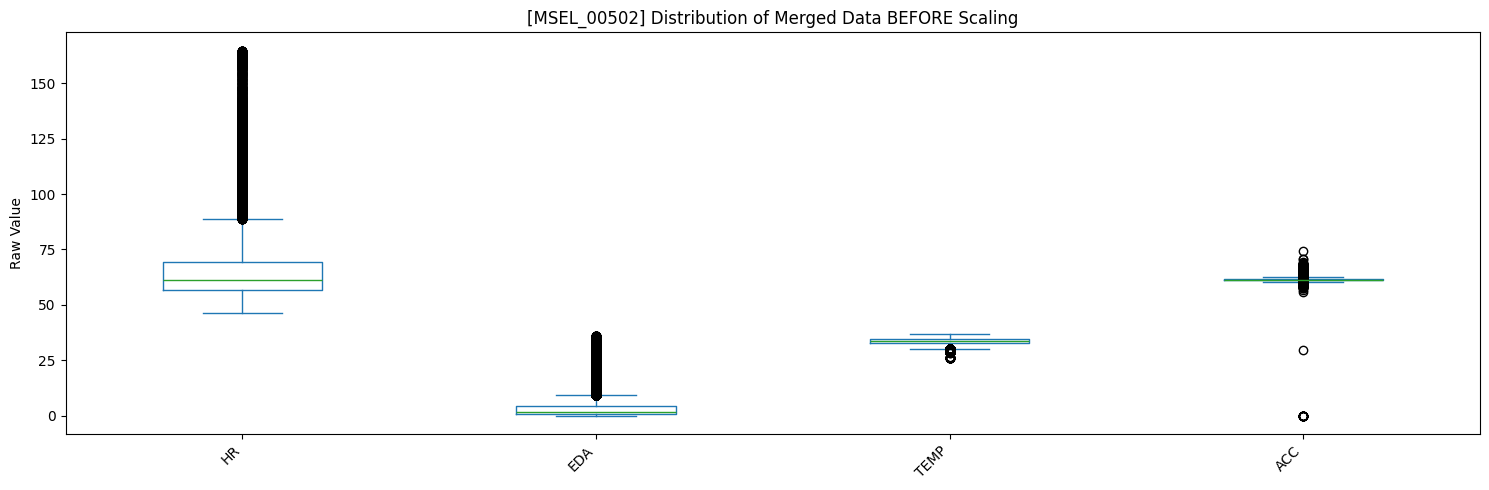

2025-06-09 21:28:08,399 - INFO - [MSEL_00502] Synchronized and scaled data stored.
2025-06-09 21:28:08,551 - INFO - 
[MSEL_00764] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:28:08,551 - INFO - [MSEL_00764] Performing full data preprocessing...
2025-06-09 21:28:08,552 - INFO - [MSEL_00764] Starting raw sensor data preprocessing...
2025-06-09 21:28:10,570 - INFO - [MSEL_00764]   Replacing 459 zero values with NaN for HR.
2025-06-09 21:28:10,704 - INFO - [MSEL_00764]   Interpolating 459 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:28:12,271 - INFO - [MSEL_00764]   Finished preprocessing for HR. New shape: (30709392, 1)
2025-06-09 21:28:14,381 - INFO 

                                            HR
timestamp                                     
2019-09-23 16:00:47+00:00            91.003296
2019-09-23 16:00:47.007812500+00:00  90.943565
2019-09-23 16:00:47.015625+00:00     90.885574
2019-09-23 16:00:47.023437500+00:00  90.827591
2019-09-23 16:00:47.031250+00:00     90.767853


2025-06-09 21:28:22,590 - INFO - [MSEL_00764]   Original Frequency (approx): 123.39478786940839 Hz
2025-06-09 21:28:22,592 - INFO - 
[MSEL_00764]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-09-23 16:02:20.242187500+00:00  0.000550
2019-09-23 16:02:20.250000+00:00     0.001834
2019-09-23 16:02:20.257812500+00:00  0.003301
2019-09-23 16:02:20.265625+00:00     0.004769
2019-09-23 16:02:20.273437500+00:00  0.006053


2025-06-09 21:28:24,092 - INFO - [MSEL_00764]   Original Frequency (approx): 123.27995229183507 Hz
2025-06-09 21:28:24,093 - INFO - 
[MSEL_00764]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2019-09-23 16:00:37+00:00            21.890272
2019-09-23 16:00:37.007812500+00:00  21.890272
2019-09-23 16:00:37.015625+00:00     21.890272
2019-09-23 16:00:37.023437500+00:00  21.890272
2019-09-23 16:00:37.031250+00:00     21.890272


2025-06-09 21:28:25,142 - INFO - [MSEL_00764]   Original Frequency (approx): 123.0534782256013 Hz
2025-06-09 21:28:25,143 - INFO - 
[MSEL_00764]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-09-23 16:00:37+00:00            63.192917
2019-09-23 16:00:37.007812500+00:00  63.214035
2019-09-23 16:00:37.015625+00:00     63.235168
2019-09-23 16:00:37.023437500+00:00  63.256287
2019-09-23 16:00:37.031250+00:00     63.277420


2025-06-09 21:28:26,312 - INFO - [MSEL_00764]   Original Frequency (approx): 123.3779132814853 Hz
2025-06-09 21:28:26,313 - INFO - [MSEL_00764] Starting synchronize and merge data process...
2025-06-09 21:28:26,314 - INFO - [MSEL_00764] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:28:27,347 - INFO - [MSEL_00764] Resampled sensor HR to 1Hz. Shape: (248872, 1)
2025-06-09 21:28:27,351 - INFO - [MSEL_00764] HR Resample Summary: Total=248872, NaNs=8952, Zeros=0
2025-06-09 21:28:27,352 - INFO - [MSEL_00764] Interpolating 8952 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:28:27,365 - INFO - [MSEL_00764] Finished interpolation for resampled sensor HR.
2025-06-09 21:28:28,552 -

                                  HR
timestamp                           
2019-09-23 16:00:47+00:00  87.281929
2019-09-23 16:00:48+00:00  86.231010
2019-09-23 16:00:49+00:00  87.390350
2019-09-23 16:00:50+00:00  88.555420
2019-09-23 16:00:51+00:00  90.375732
                                EDA
timestamp                          
2019-09-23 16:02:20+00:00  0.045309
2019-09-23 16:02:21+00:00  0.089470
2019-09-23 16:02:22+00:00  0.128280
2019-09-23 16:02:23+00:00  0.086950
2019-09-23 16:02:24+00:00  0.080076
                                TEMP
timestamp                           
2019-09-23 16:00:37+00:00  21.890272
2019-09-23 16:00:38+00:00  21.880583
2019-09-23 16:00:39+00:00  21.807890
2019-09-23 16:00:40+00:00  21.785509
2019-09-23 16:00:41+00:00  21.752733
                                 ACC
timestamp                           
2019-09-23 16:00:37+00:00  63.246841
2019-09-23 16:00:38+00:00  63.259964
2019-09-23 16:00:39+00:00  63.244987
2019-09-23 16:00:40+00:00  63.253281
2019-09-

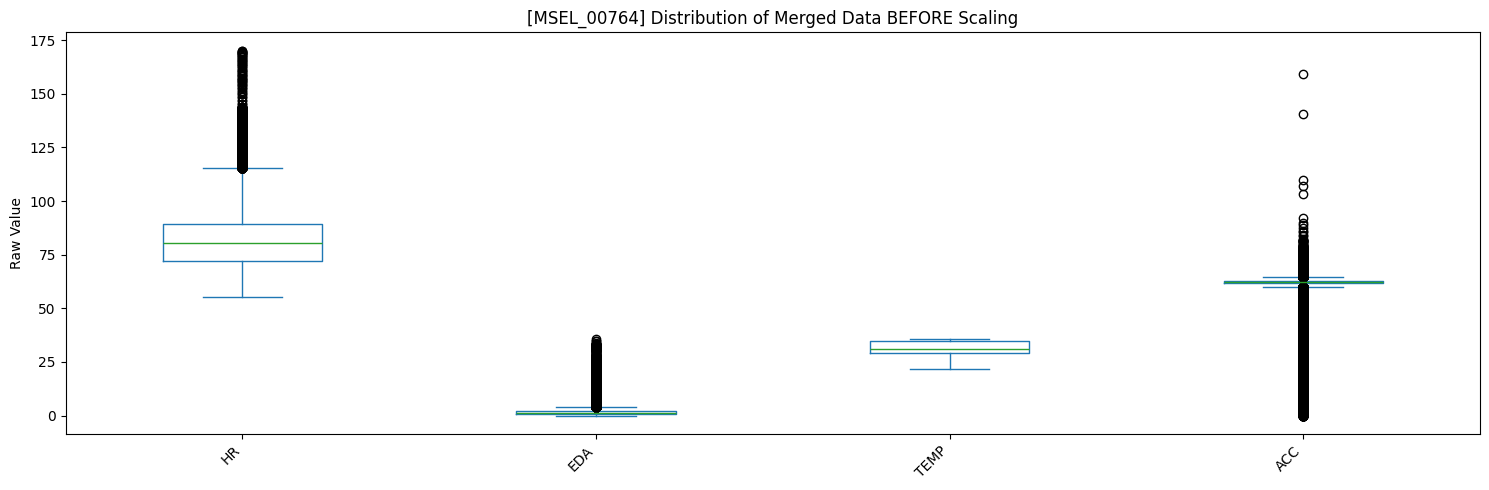

2025-06-09 21:28:31,787 - INFO - [MSEL_00764] Synchronized and scaled data stored.
2025-06-09 21:28:31,924 - INFO - 
[MSEL_01097] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:28:31,925 - INFO - [MSEL_01097] Performing full data preprocessing...
2025-06-09 21:28:31,925 - INFO - [MSEL_01097] Starting raw sensor data preprocessing...
2025-06-09 21:28:35,038 - INFO - [MSEL_01097]   Replacing 362 zero values with NaN for HR.
2025-06-09 21:28:35,283 - INFO - [MSEL_01097]   Interpolating 362 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:28:38,331 - INFO - [MSEL_01097]   Finished preprocessing for HR. New shape: (53923988, 1)
2025-06-09 21:28:42,184 - INFO 

                                            HR
timestamp                                     
2019-03-11 20:33:41+00:00            49.005501
2019-03-11 20:33:41.007812500+00:00  49.177868
2019-03-11 20:33:41.015625+00:00     49.353897
2019-03-11 20:33:41.023437500+00:00  49.529930
2019-03-11 20:33:41.031250+00:00     49.705963


2025-06-09 21:28:54,916 - INFO - [MSEL_01097]   Original Frequency (approx): 127.96388230179208 Hz
2025-06-09 21:28:54,917 - INFO - 
[MSEL_01097]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-03-11 20:33:31.007812500+00:00  0.000412
2019-03-11 20:33:31.015625+00:00     0.000412
2019-03-11 20:33:31.023437500+00:00  0.000412
2019-03-11 20:33:31.031250+00:00     0.000823
2019-03-11 20:33:31.039062500+00:00  0.000823


2025-06-09 21:28:57,103 - INFO - [MSEL_01097]   Original Frequency (approx): 127.66422179904336 Hz
2025-06-09 21:28:57,104 - INFO - 
[MSEL_01097]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2019-03-11 20:33:31+00:00            26.870201
2019-03-11 20:33:31.007812500+00:00  26.870201
2019-03-11 20:33:31.015625+00:00     26.870201
2019-03-11 20:33:31.023437500+00:00  26.870201
2019-03-11 20:33:31.031250+00:00     26.870201


2025-06-09 21:28:59,197 - INFO - [MSEL_01097]   Original Frequency (approx): 127.93106725174793 Hz
2025-06-09 21:28:59,198 - INFO - 
[MSEL_01097]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-03-11 20:33:31+00:00            62.533813
2019-03-11 20:33:31.007812500+00:00  62.487087
2019-03-11 20:33:31.015625+00:00     62.440384
2019-03-11 20:33:31.023437500+00:00  62.398865
2019-03-11 20:33:31.031250+00:00     62.352142


2025-06-09 21:29:01,558 - INFO - [MSEL_01097]   Original Frequency (approx): 127.94435406544297 Hz
2025-06-09 21:29:01,559 - INFO - [MSEL_01097] Starting synchronize and merge data process...
2025-06-09 21:29:01,559 - INFO - [MSEL_01097] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:29:09,485 - INFO - [MSEL_01097] Resampled sensor HR to 1Hz. Shape: (421401, 1)
2025-06-09 21:29:09,594 - INFO - [MSEL_01097] HR Resample Summary: Total=421401, NaNs=116, Zeros=0
2025-06-09 21:29:09,598 - INFO - [MSEL_01097] Interpolating 116 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:29:09,654 - INFO - [MSEL_01097] Finished interpolation for resampled sensor HR.
2025-06-09 21:29:12,120 - 

                                  HR
timestamp                           
2019-03-11 20:33:41+00:00  60.164810
2019-03-11 20:33:42+00:00  69.602753
2019-03-11 20:33:43+00:00  66.720276
2019-03-11 20:33:44+00:00  64.090889
2019-03-11 20:33:45+00:00  63.528812
                                EDA
timestamp                          
2019-03-11 20:33:31+00:00  0.014644
2019-03-11 20:33:32+00:00  0.024184
2019-03-11 20:33:33+00:00  0.024692
2019-03-11 20:33:34+00:00  0.024692
2019-03-11 20:33:35+00:00  0.024554
                                TEMP
timestamp                           
2019-03-11 20:33:31+00:00  26.870201
2019-03-11 20:33:32+00:00  26.870201
2019-03-11 20:33:33+00:00  26.877493
2019-03-11 20:33:34+00:00  26.869448
2019-03-11 20:33:35+00:00  26.384071
                                 ACC
timestamp                           
2019-03-11 20:33:31+00:00  63.334415
2019-03-11 20:33:32+00:00  63.571800
2019-03-11 20:33:33+00:00  63.874149
2019-03-11 20:33:34+00:00  63.387333
2019-03-

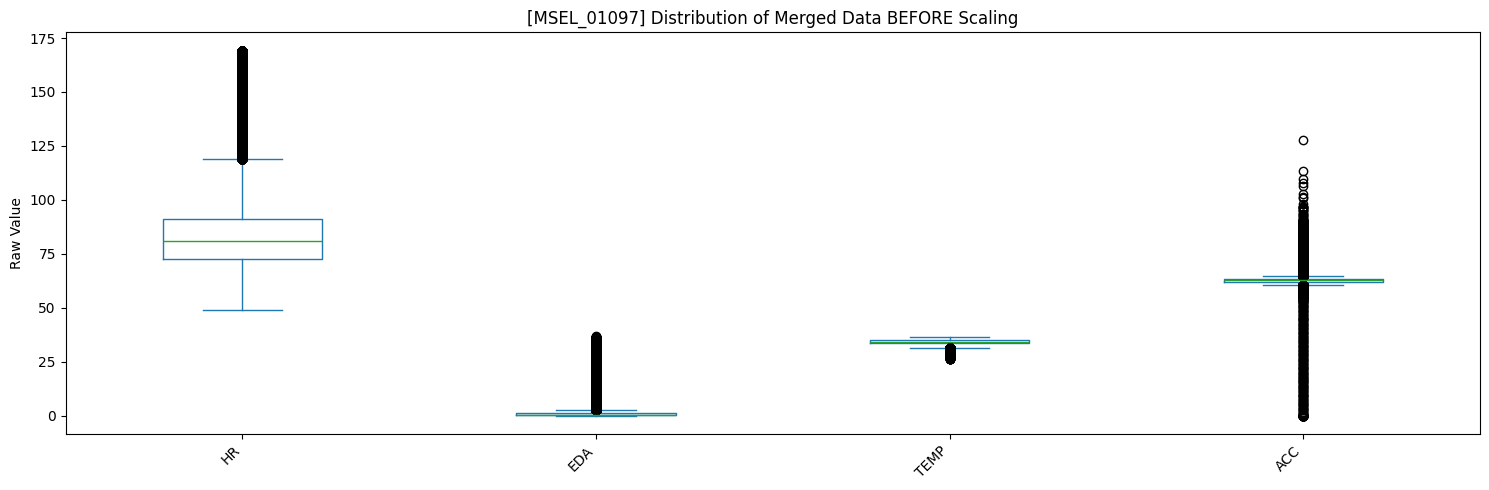

2025-06-09 21:29:18,834 - INFO - [MSEL_01097] Synchronized and scaled data stored.
2025-06-09 21:29:18,965 - INFO - 
[MSEL_01110] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:29:18,965 - INFO - [MSEL_01110] Performing full data preprocessing...
2025-06-09 21:29:18,966 - INFO - [MSEL_01110] Starting raw sensor data preprocessing...
2025-06-09 21:29:19,754 - INFO - [MSEL_01110]   Replacing 138 zero values with NaN for HR.
2025-06-09 21:29:19,858 - INFO - [MSEL_01110]   Interpolating 138 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:29:21,097 - INFO - [MSEL_01110]   Finished preprocessing for HR. New shape: (24783770, 1)
2025-06-09 21:29:22,027 - INFO 

                                            HR
timestamp                                     
2019-06-06 19:46:32+00:00            81.999489
2019-06-06 19:46:32.007812500+00:00  81.917236
2019-06-06 19:46:32.015625+00:00     81.834991
2019-06-06 19:46:32.023437500+00:00  81.752747
2019-06-06 19:46:32.031250+00:00     81.671738


2025-06-09 21:29:25,075 - INFO - [MSEL_01110]   Original Frequency (approx): 127.64907508290212 Hz
2025-06-09 21:29:25,076 - INFO - 
[MSEL_01110]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-06-06 19:46:22.007812500+00:00  0.003495
2019-06-06 19:46:22.015625+00:00     0.006990
2019-06-06 19:46:22.023437500+00:00  0.010485
2019-06-06 19:46:22.031250+00:00     0.013979
2019-06-06 19:46:22.039062500+00:00  0.017474


2025-06-09 21:29:25,789 - INFO - [MSEL_01110]   Original Frequency (approx): 127.6482097828971 Hz
2025-06-09 21:29:25,790 - INFO - 
[MSEL_01110]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2019-06-06 19:46:22+00:00            29.590136
2019-06-06 19:46:22.007812500+00:00  29.590136
2019-06-06 19:46:22.015625+00:00     29.590136
2019-06-06 19:46:22.023437500+00:00  29.590136
2019-06-06 19:46:22.031250+00:00     29.590136


2025-06-09 21:29:26,529 - INFO - [MSEL_01110]   Original Frequency (approx): 127.64964163911311 Hz
2025-06-09 21:29:26,530 - INFO - 
[MSEL_01110]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-06-06 19:46:22+00:00            65.726639
2019-06-06 19:46:22.007812500+00:00  65.963715
2019-06-06 19:46:22.015625+00:00     66.210281
2019-06-06 19:46:22.023437500+00:00  66.471069
2019-06-06 19:46:22.031250+00:00     66.741348


2025-06-09 21:29:27,224 - INFO - [MSEL_01110]   Original Frequency (approx): 127.66571123346168 Hz
2025-06-09 21:29:27,225 - INFO - [MSEL_01110] Starting synchronize and merge data process...
2025-06-09 21:29:27,227 - INFO - [MSEL_01110] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:29:28,080 - INFO - [MSEL_01110] Resampled sensor HR to 1Hz. Shape: (194156, 1)
2025-06-09 21:29:28,083 - INFO - [MSEL_01110] HR Resample Summary: Total=194156, NaNs=529, Zeros=0
2025-06-09 21:29:28,085 - INFO - [MSEL_01110] Interpolating 529 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:29:28,094 - INFO - [MSEL_01110] Finished interpolation for resampled sensor HR.
2025-06-09 21:29:28,938 - 

                                  HR
timestamp                           
2019-06-06 19:46:32+00:00  76.792160
2019-06-06 19:46:33+00:00  77.701775
2019-06-06 19:46:34+00:00  87.099739
2019-06-06 19:46:35+00:00  87.645035
2019-06-06 19:46:36+00:00  82.603439
                                EDA
timestamp                          
2019-06-06 19:46:22+00:00  0.123187
2019-06-06 19:46:23+00:00  0.152016
2019-06-06 19:46:24+00:00  0.139337
2019-06-06 19:46:25+00:00  0.033511
2019-06-06 19:46:26+00:00  0.115475
                                TEMP
timestamp                           
2019-06-06 19:46:22+00:00  29.590136
2019-06-06 19:46:23+00:00  29.585293
2019-06-06 19:46:24+00:00  29.555023
2019-06-06 19:46:25+00:00  29.585285
2019-06-06 19:46:26+00:00  29.550180
                                 ACC
timestamp                           
2019-06-06 19:46:22+00:00  63.158524
2019-06-06 19:46:23+00:00  63.015682
2019-06-06 19:46:24+00:00  63.330929
2019-06-06 19:46:25+00:00  62.913879
2019-06-

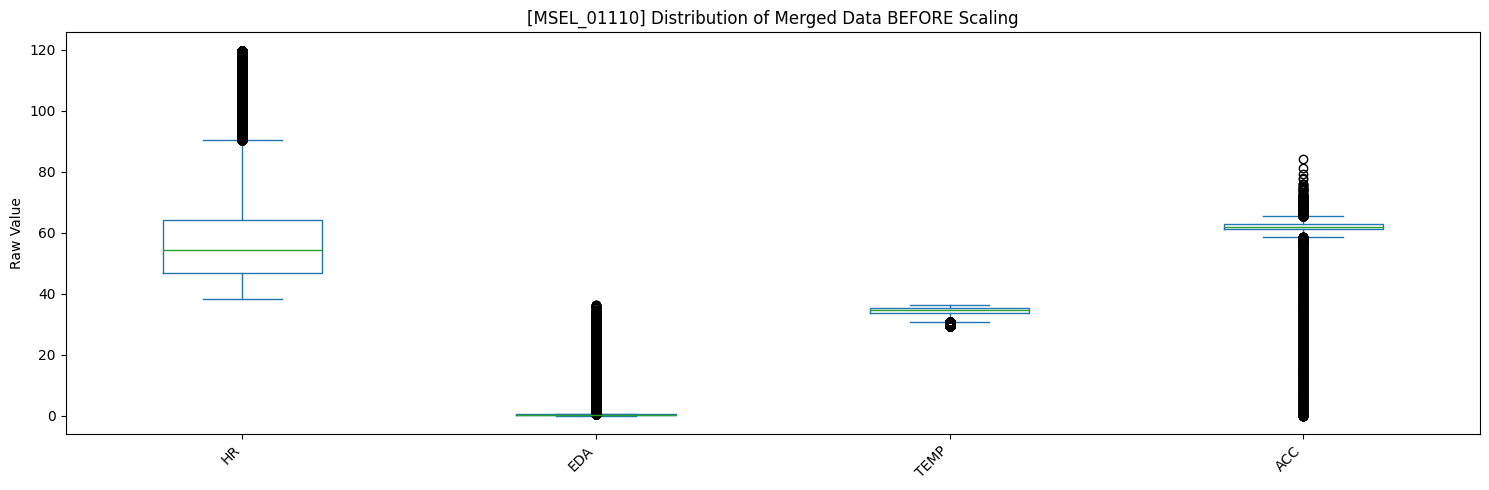

2025-06-09 21:29:31,115 - INFO - [MSEL_01110] Synchronized and scaled data stored.
2025-06-09 21:29:31,242 - INFO - 
[MSEL_01462] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:29:31,243 - INFO - [MSEL_01462] Performing full data preprocessing...
2025-06-09 21:29:31,248 - INFO - [MSEL_01462] Starting raw sensor data preprocessing...
2025-06-09 21:29:32,178 - INFO - [MSEL_01462]   Replacing 43 zero values with NaN for HR.
2025-06-09 21:29:32,294 - INFO - [MSEL_01462]   Interpolating 43 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:29:33,676 - INFO - [MSEL_01462]   Finished preprocessing for HR. New shape: (27982480, 1)
2025-06-09 21:29:34,832 - INFO - 

                                           HR
timestamp                                    
2019-09-23 18:14:43+00:00            66.00396
2019-09-23 18:14:43.007812500+00:00  66.00396
2019-09-23 18:14:43.015625+00:00     66.00396
2019-09-23 18:14:43.023437500+00:00  66.00396
2019-09-23 18:14:43.031250+00:00     66.00396


2025-06-09 21:29:40,527 - INFO - [MSEL_01462]   Original Frequency (approx): 116.28692922649245 Hz
2025-06-09 21:29:40,529 - INFO - 
[MSEL_01462]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-09-23 18:14:33.007812500+00:00  0.019182
2019-09-23 18:14:33.015625+00:00     0.037084
2019-09-23 18:14:33.023437500+00:00  0.056266
2019-09-23 18:14:33.031250+00:00     0.074169
2019-09-23 18:14:33.039062500+00:00  0.093350


2025-06-09 21:29:41,511 - INFO - [MSEL_01462]   Original Frequency (approx): 116.17387794565542 Hz
2025-06-09 21:29:41,512 - INFO - 
[MSEL_01462]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2019-09-23 18:14:34.750000+00:00     25.810659
2019-09-23 18:14:34.757812500+00:00  25.822388
2019-09-23 18:14:34.765625+00:00     25.834284
2019-09-23 18:14:34.773437500+00:00  25.846180
2019-09-23 18:14:34.781250+00:00     25.858074


2025-06-09 21:29:42,269 - INFO - [MSEL_01462]   Original Frequency (approx): 116.2830415286603 Hz
2025-06-09 21:29:42,270 - INFO - 
[MSEL_01462]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-09-23 18:14:33+00:00            62.519684
2019-09-23 18:14:33.007812500+00:00  62.885620
2019-09-23 18:14:33.015625+00:00     63.251541
2019-09-23 18:14:33.023437500+00:00  63.622772
2019-09-23 18:14:33.031250+00:00     63.988693


2025-06-09 21:29:42,988 - INFO - [MSEL_01462]   Original Frequency (approx): 116.27192905639484 Hz
2025-06-09 21:29:42,989 - INFO - [MSEL_01462] Starting synchronize and merge data process...
2025-06-09 21:29:42,990 - INFO - [MSEL_01462] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:29:44,019 - INFO - [MSEL_01462] Resampled sensor HR to 1Hz. Shape: (240634, 1)
2025-06-09 21:29:44,023 - INFO - [MSEL_01462] HR Resample Summary: Total=240634, NaNs=22018, Zeros=0
2025-06-09 21:29:44,027 - INFO - [MSEL_01462] Interpolating 22018 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:29:44,066 - INFO - [MSEL_01462] Finished interpolation for resampled sensor HR.
2025-06-09 21:29:44,96

                                  HR
timestamp                           
2019-09-23 18:14:43+00:00  66.003960
2019-09-23 18:14:44+00:00  66.166977
2019-09-23 18:14:45+00:00  65.053375
2019-09-23 18:14:46+00:00  67.151329
2019-09-23 18:14:47+00:00  70.057587
                                EDA
timestamp                          
2019-09-23 18:14:33+00:00  0.551865
2019-09-23 18:14:34+00:00  0.364490
2019-09-23 18:14:35+00:00  0.392423
2019-09-23 18:14:36+00:00  0.486353
2019-09-23 18:14:37+00:00  0.554847
                                TEMP
timestamp                           
2019-09-23 18:14:34+00:00  25.994593
2019-09-23 18:14:35+00:00  26.246130
2019-09-23 18:14:36+00:00  26.652657
2019-09-23 18:14:37+00:00  26.670160
2019-09-23 18:14:38+00:00  26.694513
                                  ACC
timestamp                            
2019-09-23 18:14:33+00:00   63.895557
2019-09-23 18:14:34+00:00   71.409904
2019-09-23 18:14:35+00:00  153.215836
2019-09-23 18:14:36+00:00  152.419434
20

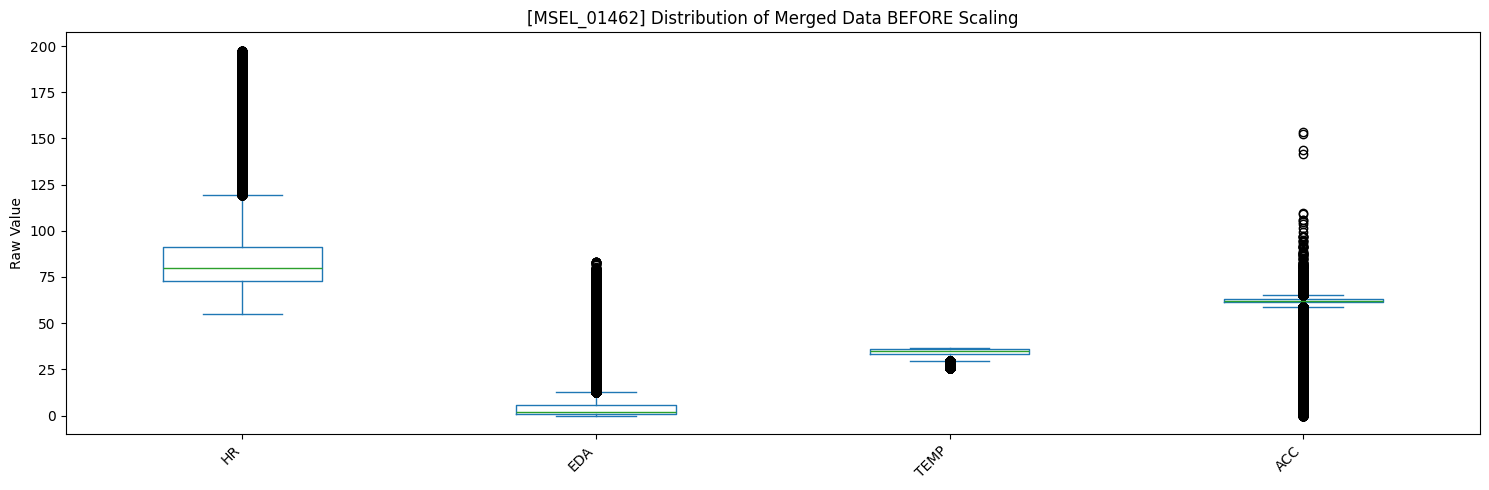

2025-06-09 21:29:47,515 - INFO - [MSEL_01462] Synchronized and scaled data stored.
2025-06-09 21:29:47,643 - INFO - 
[MSEL_01550] Starting full data preprocessing, synchronizing, merging, and scaling process...
2025-06-09 21:29:47,644 - INFO - [MSEL_01550] Performing full data preprocessing...
2025-06-09 21:29:47,644 - INFO - [MSEL_01550] Starting raw sensor data preprocessing...
2025-06-09 21:29:50,146 - INFO - [MSEL_01550]   Replacing 567 zero values with NaN for HR.
2025-06-09 21:29:50,366 - INFO - [MSEL_01550]   Interpolating 567 missing values for HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1930959395.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[sensor_name] = processed_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:29:53,089 - INFO - [MSEL_01550]   Finished preprocessing for HR. New shape: (53717886, 1)
2025-06-09 21:29:54,922 - INFO 

                                            HR
timestamp                                     
2019-03-08 16:03:58+00:00            71.002785
2019-03-08 16:03:58.007812500+00:00  71.049545
2019-03-08 16:03:58.015625+00:00     71.096298
2019-03-08 16:03:58.023437500+00:00  71.143059
2019-03-08 16:03:58.031250+00:00     71.189812


2025-06-09 21:30:04,594 - INFO - [MSEL_01550]   Original Frequency (approx): 126.82743280228195 Hz
2025-06-09 21:30:04,595 - INFO - 
[MSEL_01550]   EDA (Before Resampling):


                                          EDA
timestamp                                    
2019-03-08 16:03:48.007812500+00:00  0.001225
2019-03-08 16:03:48.015625+00:00     0.002451
2019-03-08 16:03:48.023437500+00:00  0.002451
2019-03-08 16:03:48.031250+00:00     0.003676
2019-03-08 16:03:48.039062500+00:00  0.004901


2025-06-09 21:30:06,969 - INFO - [MSEL_01550]   Original Frequency (approx): 126.4595890391882 Hz
2025-06-09 21:30:06,970 - INFO - 
[MSEL_01550]   TEMP (Before Resampling):


                                          TEMP
timestamp                                     
2019-03-08 16:03:48+00:00            32.649998
2019-03-08 16:03:48.007812500+00:00  32.649998
2019-03-08 16:03:48.015625+00:00     32.649998
2019-03-08 16:03:48.023437500+00:00  32.649998
2019-03-08 16:03:48.031250+00:00     32.649998


2025-06-09 21:30:08,857 - INFO - [MSEL_01550]   Original Frequency (approx): 126.71195295528776 Hz
2025-06-09 21:30:08,858 - INFO - 
[MSEL_01550]   ACC (Before Resampling):


                                           ACC
timestamp                                     
2019-03-08 16:03:48+00:00            62.512115
2019-03-08 16:03:48.007812500+00:00  62.490875
2019-03-08 16:03:48.015625+00:00     62.469620
2019-03-08 16:03:48.023437500+00:00  62.448380
2019-03-08 16:03:48.031250+00:00     62.432430


2025-06-09 21:30:10,902 - INFO - [MSEL_01550]   Original Frequency (approx): 126.82365667355532 Hz
2025-06-09 21:30:10,904 - INFO - [MSEL_01550] Starting synchronize and merge data process...
2025-06-09 21:30:10,905 - INFO - [MSEL_01550] Resampling and interpolating individual sensor data to 1Hz...
2025-06-09 21:30:12,893 - INFO - [MSEL_01550] Resampled sensor HR to 1Hz. Shape: (423551, 1)
2025-06-09 21:30:12,896 - INFO - [MSEL_01550] HR Resample Summary: Total=423551, NaNs=3878, Zeros=0
2025-06-09 21:30:12,898 - INFO - [MSEL_01550] Interpolating 3878 NaNs in resampled HR.
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1916226255.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_df[sensor_name] = resampled_df[sensor_name].fillna(method='ffill').fillna(method='bfill')
2025-06-09 21:30:12,914 - INFO - [MSEL_01550] Finished interpolation for resampled sensor HR.
2025-06-09 21:30:14,754 

                                  HR
timestamp                           
2019-03-08 16:03:58+00:00  73.979439
2019-03-08 16:03:59+00:00  74.026390
2019-03-08 16:04:00+00:00  69.390656
2019-03-08 16:04:01+00:00  69.464333
2019-03-08 16:04:02+00:00  69.615494
                                EDA
timestamp                          
2019-03-08 16:03:48+00:00  0.037858
2019-03-08 16:03:49+00:00  0.051337
2019-03-08 16:03:50+00:00  0.051394
2019-03-08 16:03:51+00:00  0.052906
2019-03-08 16:03:52+00:00  0.053596
                                TEMP
timestamp                           
2019-03-08 16:03:48+00:00  32.649998
2019-03-08 16:03:49+00:00  32.651230
2019-03-08 16:03:50+00:00  32.660110
2019-03-08 16:03:51+00:00  32.662525
2019-03-08 16:03:52+00:00  32.677711
                                 ACC
timestamp                           
2019-03-08 16:03:48+00:00  62.330971
2019-03-08 16:03:49+00:00  62.193893
2019-03-08 16:03:50+00:00  62.504650
2019-03-08 16:03:51+00:00  62.137081
2019-03-

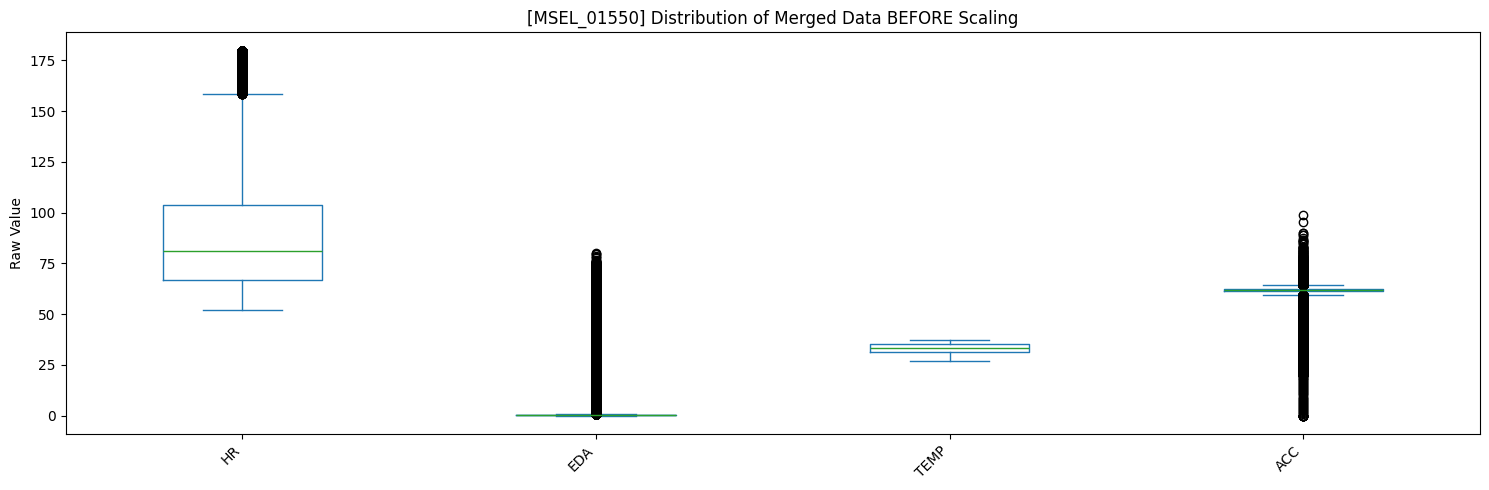

2025-06-09 21:30:19,353 - INFO - [MSEL_01550] Synchronized and scaled data stored.
2025-06-09 21:30:19,488 - INFO - 
--- Finished Synchronizing, Merging, and Scaling ---


In [ ]:
synced_scaled_data_list = []

logging.info("\n--- Starting Synchronizing, Merging, and Scaling for loaded patients ---")

# We will use the raw_patient_data_list here and apply preprocessing *within* this loop
# to ensure the full dataset is processed for synchronization, merging, and scaling.
# The previous preprocessing cell was primarily for visualizing the preprocessing step on a subset.

if raw_patient_data_list and patient_annotations_list: # Ensure both lists are available
    # Create dictionaries for easier lookup by patient_id
    raw_data_dict_lookup = {item['patient_id']: item['sensor_data_dict'] for item in raw_patient_data_list}
    preprocessed_annotations_dict_lookup = {item['patient_id']: item['preprocessed_annotations_df'] for item in patient_annotations_list}


    for patient_data in raw_patient_data_list: # Iterate through patients with raw data
        patient_id = patient_data['patient_id']
        raw_sensor_data_dict = raw_data_dict_lookup.get(patient_id) # Get raw sensor data
        # Get preprocessed annotations for this patient
        preprocessed_annotations_df = preprocessed_annotations_dict_lookup.get(patient_id)

        # Skip patient if raw sensor data is empty
        if not raw_sensor_data_dict:
             logging.warning(f"[{patient_id}] Skipping Synchronize/Merge/Scale: No raw sensor data available.")
             continue

        logging.info(f"\n[{patient_id}] Starting full data preprocessing, synchronizing, merging, and scaling process...")

        # --- Perform Full Data Preprocessing ---
        # This is where the full raw data is preprocessed before synchronization
        logging.info(f"[{patient_id}] Performing full data preprocessing...")
        preprocessed_sensor_data_dict_full = preprocess_raw_sensor_data(raw_sensor_data_dict, patient_id)
        logging.info(f"[{patient_id}] Full data preprocessing complete.")

        # Explicitly delete raw data dictionary to free memory as preprocessed full data is ready
        del raw_sensor_data_dict
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Skip if full preprocessing resulted in no data
        if not preprocessed_sensor_data_dict_full:
             logging.warning(f"[{patient_id}] Skipping Synchronize/Merge/Scale: No data remaining after full preprocessing.")
             continue


        # --- Before Resampling ---
        # We'll show a snapshot of the preprocessed full data before resampling
        logging.info(f"\n[{patient_id}] Data BEFORE Resampling (Snapshot of Preprocessed Full Data - First 5 rows per sensor):")
        for sensor_name, df in preprocessed_sensor_data_dict_full.items():
             logging.info(f"\n[{patient_id}]   {sensor_name} (Before Resampling):")
             print(df.head())
             if not df.empty and isinstance(df.index, pd.DatetimeIndex): # Check for DatetimeIndex
                 # Calculate approximate frequency
                 time_diffs = df.index.to_series().diff().dropna().dt.total_seconds()
                 approx_freq = 1 / time_diffs.mean() if not time_diffs.empty else 'N/A'
                 logging.info(f"[{patient_id}]   Original Frequency (approx): {approx_freq} Hz")
             elif not df.empty:
                 logging.warning(f"[{patient_id}]   Cannot calculate original frequency for {sensor_name}: Index is not DatetimeIndex.")


        # Perform Synchronize, Merge, and Scale on the full preprocessed data
        resampled_data_dict, merged_df_before_scaling = synchronize_and_merge_data(
            patient_id=patient_id,
            sensor_data_dict=preprocessed_sensor_data_dict_full, # Use the full preprocessed data
            target_freq_hz=SAMPLING_FREQ_HZ,
        )

        # Explicitly delete full preprocessed data dictionary to free memory
        del preprocessed_sensor_data_dict_full
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


        if merged_df_before_scaling is None:
            logging.warning(f"[{patient_id}] Skipping patient: Could not complete Synchronize, Merge steps.")
            continue # Skip to the next patient if this step fails

        # --- After Resampling ---
        logging.info(f"\n[{patient_id}] Data AFTER Resampling (First 5 rows per sensor):")
        if resampled_data_dict:
            for sensor_name, df in resampled_data_dict.items():
                logging.info(f"\n[{patient_id}]   {sensor_name} (After Resampling):")
                print(df.head())
                if not df.empty and df.index.name == 'timestamp':
                    # Calculate approximate frequency after resampling
                    time_diffs = df.index.to_series().diff().dropna().dt.total_seconds()
                    approx_freq = 1 / time_diffs.mean() if not time_diffs.empty else 'N/A'
                    logging.info(f"[{patient_id}]   Resampled Frequency (approx): {approx_freq} Hz")
        else:
            logging.warning(f"[{patient_id}] No data available after resampling.")


        # --- Before Merging ---
        # This is implicitly shown in the "After Resampling" step as separate dataframes.
        logging.info(f"\n[{patient_id}] Data BEFORE Merging (Individual Resampled DataFrames shown above).")


        # --- After Merging (Before Scaling) ---
        logging.info(f"\n[{patient_id}] Data AFTER Merging (BEFORE Scaling) - First 5 rows:")
        if merged_df_before_scaling is not None and not merged_df_before_scaling.empty:
            print(merged_df_before_scaling.head())
            logging.info(f"[{patient_id}] Merged (Before Scaling) Shape: {merged_df_before_scaling.shape}")
            # Plot distribution before scaling
            plt.figure(figsize=(15, 5))
            # Check if there are numeric columns to plot
            numeric_cols_before = merged_df_before_scaling.select_dtypes(include=np.number).columns
            if not numeric_cols_before.empty:
                merged_df_before_scaling[numeric_cols_before].plot(kind='box', ax=plt.gca()) # Box plot to show distribution and outliers
                plt.title(f'[{patient_id}] Distribution of Merged Data BEFORE Scaling')
                plt.ylabel('Raw Value')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
            else:
                logging.warning(f"[{patient_id}] No numeric data columns to plot distribution before scaling.")
        else:
            logging.warning(f"[{patient_id}] No data available after merging (before scaling).")

        # Store the result (synced and scaled data, and annotations for segmentation)
        synced_scaled_data_list.append({'patient_id': patient_id, 'synced_scaled_data': merged_df_before_scaling, 'annotations_df': preprocessed_annotations_df}) # Store annotations too for segmentation
        logging.info(f"[{patient_id}] Synchronized and scaled data stored.")

        # Explicitly delete intermediate dataframes to free memory
        del resampled_data_dict, merged_df_before_scaling
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


else:
     logging.warning("\nNo raw patient data or annotations loaded to perform Synchronization, Merging, and Scaling.")


logging.info("\n--- Finished Synchronizing, Merging, and Scaling ---")


#### Create Labelled Segments

2025-06-09 21:33:46,095 - INFO - 
--- Starting Creating Labeled Segments for loaded patients ---
2025-06-09 21:33:46,096 - INFO - 
[MSEL_00095] Creating labeled segments...
2025-06-09 21:33:46,097 - INFO - [MSEL_00095] Data BEFORE Segmentation (Synced and Scaled Data):
2025-06-09 21:33:46,097 - INFO - [MSEL_00095]   Shape: (600026, 4)
2025-06-09 21:33:46,100 - INFO - [MSEL_00095]   First 5 rows:
                                  HR       EDA       TEMP        ACC
timestamp                                                           
2018-11-27 20:12:16+00:00  71.003082  0.013842  27.450285  60.990372
2018-11-27 20:12:17+00:00  71.003082  0.022912  27.450285  61.029800
2018-11-27 20:12:18+00:00  71.003082  0.022702  27.447840  60.931023
2018-11-27 20:12:19+00:00  71.003082  0.023517  27.430210  61.083668
2018-11-27 20:12:20+00:00  71.003082  0.022531  27.430210  60.933559
2025-06-09 21:33:46,101 - INFO - [MSEL_00095]   Using 3 preprocessed seizure annotations.


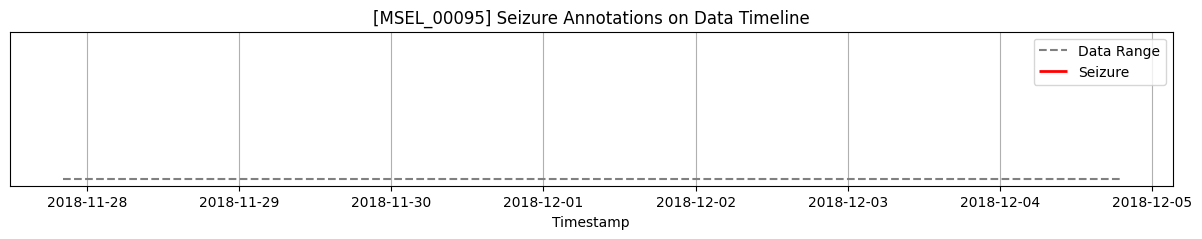

C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1355749397.py:35: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(signal)
C:\Users\XxOx\AppData\Local\Temp\ipykernel_16168\1355749397.py:36: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(signal)
2025-06-09 21:35:22,239 - INFO - Finished segmentation. Total full-length candidate segments: 20000
2025-06-09 21:35:22,240 - INFO -  Segments skipped (ictal): 17
2025-06-09 21:35:22,241 - INFO -  Segments skipped (interictal buffer, not pre-ictal): 1777
2025-06-09 21:35:22,241 - INFO -  Total segments included for labeling (Pre-ictal + Interictal): 18206
2025-06-09 21:35:22,242 - INFO -  Segments labeled Pre-ictal: 183, Interictal: 18023
2025-06-09 21:35:22,242 -

ValueError: too many values to unpack (expected 2)

In [56]:
all_patients_segments = []
all_patients_labels = []
processed_patient_ids = [] # Keep track of patient IDs that successfully produced segments

logging.info("\n--- Starting Creating Labeled Segments for loaded patients ---")

if synced_scaled_data_list: # Iterate through patients for whom synced/scaled data was generated
    for patient_processed_data in synced_scaled_data_list:
        patient_id = patient_processed_data['patient_id']
        synced_scaled_data = patient_processed_data['synced_scaled_data']
        annotations_df = patient_processed_data['annotations_df'] # Get annotations

        # Skip patient if synced/scaled data is None or empty
        if synced_scaled_data is None or synced_scaled_data.empty:
            logging.warning(f"[{patient_id}] Skipping Create Labeled Segments: No synced and scaled data available.")
            continue


        logging.info(f"\n[{patient_id}] Creating labeled segments...")

        # --- Before Segmentation ---
        logging.info(f"[{patient_id}] Data BEFORE Segmentation (Synced and Scaled Data):")
        logging.info(f"[{patient_id}]   Shape: {synced_scaled_data.shape}")
        logging.info(f"[{patient_id}]   First 5 rows:\n{synced_scaled_data.head()}")
        if annotations_df is not None and not annotations_df.empty:
             logging.info(f"[{patient_id}]   Using {len(annotations_df)} preprocessed seizure annotations.")
             # Optional: Plot annotations on a timeline relative to data start/end
             if not synced_scaled_data.empty:
                 data_start = synced_scaled_data.index.min()
                 data_end = synced_scaled_data.index.max()
                 plt.figure(figsize=(15, 2))
                 plt.hlines(1, data_start, data_end, color='gray', linestyle='--', label='Data Range')
                 for _, row in annotations_df.iterrows():
                      plt.hlines(1.1, row['start_time'], row['end_time'], color='red', linewidth=2, label='Seizure' if _ == 0 else "")
                 plt.title(f'[{patient_id}] Seizure Annotations on Data Timeline')
                 plt.xlabel('Timestamp')
                 plt.yticks([])
                 if len(annotations_df) > 0:
                     plt.legend()
                 plt.grid(True)
                 plt.show()
             else:
                 logging.warning(f"[{patient_id}] Cannot plot annotations on timeline: Synced data is empty.")


        # Perform Segmentation
        patient_segments, patient_labels = create_labeled_segments(
            synced_scaled_data,
            annotations_df,
            segment_duration_sec=SEGMENT_DURATION_SECONDS,
            pre_ictal_window_min=PRE_ICTAL_WINDOW_MINUTES,
            pre_ictal_gap_minutes=PRE_ICTAL_GAP_MINUTES,
            pre_ictal_exclusion_buffer_min=PRE_ICTAL_EXCLUSION_BUFFER_MINUTES,
            post_ictal_buffer_min=POST_ICTAL_BUFFER_MINUTES,
            target_freq_hz=SAMPLING_FREQ_HZ,
        )

        # Explicitly delete intermediate objects to free memory
        del synced_scaled_data, annotations_df # These are no longer needed
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # --- After Segmentation ---
        logging.info(f"\n[{patient_id}] Data AFTER Segmentation:")
        logging.info(f"[{patient_id}]   Segments shape: {patient_segments.shape}")
        logging.info(f"[{patient_id}]   Labels shape: {patient_labels.shape}")

        # Display class distribution for the current patient's segments
        if patient_labels.shape[0] > 0:
            unique_labels, counts = np.unique(patient_labels, return_counts=True)
            logging.info(f"[{patient_id}]   Class Distribution:")
            for label, count in zip(unique_labels, counts):
                logging.info(f"     Class {label}: {count} segments")
        else:
            logging.warning(f"[{patient_id}]   No labels generated after segmentation.")


        # Check if segments were created and have the correct expected shape
        expected_seq_len = int(SEGMENT_DURATION_SECONDS * SAMPLING_FREQ_HZ)
        expected_seq_len = max(1, expected_seq_len)
        expected_num_features = len(BASE_SENSORS)

        if (
            len(patient_segments) > 0
            and patient_segments.shape[1] == expected_seq_len
            and patient_segments.shape[2] == expected_num_features
        ):
            # Append segments and labels to the overall lists
            all_patients_segments.append(patient_segments)
            all_patients_labels.append(patient_labels)
            processed_patient_ids.append(patient_id) # Add to list of successfully processed IDs
            logging.info(f"[{patient_id}] Successfully processed and added to combined list.")

        else:
            logging.warning(f"[{patient_id}] Skipping patient: No valid segments created or incorrect shape after segmentation. Expected shape (N, {expected_seq_len}, {expected_num_features}), got {patient_segments.shape}. Not added to combined list.")

else:
     logging.warning("\nNo synced and scaled data available to create segments from.")

logging.info("\n--- Finished Creating Labeled Segments ---")
logging.info(f"Successfully created segments for {len(processed_patient_ids)} patients: {processed_patient_ids}")


#### Export sycned & merged unscaled data

In [ ]:
import pickle
from typing import Any, List, Tuple
import os

processed_patients_data: List[Tuple[Any, Any, Any, List[str]]] = []
OUTPUT_DIR = "final_v1"
cache_filename = f"processed_patient_data_n{len(patient_dirs_to_process)}_{get_data_config_identifier(PRE_ICTAL_WINDOW_MINUTES,PRE_ICTAL_EXCLUSION_BUFFER_MINUTES,POST_ICTAL_BUFFER_MINUTES,SAMPLING_FREQ_HZ)}_personalized_MS01110_FE.pkl"
# Use a dedicated cache directory within OUTPUT_DIR
PROCESSED_DATA_CACHE_DIR = os.path.join(OUTPUT_DIR, "cached_processed_data")
PROCESSED_DATA_CACHE_PATH = os.path.join(PROCESSED_DATA_CACHE_DIR, cache_filename)
for i in range(len(all_patients_segments)):
    patient_id = processed_patient_ids[i]
    patient_segments = all_patients_segments[i]
    patient_labels = all_patients_labels[i]

    # If sensors were patient-specific, you would derive them here for index i
    found_sensors = synced_scaled_data_list[i]['synced_scaled_data'].columns.tolist()

    # Create the tuple in the specified format (patient_id, segments, labels, sensors)
    result: Tuple[Any, Any, Any, List[str]] = (patient_id, patient_segments, patient_labels, found_sensors)

    # Append the result tuple to the processed_patients_data list
    processed_patients_data.append(result)
# After the loop, add the caching mechanism
try:
    os.makedirs(PROCESSED_DATA_CACHE_DIR, exist_ok=True)
    try:
        print(processed_patients_data)
        with open(PROCESSED_DATA_CACHE_PATH, 'wb') as f:
            # Use the list populated in the loop for caching
            pickle.dump(processed_patients_data, f)
        logging.info(f"Processed data for {len(patient_dirs_to_process)} patients cached to: {PROCESSED_DATA_CACHE_PATH}")
    except Exception as e:
        logging.error(f"Error saving processed data cache to {PROCESSED_DATA_CACHE_PATH}: {e}")
except Exception as e:
    logging.error(f"Error creating cache directory {PROCESSED_DATA_CACHE_DIR}: {e}")


2025-06-09 05:48:34,881 - INFO - Processed data for 10 patients cached to: final_v1\cached_processed_data\processed_patient_data_n10_piw_30_pieb_180_pib_180_sf_1_personalized_MS01110.pkl
